# Low-Level Vision Tutorial

## Introduction

This tutorial is about low-level vision. In this tutorial youwill learn how to reference and train a restorer using the APIs provided in MMEditing.

## Install MMEditing

MMEditing can be installed in two steps:

1. Install a compatible PyTorch version (You need to check you CUDA version by using nvcc -V).
2. Install pre-compiled MMCV
3. Clone and install MMEditing

The steps are shown below:

In [2]:
# Check GCC version (MMEditing needs gcc >= 5.0)
!gcc --version

gcc (GCC) 5.4.0
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

/data1/doc/COMP3340/tutorial


In [ ]:
# Build a new miniconda environment
!conda create -n mmediting9.2 python=3.8
!conda activate mmediting9.2
# !conda install ipykernel
# !python -m ipykernel install --user --name mmediting9.2 --display-name "Python mmediting9.2"

# install cudatoolkit=9.2
!conda install cudatoolkit=9.2

In [ ]:
# Install dependencies: (use cu9.2)
!pip install -U torch==1.7.1+cu92 torchvision==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html

# Install mmcv-full thus we could use CUDA operators
!pip install mmcv-full==1.3.5 -f https://download.openmmlab.com/mmcv/dist/cu92/torch1.7.1/index.html

# # Clone MMEditing
!rm -rf mmediting
!git clone https://github.com/open-mmlab/mmediting.git
%cd mmediting

# Install MMEditing
!pip install -r requirements.txt
!pip install -v -e .

In [1]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMEditing installation
import mmedit
print(mmedit.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.7.0+cu92 True
0.10.0
9.2
GCC 7.3


## Perform SR inference with a trained weight

In [2]:
!mkdir checkpoints
!wget https://download.openmmlab.com/mmediting/restorers/srcnn/srcnn_x4k915_1x16_1000k_div2k_20200608-4186f232.pth -P checkpoints

mkdir: cannot create directory ‘checkpoints’: File exists
--2021-11-22 13:37:01--  https://download.openmmlab.com/mmediting/restorers/srcnn/srcnn_x4k915_1x16_1000k_div2k_20200608-4186f232.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.106.53.69
Connecting to download.openmmlab.com (download.openmmlab.com)|47.106.53.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85911 (84K) [application/octet-stream]
Saving to: ‘checkpoints/srcnn_x4k915_1x16_1000k_div2k_20200608-4186f232.pth.1’

100%[======================================>] 85,911      --.-K/s   in 0.04s   

2021-11-22 13:37:02 (2.11 MB/s) - ‘checkpoints/srcnn_x4k915_1x16_1000k_div2k_20200608-4186f232.pth.1’ saved [85911/85911]



In [3]:
import os
import cv2
import numpy as np
from IPython.display import Image

import mmcv
import torch

from mmedit.apis import init_model, restoration_inference
from mmedit.core import tensor2img

In [4]:
config_file = 'configs/restorers/srcnn/srcnn_x4k915_g1_1000k_div2k.py'
checkpoint_file = 'checkpoints/srcnn_x4k915_1x16_1000k_div2k_20200608-4186f232.pth'

In [5]:
# build and initialize model
model = init_model(
        config_file, checkpoint_file, device=torch.device('cuda', 0))

Use load_from_local loader


In [6]:
# test a single image
img_path = 'demo/before.png'
output = restoration_inference(model, img_path)
output = tensor2img(output)

In [7]:
input = mmcv.imread(img_path)
output_shape = output.shape
input_bilinear = cv2.resize(input, (output_shape[1], output_shape[0]), interpolation=cv2.INTER_LINEAR)

bilinear upsample result and srcnn result


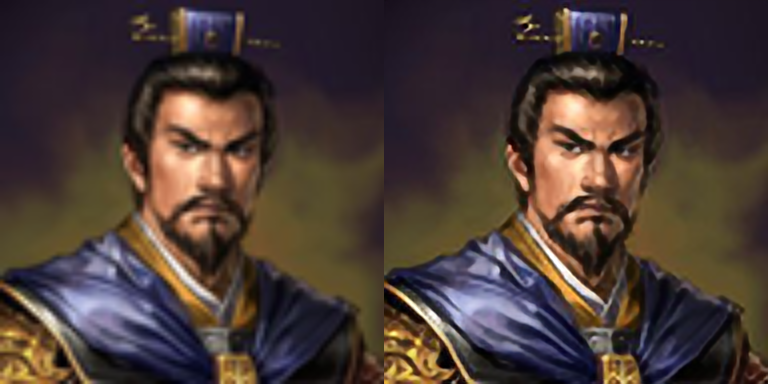

In [8]:
# show and write output
os.makedirs('results', exist_ok=True)
combine_result = np.concatenate([input_bilinear, output], axis=1)
mmcv.imwrite(combine_result, 'results/demo_bilinear_srcnn.png')

print('bilinear upsample result and srcnn result')
Image(filename='results/demo_bilinear_srcnn.png') 

## Perform SR training on a new dataset

To train on a new dataset, the following steps are neccesary.
1. Prepare training data pair.
2. Create a config file accordingly.
3. Perform training and evaluation

### Prepare training data pair
Dataset in low-level vision for training require degraded image and high-quality image simutanously. Here we take [DIV2K dataset](https://data.vision.ee.ethz.ch/cvl/DIV2K/) which is used for super-resolution as an example. It contains 800 images for training, 100 images for validation, and 100 images for testin.

In [32]:
# downlaod and unzip
# os.makedirs('data/DIV2K', exist_ok=True)
# HR images (train)
# !wget -c http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip -P data/DIV2K

# HR images (validation)
# !wget -c http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip -P data/DIV2K

# x4 LR images (train)
# !wget -c http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip -P data/DIV2K

# x4 LR images (validation)
# !wget -c http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip -P data/DIV2K

# %cd data/DIV2K
# !unzip DIV2K_valid_LR_bicubic_X4.zip
# !unzip DIV2K_train_LR_bicubic_X4.zip
# !unzip DIV2K_valid_HR.zip
# !unzip DIV2K_train_HR.zip

For efficiency, we tend to clip the images into small patch before trainig.

In [70]:
# crop training data and attain its meta infomation
%cd ../..
# %cd /data1/doc/COMP3340/tutorial
!pip install tqdm
!python scripts/extract_subimages.py
!python scripts/generate_meta_info.py


/data1/doc/COMP3340/tutorial
Folder data/DIV2K/DIV2K_valid_HR_sub already exists. Exit.


X4 LR Image


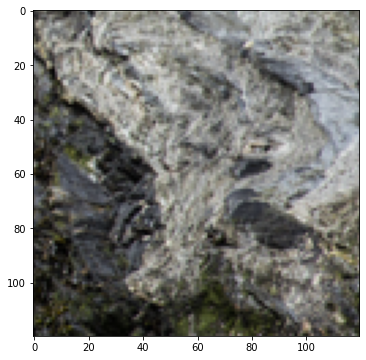

HR Image


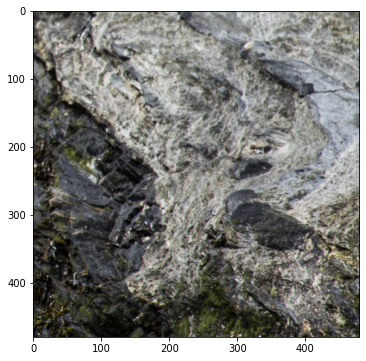

In [9]:
# Let's take a look at the dataset
import matplotlib.pyplot as plt
print('X4 LR Image')
img = mmcv.imread('data/DIV2K/DIV2K_valid_LR_bicubic/X4_sub/0801_s032.png')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

print('HR Image')
img = mmcv.imread('data/DIV2K/DIV2K_valid_HR_sub/0801_s032.png')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

### Create a config file

In the next step, we need to modify the config for the training

In [13]:
from mmcv import Config
cfg = Config.fromfile('configs/restorers/srcnn/srcnn_x4k915_g1_1000k_div2k_train.py')
cfg.gpus=1
# print(cfg)

### Train and Evaluation

In [14]:
import os.path as osp
import torch

from mmedit.apis import set_random_seed, train_model
from mmedit.datasets import build_dataset
from mmedit.models import build_model

import mmcv

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

model = build_model(
        cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_model(
        model,
        datasets,
        cfg,
        distributed=False,
        validate=True,
        meta=dict())


2021-11-22 14:43:34,121 - mmedit - INFO - Start running, host: sensetime@cn0014004135l, work_dir: /data1/doc/COMP3340/tutorial/work_dirs/srcnn_x4k915_g1_1000k_div2k
2021-11-22 14:43:34,121 - mmedit - INFO - workflow: [('train', 1)], max: 1000000 iters
2021-11-22 14:43:46,472 - mmedit - INFO - Iter [100/1000000]	lr_generator: 2.000e-04, eta: 1 day, 8:35:28, time: 0.117, data_time: 0.089, memory: 315, loss_pix: 0.1035, loss: 0.1035
2021-11-22 14:43:54,606 - mmedit - INFO - Iter [200/1000000]	lr_generator: 2.000e-04, eta: 1 day, 3:35:15, time: 0.081, data_time: 0.054, memory: 315, loss_pix: 0.0511, loss: 0.0511
2021-11-22 14:44:03,085 - mmedit - INFO - Iter [300/1000000]	lr_generator: 2.000e-04, eta: 1 day, 2:14:21, time: 0.085, data_time: 0.055, memory: 315, loss_pix: 0.0426, loss: 0.0426
2021-11-22 14:44:11,427 - mmedit - INFO - Iter [400/1000000]	lr_generator: 2.000e-04, eta: 1 day, 1:28:01, time: 0.083, data_time: 0.052, memory: 315, loss_pix: 0.0393, loss: 0.0393


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 4.2 task/s, elapsed: 1s, ETA:     0s

2021-11-22 14:44:18,823 - mmedit - INFO - Iter(val) [500]	PSNR: 26.0959, SSIM: 0.7273
2021-11-22 14:44:24,432 - mmedit - INFO - Iter [600/1000000]	lr_generator: 2.000e-04, eta: 20:06:49, time: 0.068, data_time: 0.039, memory: 315, loss_pix: 0.0370, loss: 0.0370
2021-11-22 14:44:30,054 - mmedit - INFO - Iter [700/1000000]	lr_generator: 2.000e-04, eta: 19:28:03, time: 0.056, data_time: 0.027, memory: 315, loss_pix: 0.0347, loss: 0.0347
2021-11-22 14:44:35,387 - mmedit - INFO - Iter [800/1000000]	lr_generator: 2.000e-04, eta: 18:52:58, time: 0.053, data_time: 0.024, memory: 315, loss_pix: 0.0364, loss: 0.0364
2021-11-22 14:44:40,162 - mmedit - INFO - Iter [900/1000000]	lr_generator: 2.000e-04, eta: 18:15:20, time: 0.048, data_time: 0.018, memory: 315, loss_pix: 0.0341, loss: 0.0341


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.0 task/s, elapsed: 0s, ETA:     0s

2021-11-22 14:44:45,252 - mmedit - INFO - Iter(val) [1000]	PSNR: 26.1678, SSIM: 0.7400
2021-11-22 14:44:49,479 - mmedit - INFO - Iter [1100/1000000]	lr_generator: 2.000e-04, eta: 16:06:41, time: 0.047, data_time: 0.017, memory: 315, loss_pix: 0.0341, loss: 0.0341
2021-11-22 14:44:53,760 - mmedit - INFO - Iter [1200/1000000]	lr_generator: 2.000e-04, eta: 15:45:24, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0341, loss: 0.0341
2021-11-22 14:44:57,970 - mmedit - INFO - Iter [1300/1000000]	lr_generator: 2.000e-04, eta: 15:26:30, time: 0.042, data_time: 0.011, memory: 315, loss_pix: 0.0344, loss: 0.0344
2021-11-22 14:45:02,367 - mmedit - INFO - Iter [1400/1000000]	lr_generator: 2.000e-04, eta: 15:12:30, time: 0.044, data_time: 0.013, memory: 315, loss_pix: 0.0329, loss: 0.0329


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.4 task/s, elapsed: 0s, ETA:     0s

2021-11-22 14:45:07,136 - mmedit - INFO - Iter(val) [1500]	PSNR: 26.6598, SSIM: 0.7561
2021-11-22 14:45:11,159 - mmedit - INFO - Iter [1600/1000000]	lr_generator: 2.000e-04, eta: 14:04:33, time: 0.044, data_time: 0.013, memory: 315, loss_pix: 0.0333, loss: 0.0333
2021-11-22 14:45:15,360 - mmedit - INFO - Iter [1700/1000000]	lr_generator: 2.000e-04, eta: 13:55:53, time: 0.042, data_time: 0.011, memory: 315, loss_pix: 0.0335, loss: 0.0335
2021-11-22 14:45:19,726 - mmedit - INFO - Iter [1800/1000000]	lr_generator: 2.000e-04, eta: 13:49:43, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0336, loss: 0.0336
2021-11-22 14:45:23,975 - mmedit - INFO - Iter [1900/1000000]	lr_generator: 2.000e-04, eta: 13:43:12, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0336, loss: 0.0336


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.5 task/s, elapsed: 0s, ETA:     0s

2021-11-22 14:45:28,659 - mmedit - INFO - Iter(val) [2000]	PSNR: 27.0184, SSIM: 0.7629
2021-11-22 14:45:32,674 - mmedit - INFO - Iter [2100/1000000]	lr_generator: 2.000e-04, eta: 12:59:47, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0317, loss: 0.0317
2021-11-22 14:45:36,983 - mmedit - INFO - Iter [2200/1000000]	lr_generator: 2.000e-04, eta: 12:56:50, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0309, loss: 0.0309
2021-11-22 14:45:41,100 - mmedit - INFO - Iter [2300/1000000]	lr_generator: 2.000e-04, eta: 12:52:45, time: 0.041, data_time: 0.010, memory: 315, loss_pix: 0.0315, loss: 0.0315
2021-11-22 14:45:45,296 - mmedit - INFO - Iter [2400/1000000]	lr_generator: 2.000e-04, eta: 12:49:32, time: 0.042, data_time: 0.010, memory: 315, loss_pix: 0.0317, loss: 0.0317


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.8 task/s, elapsed: 0s, ETA:     0s

2021-11-22 14:45:49,996 - mmedit - INFO - Iter(val) [2500]	PSNR: 27.0822, SSIM: 0.7686
2021-11-22 14:45:53,987 - mmedit - INFO - Iter [2600/1000000]	lr_generator: 1.999e-04, eta: 12:18:20, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0329, loss: 0.0329
2021-11-22 14:45:58,226 - mmedit - INFO - Iter [2700/1000000]	lr_generator: 1.999e-04, eta: 12:17:01, time: 0.042, data_time: 0.010, memory: 315, loss_pix: 0.0326, loss: 0.0326
2021-11-22 14:46:02,500 - mmedit - INFO - Iter [2800/1000000]	lr_generator: 1.999e-04, eta: 12:15:59, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0314, loss: 0.0314
2021-11-22 14:46:06,854 - mmedit - INFO - Iter [2900/1000000]	lr_generator: 1.999e-04, eta: 12:15:26, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0325, loss: 0.0325


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.0 task/s, elapsed: 0s, ETA:     0s

2021-11-22 14:46:11,491 - mmedit - INFO - Iter(val) [3000]	PSNR: 27.1151, SSIM: 0.7709
2021-11-22 14:46:15,527 - mmedit - INFO - Iter [3100/1000000]	lr_generator: 1.999e-04, eta: 11:52:04, time: 0.045, data_time: 0.013, memory: 315, loss_pix: 0.0315, loss: 0.0315
2021-11-22 14:46:19,768 - mmedit - INFO - Iter [3200/1000000]	lr_generator: 1.999e-04, eta: 11:51:45, time: 0.042, data_time: 0.010, memory: 315, loss_pix: 0.0323, loss: 0.0323
2021-11-22 14:46:24,149 - mmedit - INFO - Iter [3300/1000000]	lr_generator: 1.999e-04, eta: 11:52:11, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0318, loss: 0.0318
2021-11-22 14:46:28,222 - mmedit - INFO - Iter [3400/1000000]	lr_generator: 1.999e-04, eta: 11:51:04, time: 0.041, data_time: 0.010, memory: 315, loss_pix: 0.0310, loss: 0.0310


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.8 task/s, elapsed: 0s, ETA:     0s

2021-11-22 14:46:32,933 - mmedit - INFO - Iter(val) [3500]	PSNR: 27.2541, SSIM: 0.7724
2021-11-22 14:46:36,908 - mmedit - INFO - Iter [3600/1000000]	lr_generator: 1.999e-04, eta: 11:31:51, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0322, loss: 0.0322
2021-11-22 14:46:41,244 - mmedit - INFO - Iter [3700/1000000]	lr_generator: 1.999e-04, eta: 11:32:32, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0316, loss: 0.0316
2021-11-22 14:46:45,598 - mmedit - INFO - Iter [3800/1000000]	lr_generator: 1.999e-04, eta: 11:33:16, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0313, loss: 0.0313
2021-11-22 14:46:49,692 - mmedit - INFO - Iter [3900/1000000]	lr_generator: 1.999e-04, eta: 11:32:51, time: 0.041, data_time: 0.009, memory: 315, loss_pix: 0.0316, loss: 0.0316


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.5 task/s, elapsed: 0s, ETA:     0s

2021-11-22 14:46:54,406 - mmedit - INFO - Iter(val) [4000]	PSNR: 27.3834, SSIM: 0.7769
2021-11-22 14:46:58,520 - mmedit - INFO - Iter [4100/1000000]	lr_generator: 1.999e-04, eta: 11:17:29, time: 0.046, data_time: 0.014, memory: 315, loss_pix: 0.0315, loss: 0.0315
2021-11-22 14:47:04,556 - mmedit - INFO - Iter [4200/1000000]	lr_generator: 1.999e-04, eta: 11:25:07, time: 0.060, data_time: 0.024, memory: 315, loss_pix: 0.0317, loss: 0.0317
2021-11-22 14:47:11,423 - mmedit - INFO - Iter [4300/1000000]	lr_generator: 1.999e-04, eta: 11:35:38, time: 0.069, data_time: 0.033, memory: 315, loss_pix: 0.0304, loss: 0.0304
2021-11-22 14:47:16,306 - mmedit - INFO - Iter [4400/1000000]	lr_generator: 1.998e-04, eta: 11:38:10, time: 0.049, data_time: 0.016, memory: 315, loss_pix: 0.0322, loss: 0.0322


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 13.1 task/s, elapsed: 0s, ETA:     0s

2021-11-22 14:47:21,324 - mmedit - INFO - Iter(val) [4500]	PSNR: 27.4467, SSIM: 0.7774
2021-11-22 14:47:25,425 - mmedit - INFO - Iter [4600/1000000]	lr_generator: 1.998e-04, eta: 11:23:48, time: 0.045, data_time: 0.013, memory: 315, loss_pix: 0.0322, loss: 0.0322
2021-11-22 14:47:30,222 - mmedit - INFO - Iter [4700/1000000]	lr_generator: 1.998e-04, eta: 11:26:06, time: 0.048, data_time: 0.014, memory: 315, loss_pix: 0.0308, loss: 0.0308
2021-11-22 14:47:34,596 - mmedit - INFO - Iter [4800/1000000]	lr_generator: 1.998e-04, eta: 11:26:51, time: 0.044, data_time: 0.010, memory: 315, loss_pix: 0.0325, loss: 0.0325
2021-11-22 14:47:39,586 - mmedit - INFO - Iter [4900/1000000]	lr_generator: 1.998e-04, eta: 11:29:39, time: 0.050, data_time: 0.014, memory: 315, loss_pix: 0.0310, loss: 0.0310
2021-11-22 14:47:44,298 - mmedit - INFO - Saving checkpoint at 5000 iterations


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.5 task/s, elapsed: 0s, ETA:     0s

2021-11-22 14:47:44,939 - mmedit - INFO - Iter(val) [5000]	PSNR: 27.4270, SSIM: 0.7792
2021-11-22 14:47:48,988 - mmedit - INFO - Iter [5100/1000000]	lr_generator: 1.998e-04, eta: 11:17:40, time: 0.047, data_time: 0.015, memory: 315, loss_pix: 0.0318, loss: 0.0318
2021-11-22 14:47:53,139 - mmedit - INFO - Iter [5200/1000000]	lr_generator: 1.998e-04, eta: 11:17:48, time: 0.042, data_time: 0.010, memory: 315, loss_pix: 0.0300, loss: 0.0300
2021-11-22 14:47:57,485 - mmedit - INFO - Iter [5300/1000000]	lr_generator: 1.998e-04, eta: 11:18:32, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0308, loss: 0.0308
2021-11-22 14:48:01,891 - mmedit - INFO - Iter [5400/1000000]	lr_generator: 1.998e-04, eta: 11:19:26, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0312, loss: 0.0312


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 9.1 task/s, elapsed: 1s, ETA:     0s

2021-11-22 14:48:07,053 - mmedit - INFO - Iter(val) [5500]	PSNR: 27.5208, SSIM: 0.7808
2021-11-22 14:48:11,354 - mmedit - INFO - Iter [5600/1000000]	lr_generator: 1.998e-04, eta: 11:09:21, time: 0.048, data_time: 0.015, memory: 315, loss_pix: 0.0303, loss: 0.0303
2021-11-22 14:48:16,154 - mmedit - INFO - Iter [5700/1000000]	lr_generator: 1.997e-04, eta: 11:11:29, time: 0.048, data_time: 0.015, memory: 315, loss_pix: 0.0304, loss: 0.0304
2021-11-22 14:48:20,452 - mmedit - INFO - Iter [5800/1000000]	lr_generator: 1.997e-04, eta: 11:12:07, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0301, loss: 0.0301
2021-11-22 14:48:24,859 - mmedit - INFO - Iter [5900/1000000]	lr_generator: 1.997e-04, eta: 11:13:02, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0322, loss: 0.0322


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.5 task/s, elapsed: 0s, ETA:     0s

2021-11-22 14:48:29,517 - mmedit - INFO - Iter(val) [6000]	PSNR: 27.4733, SSIM: 0.7791
2021-11-22 14:48:33,524 - mmedit - INFO - Iter [6100/1000000]	lr_generator: 1.997e-04, eta: 11:02:52, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0314, loss: 0.0314
2021-11-22 14:48:39,018 - mmedit - INFO - Iter [6200/1000000]	lr_generator: 1.997e-04, eta: 11:06:50, time: 0.055, data_time: 0.020, memory: 315, loss_pix: 0.0306, loss: 0.0306
2021-11-22 14:48:43,651 - mmedit - INFO - Iter [6300/1000000]	lr_generator: 1.997e-04, eta: 11:08:19, time: 0.046, data_time: 0.012, memory: 315, loss_pix: 0.0317, loss: 0.0317
2021-11-22 14:48:48,140 - mmedit - INFO - Iter [6400/1000000]	lr_generator: 1.997e-04, eta: 11:09:25, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0321, loss: 0.0321


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 8.2 task/s, elapsed: 1s, ETA:     0s

2021-11-22 14:48:53,397 - mmedit - INFO - Iter(val) [6500]	PSNR: 27.4699, SSIM: 0.7798
2021-11-22 14:48:57,701 - mmedit - INFO - Iter [6600/1000000]	lr_generator: 1.997e-04, eta: 11:01:18, time: 0.049, data_time: 0.016, memory: 315, loss_pix: 0.0308, loss: 0.0308
2021-11-22 14:49:01,916 - mmedit - INFO - Iter [6700/1000000]	lr_generator: 1.996e-04, eta: 11:01:46, time: 0.042, data_time: 0.009, memory: 315, loss_pix: 0.0309, loss: 0.0309
2021-11-22 14:49:06,750 - mmedit - INFO - Iter [6800/1000000]	lr_generator: 1.996e-04, eta: 11:03:44, time: 0.048, data_time: 0.015, memory: 315, loss_pix: 0.0308, loss: 0.0308
2021-11-22 14:49:11,109 - mmedit - INFO - Iter [6900/1000000]	lr_generator: 1.996e-04, eta: 11:04:31, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0300, loss: 0.0300


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.8 task/s, elapsed: 0s, ETA:     0s

2021-11-22 14:49:15,724 - mmedit - INFO - Iter(val) [7000]	PSNR: 27.5722, SSIM: 0.7831
2021-11-22 14:49:19,922 - mmedit - INFO - Iter [7100/1000000]	lr_generator: 1.996e-04, eta: 10:56:20, time: 0.046, data_time: 0.014, memory: 315, loss_pix: 0.0299, loss: 0.0299
2021-11-22 14:49:24,183 - mmedit - INFO - Iter [7200/1000000]	lr_generator: 1.996e-04, eta: 10:56:56, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0309, loss: 0.0309
2021-11-22 14:49:28,362 - mmedit - INFO - Iter [7300/1000000]	lr_generator: 1.996e-04, eta: 10:57:21, time: 0.042, data_time: 0.010, memory: 315, loss_pix: 0.0303, loss: 0.0303
2021-11-22 14:49:32,626 - mmedit - INFO - Iter [7400/1000000]	lr_generator: 1.996e-04, eta: 10:57:56, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0298, loss: 0.0298


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 9.5 task/s, elapsed: 1s, ETA:     0s

2021-11-22 14:49:37,332 - mmedit - INFO - Iter(val) [7500]	PSNR: 27.4613, SSIM: 0.7815
2021-11-22 14:49:41,476 - mmedit - INFO - Iter [7600/1000000]	lr_generator: 1.995e-04, eta: 10:50:37, time: 0.047, data_time: 0.016, memory: 315, loss_pix: 0.0305, loss: 0.0305
2021-11-22 14:49:45,640 - mmedit - INFO - Iter [7700/1000000]	lr_generator: 1.995e-04, eta: 10:51:03, time: 0.042, data_time: 0.009, memory: 315, loss_pix: 0.0315, loss: 0.0315
2021-11-22 14:49:50,025 - mmedit - INFO - Iter [7800/1000000]	lr_generator: 1.995e-04, eta: 10:51:56, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0300, loss: 0.0300
2021-11-22 14:49:54,278 - mmedit - INFO - Iter [7900/1000000]	lr_generator: 1.995e-04, eta: 10:52:31, time: 0.042, data_time: 0.010, memory: 315, loss_pix: 0.0299, loss: 0.0299


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.4 task/s, elapsed: 0s, ETA:     0s

2021-11-22 14:49:58,978 - mmedit - INFO - Iter(val) [8000]	PSNR: 27.6319, SSIM: 0.7846
2021-11-22 14:50:03,050 - mmedit - INFO - Iter [8100/1000000]	lr_generator: 1.995e-04, eta: 10:45:23, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0295, loss: 0.0295
2021-11-22 14:50:07,169 - mmedit - INFO - Iter [8200/1000000]	lr_generator: 1.995e-04, eta: 10:45:45, time: 0.041, data_time: 0.009, memory: 315, loss_pix: 0.0301, loss: 0.0301
2021-11-22 14:50:11,622 - mmedit - INFO - Iter [8300/1000000]	lr_generator: 1.995e-04, eta: 10:46:46, time: 0.045, data_time: 0.011, memory: 315, loss_pix: 0.0300, loss: 0.0300
2021-11-22 14:50:15,711 - mmedit - INFO - Iter [8400/1000000]	lr_generator: 1.994e-04, eta: 10:47:03, time: 0.041, data_time: 0.009, memory: 315, loss_pix: 0.0294, loss: 0.0294


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.8 task/s, elapsed: 0s, ETA:     0s

2021-11-22 14:50:20,372 - mmedit - INFO - Iter(val) [8500]	PSNR: 27.6238, SSIM: 0.7836
2021-11-22 14:50:24,466 - mmedit - INFO - Iter [8600/1000000]	lr_generator: 1.994e-04, eta: 10:40:36, time: 0.045, data_time: 0.013, memory: 315, loss_pix: 0.0300, loss: 0.0300
2021-11-22 14:50:28,689 - mmedit - INFO - Iter [8700/1000000]	lr_generator: 1.994e-04, eta: 10:41:12, time: 0.042, data_time: 0.009, memory: 315, loss_pix: 0.0305, loss: 0.0305
2021-11-22 14:50:32,948 - mmedit - INFO - Iter [8800/1000000]	lr_generator: 1.994e-04, eta: 10:41:51, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0310, loss: 0.0310
2021-11-22 14:50:37,182 - mmedit - INFO - Iter [8900/1000000]	lr_generator: 1.994e-04, eta: 10:42:25, time: 0.042, data_time: 0.010, memory: 315, loss_pix: 0.0299, loss: 0.0299


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.6 task/s, elapsed: 0s, ETA:     0s

2021-11-22 14:50:41,918 - mmedit - INFO - Iter(val) [9000]	PSNR: 27.5499, SSIM: 0.7804
2021-11-22 14:50:45,969 - mmedit - INFO - Iter [9100/1000000]	lr_generator: 1.993e-04, eta: 10:36:17, time: 0.045, data_time: 0.013, memory: 315, loss_pix: 0.0304, loss: 0.0304
2021-11-22 14:50:50,227 - mmedit - INFO - Iter [9200/1000000]	lr_generator: 1.993e-04, eta: 10:36:57, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0297, loss: 0.0297
2021-11-22 14:50:54,417 - mmedit - INFO - Iter [9300/1000000]	lr_generator: 1.993e-04, eta: 10:37:28, time: 0.042, data_time: 0.009, memory: 315, loss_pix: 0.0305, loss: 0.0305
2021-11-22 14:50:58,701 - mmedit - INFO - Iter [9400/1000000]	lr_generator: 1.993e-04, eta: 10:38:09, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0303, loss: 0.0303


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 14.6 task/s, elapsed: 0s, ETA:     0s

2021-11-22 14:51:03,360 - mmedit - INFO - Iter(val) [9500]	PSNR: 27.6194, SSIM: 0.7845
2021-11-22 14:51:07,391 - mmedit - INFO - Iter [9600/1000000]	lr_generator: 1.993e-04, eta: 10:32:14, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0299, loss: 0.0299
2021-11-22 14:51:11,618 - mmedit - INFO - Iter [9700/1000000]	lr_generator: 1.993e-04, eta: 10:32:50, time: 0.042, data_time: 0.010, memory: 315, loss_pix: 0.0298, loss: 0.0298
2021-11-22 14:51:15,913 - mmedit - INFO - Iter [9800/1000000]	lr_generator: 1.992e-04, eta: 10:33:33, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0312, loss: 0.0312
2021-11-22 14:51:20,076 - mmedit - INFO - Iter [9900/1000000]	lr_generator: 1.992e-04, eta: 10:34:01, time: 0.042, data_time: 0.010, memory: 315, loss_pix: 0.0310, loss: 0.0310
2021-11-22 14:51:24,536 - mmedit - INFO - Saving checkpoint at 10000 iterations


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 14.1 task/s, elapsed: 0s, ETA:     0s

2021-11-22 14:51:24,914 - mmedit - INFO - Iter(val) [10000]	PSNR: 27.6532, SSIM: 0.7838
2021-11-22 14:51:28,988 - mmedit - INFO - Iter [10100/1000000]	lr_generator: 1.992e-04, eta: 10:28:35, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0309, loss: 0.0309
2021-11-22 14:51:33,181 - mmedit - INFO - Iter [10200/1000000]	lr_generator: 1.992e-04, eta: 10:29:09, time: 0.042, data_time: 0.010, memory: 315, loss_pix: 0.0294, loss: 0.0294
2021-11-22 14:51:37,382 - mmedit - INFO - Iter [10300/1000000]	lr_generator: 1.992e-04, eta: 10:29:41, time: 0.042, data_time: 0.009, memory: 315, loss_pix: 0.0304, loss: 0.0304
2021-11-22 14:51:41,639 - mmedit - INFO - Iter [10400/1000000]	lr_generator: 1.991e-04, eta: 10:30:19, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0298, loss: 0.0298


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.9 task/s, elapsed: 0s, ETA:     0s

2021-11-22 14:51:46,235 - mmedit - INFO - Iter(val) [10500]	PSNR: 27.6402, SSIM: 0.7860
2021-11-22 14:51:50,233 - mmedit - INFO - Iter [10600/1000000]	lr_generator: 1.991e-04, eta: 10:25:06, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0298, loss: 0.0298
2021-11-22 14:51:54,532 - mmedit - INFO - Iter [10700/1000000]	lr_generator: 1.991e-04, eta: 10:25:50, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0307, loss: 0.0307
2021-11-22 14:51:58,836 - mmedit - INFO - Iter [10800/1000000]	lr_generator: 1.991e-04, eta: 10:26:32, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0304, loss: 0.0304
2021-11-22 14:52:03,195 - mmedit - INFO - Iter [10900/1000000]	lr_generator: 1.991e-04, eta: 10:27:19, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0305, loss: 0.0305


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.4 task/s, elapsed: 0s, ETA:     0s

2021-11-22 14:52:07,828 - mmedit - INFO - Iter(val) [11000]	PSNR: 27.4464, SSIM: 0.7843
2021-11-22 14:52:11,802 - mmedit - INFO - Iter [11100/1000000]	lr_generator: 1.990e-04, eta: 10:22:23, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0305, loss: 0.0305
2021-11-22 14:52:16,506 - mmedit - INFO - Iter [11200/1000000]	lr_generator: 1.990e-04, eta: 10:23:41, time: 0.047, data_time: 0.015, memory: 315, loss_pix: 0.0306, loss: 0.0306
2021-11-22 14:52:20,694 - mmedit - INFO - Iter [11300/1000000]	lr_generator: 1.990e-04, eta: 10:24:12, time: 0.042, data_time: 0.009, memory: 315, loss_pix: 0.0303, loss: 0.0303
2021-11-22 14:52:25,096 - mmedit - INFO - Iter [11400/1000000]	lr_generator: 1.990e-04, eta: 10:25:01, time: 0.044, data_time: 0.010, memory: 315, loss_pix: 0.0297, loss: 0.0297


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.3 task/s, elapsed: 0s, ETA:     0s

2021-11-22 14:52:29,647 - mmedit - INFO - Iter(val) [11500]	PSNR: 27.6265, SSIM: 0.7837
2021-11-22 14:52:33,673 - mmedit - INFO - Iter [11600/1000000]	lr_generator: 1.989e-04, eta: 10:20:24, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0300, loss: 0.0300
2021-11-22 14:52:37,938 - mmedit - INFO - Iter [11700/1000000]	lr_generator: 1.989e-04, eta: 10:21:02, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0289, loss: 0.0289
2021-11-22 14:52:42,410 - mmedit - INFO - Iter [11800/1000000]	lr_generator: 1.989e-04, eta: 10:21:57, time: 0.045, data_time: 0.013, memory: 315, loss_pix: 0.0302, loss: 0.0302
2021-11-22 14:52:46,630 - mmedit - INFO - Iter [11900/1000000]	lr_generator: 1.989e-04, eta: 10:22:30, time: 0.042, data_time: 0.010, memory: 315, loss_pix: 0.0301, loss: 0.0301


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.2 task/s, elapsed: 0s, ETA:     0s

2021-11-22 14:52:51,306 - mmedit - INFO - Iter(val) [12000]	PSNR: 27.6455, SSIM: 0.7842
2021-11-22 14:52:55,407 - mmedit - INFO - Iter [12100/1000000]	lr_generator: 1.988e-04, eta: 10:18:19, time: 0.046, data_time: 0.014, memory: 315, loss_pix: 0.0314, loss: 0.0314
2021-11-22 14:52:59,573 - mmedit - INFO - Iter [12200/1000000]	lr_generator: 1.988e-04, eta: 10:18:48, time: 0.042, data_time: 0.010, memory: 315, loss_pix: 0.0296, loss: 0.0296
2021-11-22 14:53:03,942 - mmedit - INFO - Iter [12300/1000000]	lr_generator: 1.988e-04, eta: 10:19:34, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0305, loss: 0.0305
2021-11-22 14:53:08,168 - mmedit - INFO - Iter [12400/1000000]	lr_generator: 1.988e-04, eta: 10:20:07, time: 0.042, data_time: 0.009, memory: 315, loss_pix: 0.0304, loss: 0.0304


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.7 task/s, elapsed: 0s, ETA:     0s

2021-11-22 14:53:12,938 - mmedit - INFO - Iter(val) [12500]	PSNR: 27.6124, SSIM: 0.7855
2021-11-22 14:53:16,922 - mmedit - INFO - Iter [12600/1000000]	lr_generator: 1.987e-04, eta: 10:15:53, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0314, loss: 0.0314
2021-11-22 14:53:21,314 - mmedit - INFO - Iter [12700/1000000]	lr_generator: 1.987e-04, eta: 10:16:40, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0309, loss: 0.0309
2021-11-22 14:53:25,672 - mmedit - INFO - Iter [12800/1000000]	lr_generator: 1.987e-04, eta: 10:17:23, time: 0.044, data_time: 0.010, memory: 315, loss_pix: 0.0294, loss: 0.0294
2021-11-22 14:53:29,877 - mmedit - INFO - Iter [12900/1000000]	lr_generator: 1.987e-04, eta: 10:17:54, time: 0.042, data_time: 0.010, memory: 315, loss_pix: 0.0299, loss: 0.0299


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.4 task/s, elapsed: 0s, ETA:     0s

2021-11-22 14:53:34,523 - mmedit - INFO - Iter(val) [13000]	PSNR: 27.7054, SSIM: 0.7870
2021-11-22 14:53:38,682 - mmedit - INFO - Iter [13100/1000000]	lr_generator: 1.986e-04, eta: 10:14:06, time: 0.046, data_time: 0.014, memory: 315, loss_pix: 0.0303, loss: 0.0303
2021-11-22 14:53:42,864 - mmedit - INFO - Iter [13200/1000000]	lr_generator: 1.986e-04, eta: 10:14:35, time: 0.042, data_time: 0.008, memory: 315, loss_pix: 0.0313, loss: 0.0313
2021-11-22 14:53:47,188 - mmedit - INFO - Iter [13300/1000000]	lr_generator: 1.986e-04, eta: 10:15:14, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0293, loss: 0.0293
2021-11-22 14:53:51,341 - mmedit - INFO - Iter [13400/1000000]	lr_generator: 1.986e-04, eta: 10:15:42, time: 0.042, data_time: 0.010, memory: 315, loss_pix: 0.0310, loss: 0.0310


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.6 task/s, elapsed: 0s, ETA:     0s

2021-11-22 14:53:56,151 - mmedit - INFO - Iter(val) [13500]	PSNR: 27.6775, SSIM: 0.7882
2021-11-22 14:54:00,323 - mmedit - INFO - Iter [13600/1000000]	lr_generator: 1.985e-04, eta: 10:12:04, time: 0.046, data_time: 0.013, memory: 315, loss_pix: 0.0310, loss: 0.0310
2021-11-22 14:54:04,707 - mmedit - INFO - Iter [13700/1000000]	lr_generator: 1.985e-04, eta: 10:12:48, time: 0.044, data_time: 0.010, memory: 315, loss_pix: 0.0303, loss: 0.0303
2021-11-22 14:54:09,375 - mmedit - INFO - Iter [13800/1000000]	lr_generator: 1.985e-04, eta: 10:13:51, time: 0.047, data_time: 0.013, memory: 315, loss_pix: 0.0299, loss: 0.0299
2021-11-22 14:54:13,700 - mmedit - INFO - Iter [13900/1000000]	lr_generator: 1.985e-04, eta: 10:14:28, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0307, loss: 0.0307


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.9 task/s, elapsed: 0s, ETA:     0s

2021-11-22 14:54:18,513 - mmedit - INFO - Iter(val) [14000]	PSNR: 27.6815, SSIM: 0.7832
2021-11-22 14:54:22,778 - mmedit - INFO - Iter [14100/1000000]	lr_generator: 1.984e-04, eta: 10:11:07, time: 0.047, data_time: 0.014, memory: 315, loss_pix: 0.0283, loss: 0.0283
2021-11-22 14:54:27,034 - mmedit - INFO - Iter [14200/1000000]	lr_generator: 1.984e-04, eta: 10:11:41, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0303, loss: 0.0303
2021-11-22 14:54:31,375 - mmedit - INFO - Iter [14300/1000000]	lr_generator: 1.984e-04, eta: 10:12:20, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0298, loss: 0.0298
2021-11-22 14:54:35,510 - mmedit - INFO - Iter [14400/1000000]	lr_generator: 1.984e-04, eta: 10:12:44, time: 0.041, data_time: 0.009, memory: 315, loss_pix: 0.0289, loss: 0.0289


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.2 task/s, elapsed: 0s, ETA:     0s

2021-11-22 14:54:40,266 - mmedit - INFO - Iter(val) [14500]	PSNR: 27.6429, SSIM: 0.7868
2021-11-22 14:54:44,500 - mmedit - INFO - Iter [14600/1000000]	lr_generator: 1.983e-04, eta: 10:09:31, time: 0.047, data_time: 0.015, memory: 315, loss_pix: 0.0301, loss: 0.0301
2021-11-22 14:54:48,776 - mmedit - INFO - Iter [14700/1000000]	lr_generator: 1.983e-04, eta: 10:10:05, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0309, loss: 0.0309
2021-11-22 14:54:53,241 - mmedit - INFO - Iter [14800/1000000]	lr_generator: 1.983e-04, eta: 10:10:51, time: 0.045, data_time: 0.013, memory: 315, loss_pix: 0.0292, loss: 0.0292
2021-11-22 14:54:57,600 - mmedit - INFO - Iter [14900/1000000]	lr_generator: 1.983e-04, eta: 10:11:30, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0292, loss: 0.0292
2021-11-22 14:55:02,099 - mmedit - INFO - Saving checkpoint at 15000 iterations


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.8 task/s, elapsed: 0s, ETA:     0s

2021-11-22 14:55:02,588 - mmedit - INFO - Iter(val) [15000]	PSNR: 27.5223, SSIM: 0.7888
2021-11-22 14:55:06,851 - mmedit - INFO - Iter [15100/1000000]	lr_generator: 1.982e-04, eta: 10:08:25, time: 0.047, data_time: 0.015, memory: 315, loss_pix: 0.0302, loss: 0.0302
2021-11-22 14:55:11,238 - mmedit - INFO - Iter [15200/1000000]	lr_generator: 1.982e-04, eta: 10:09:06, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0302, loss: 0.0302
2021-11-22 14:55:15,633 - mmedit - INFO - Iter [15300/1000000]	lr_generator: 1.982e-04, eta: 10:09:46, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0303, loss: 0.0303
2021-11-22 14:55:20,063 - mmedit - INFO - Iter [15400/1000000]	lr_generator: 1.981e-04, eta: 10:10:28, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0303, loss: 0.0303


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.7 task/s, elapsed: 0s, ETA:     0s

2021-11-22 14:55:24,724 - mmedit - INFO - Iter(val) [15500]	PSNR: 27.7327, SSIM: 0.7850
2021-11-22 14:55:28,733 - mmedit - INFO - Iter [15600/1000000]	lr_generator: 1.981e-04, eta: 10:07:10, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0305, loss: 0.0305
2021-11-22 14:55:33,008 - mmedit - INFO - Iter [15700/1000000]	lr_generator: 1.981e-04, eta: 10:07:42, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0300, loss: 0.0300
2021-11-22 14:55:37,416 - mmedit - INFO - Iter [15800/1000000]	lr_generator: 1.980e-04, eta: 10:08:21, time: 0.044, data_time: 0.010, memory: 315, loss_pix: 0.0294, loss: 0.0294
2021-11-22 14:55:41,911 - mmedit - INFO - Iter [15900/1000000]	lr_generator: 1.980e-04, eta: 10:09:07, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0305, loss: 0.0305


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.0 task/s, elapsed: 0s, ETA:     0s

2021-11-22 14:55:46,866 - mmedit - INFO - Iter(val) [16000]	PSNR: 27.7180, SSIM: 0.7892
2021-11-22 14:55:51,047 - mmedit - INFO - Iter [16100/1000000]	lr_generator: 1.980e-04, eta: 10:06:06, time: 0.046, data_time: 0.012, memory: 315, loss_pix: 0.0295, loss: 0.0295
2021-11-22 14:55:55,492 - mmedit - INFO - Iter [16200/1000000]	lr_generator: 1.979e-04, eta: 10:06:47, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0296, loss: 0.0296
2021-11-22 14:55:59,850 - mmedit - INFO - Iter [16300/1000000]	lr_generator: 1.979e-04, eta: 10:07:23, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0298, loss: 0.0298
2021-11-22 14:56:04,227 - mmedit - INFO - Iter [16400/1000000]	lr_generator: 1.979e-04, eta: 10:08:00, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0297, loss: 0.0297


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.3 task/s, elapsed: 0s, ETA:     0s

2021-11-22 14:56:08,968 - mmedit - INFO - Iter(val) [16500]	PSNR: 27.7567, SSIM: 0.7864
2021-11-22 14:56:12,979 - mmedit - INFO - Iter [16600/1000000]	lr_generator: 1.978e-04, eta: 10:04:56, time: 0.044, data_time: 0.013, memory: 315, loss_pix: 0.0301, loss: 0.0301
2021-11-22 14:56:17,271 - mmedit - INFO - Iter [16700/1000000]	lr_generator: 1.978e-04, eta: 10:05:28, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0293, loss: 0.0293
2021-11-22 14:56:21,523 - mmedit - INFO - Iter [16800/1000000]	lr_generator: 1.978e-04, eta: 10:05:57, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0303, loss: 0.0303
2021-11-22 14:56:25,852 - mmedit - INFO - Iter [16900/1000000]	lr_generator: 1.978e-04, eta: 10:06:29, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0301, loss: 0.0301


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 9.9 task/s, elapsed: 1s, ETA:     0s

2021-11-22 14:56:30,608 - mmedit - INFO - Iter(val) [17000]	PSNR: 27.7876, SSIM: 0.7892
2021-11-22 14:56:34,660 - mmedit - INFO - Iter [17100/1000000]	lr_generator: 1.977e-04, eta: 10:03:37, time: 0.045, data_time: 0.013, memory: 315, loss_pix: 0.0306, loss: 0.0306
2021-11-22 14:56:38,853 - mmedit - INFO - Iter [17200/1000000]	lr_generator: 1.977e-04, eta: 10:04:03, time: 0.042, data_time: 0.010, memory: 315, loss_pix: 0.0299, loss: 0.0299
2021-11-22 14:56:43,287 - mmedit - INFO - Iter [17300/1000000]	lr_generator: 1.976e-04, eta: 10:04:42, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0307, loss: 0.0307
2021-11-22 14:56:47,634 - mmedit - INFO - Iter [17400/1000000]	lr_generator: 1.976e-04, eta: 10:05:15, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0303, loss: 0.0303


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 13.2 task/s, elapsed: 0s, ETA:     0s

2021-11-22 14:56:52,333 - mmedit - INFO - Iter(val) [17500]	PSNR: 27.7818, SSIM: 0.7904
2021-11-22 14:56:56,516 - mmedit - INFO - Iter [17600/1000000]	lr_generator: 1.976e-04, eta: 10:02:29, time: 0.045, data_time: 0.013, memory: 315, loss_pix: 0.0306, loss: 0.0306
2021-11-22 14:57:01,057 - mmedit - INFO - Iter [17700/1000000]	lr_generator: 1.975e-04, eta: 10:03:13, time: 0.045, data_time: 0.013, memory: 315, loss_pix: 0.0312, loss: 0.0312
2021-11-22 14:57:05,681 - mmedit - INFO - Iter [17800/1000000]	lr_generator: 1.975e-04, eta: 10:04:01, time: 0.046, data_time: 0.012, memory: 315, loss_pix: 0.0302, loss: 0.0302
2021-11-22 14:57:10,271 - mmedit - INFO - Iter [17900/1000000]	lr_generator: 1.975e-04, eta: 10:04:47, time: 0.046, data_time: 0.013, memory: 315, loss_pix: 0.0300, loss: 0.0300


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.4 task/s, elapsed: 0s, ETA:     0s

2021-11-22 14:57:15,247 - mmedit - INFO - Iter(val) [18000]	PSNR: 27.7655, SSIM: 0.7870
2021-11-22 14:57:19,302 - mmedit - INFO - Iter [18100/1000000]	lr_generator: 1.974e-04, eta: 10:02:04, time: 0.045, data_time: 0.013, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 14:57:23,632 - mmedit - INFO - Iter [18200/1000000]	lr_generator: 1.974e-04, eta: 10:02:35, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0292, loss: 0.0292
2021-11-22 14:57:27,940 - mmedit - INFO - Iter [18300/1000000]	lr_generator: 1.974e-04, eta: 10:03:05, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0307, loss: 0.0307
2021-11-22 14:57:32,255 - mmedit - INFO - Iter [18400/1000000]	lr_generator: 1.973e-04, eta: 10:03:35, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0293, loss: 0.0293


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.4 task/s, elapsed: 0s, ETA:     0s

2021-11-22 14:57:36,887 - mmedit - INFO - Iter(val) [18500]	PSNR: 27.5042, SSIM: 0.7892
2021-11-22 14:57:40,983 - mmedit - INFO - Iter [18600/1000000]	lr_generator: 1.973e-04, eta: 10:00:56, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0297, loss: 0.0297
2021-11-22 14:57:45,381 - mmedit - INFO - Iter [18700/1000000]	lr_generator: 1.973e-04, eta: 10:01:31, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0289, loss: 0.0289
2021-11-22 14:57:50,024 - mmedit - INFO - Iter [18800/1000000]	lr_generator: 1.972e-04, eta: 10:02:17, time: 0.046, data_time: 0.013, memory: 315, loss_pix: 0.0298, loss: 0.0298
2021-11-22 14:57:54,618 - mmedit - INFO - Iter [18900/1000000]	lr_generator: 1.972e-04, eta: 10:03:01, time: 0.046, data_time: 0.013, memory: 315, loss_pix: 0.0309, loss: 0.0309


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.3 task/s, elapsed: 0s, ETA:     0s

2021-11-22 14:57:59,381 - mmedit - INFO - Iter(val) [19000]	PSNR: 27.7843, SSIM: 0.7885
2021-11-22 14:58:04,080 - mmedit - INFO - Iter [19100/1000000]	lr_generator: 1.971e-04, eta: 10:00:57, time: 0.051, data_time: 0.016, memory: 315, loss_pix: 0.0297, loss: 0.0297
2021-11-22 14:58:08,556 - mmedit - INFO - Iter [19200/1000000]	lr_generator: 1.971e-04, eta: 10:01:34, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0300, loss: 0.0300
2021-11-22 14:58:12,982 - mmedit - INFO - Iter [19300/1000000]	lr_generator: 1.971e-04, eta: 10:02:08, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0298, loss: 0.0298
2021-11-22 14:58:17,616 - mmedit - INFO - Iter [19400/1000000]	lr_generator: 1.970e-04, eta: 10:02:52, time: 0.046, data_time: 0.013, memory: 315, loss_pix: 0.0302, loss: 0.0302


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 9.3 task/s, elapsed: 1s, ETA:     0s

2021-11-22 14:58:22,640 - mmedit - INFO - Iter(val) [19500]	PSNR: 27.8277, SSIM: 0.7906
2021-11-22 14:58:26,860 - mmedit - INFO - Iter [19600/1000000]	lr_generator: 1.970e-04, eta: 10:00:33, time: 0.047, data_time: 0.013, memory: 315, loss_pix: 0.0297, loss: 0.0297
2021-11-22 14:58:31,681 - mmedit - INFO - Iter [19700/1000000]	lr_generator: 1.970e-04, eta: 10:01:26, time: 0.048, data_time: 0.015, memory: 315, loss_pix: 0.0314, loss: 0.0314
2021-11-22 14:58:36,164 - mmedit - INFO - Iter [19800/1000000]	lr_generator: 1.969e-04, eta: 10:02:02, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0301, loss: 0.0301
2021-11-22 14:58:40,668 - mmedit - INFO - Iter [19900/1000000]	lr_generator: 1.969e-04, eta: 10:02:39, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0292, loss: 0.0292
2021-11-22 14:58:45,183 - mmedit - INFO - Saving checkpoint at 20000 iterations


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.9 task/s, elapsed: 0s, ETA:     0s

2021-11-22 14:58:45,637 - mmedit - INFO - Iter(val) [20000]	PSNR: 27.7802, SSIM: 0.7912
2021-11-22 14:58:49,792 - mmedit - INFO - Iter [20100/1000000]	lr_generator: 1.968e-04, eta: 10:00:16, time: 0.046, data_time: 0.013, memory: 315, loss_pix: 0.0284, loss: 0.0284
2021-11-22 14:58:54,106 - mmedit - INFO - Iter [20200/1000000]	lr_generator: 1.968e-04, eta: 10:00:43, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0294, loss: 0.0294
2021-11-22 14:58:58,716 - mmedit - INFO - Iter [20300/1000000]	lr_generator: 1.968e-04, eta: 10:01:24, time: 0.046, data_time: 0.013, memory: 315, loss_pix: 0.0286, loss: 0.0286
2021-11-22 14:59:03,486 - mmedit - INFO - Iter [20400/1000000]	lr_generator: 1.967e-04, eta: 10:02:13, time: 0.048, data_time: 0.014, memory: 315, loss_pix: 0.0288, loss: 0.0288


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.4 task/s, elapsed: 0s, ETA:     0s

2021-11-22 14:59:08,481 - mmedit - INFO - Iter(val) [20500]	PSNR: 27.8004, SSIM: 0.7914
2021-11-22 14:59:12,960 - mmedit - INFO - Iter [20600/1000000]	lr_generator: 1.967e-04, eta: 10:00:10, time: 0.049, data_time: 0.017, memory: 315, loss_pix: 0.0308, loss: 0.0308
2021-11-22 14:59:17,324 - mmedit - INFO - Iter [20700/1000000]	lr_generator: 1.966e-04, eta: 10:00:39, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0294, loss: 0.0294
2021-11-22 14:59:21,538 - mmedit - INFO - Iter [20800/1000000]	lr_generator: 1.966e-04, eta: 10:01:00, time: 0.042, data_time: 0.011, memory: 315, loss_pix: 0.0297, loss: 0.0297
2021-11-22 14:59:25,771 - mmedit - INFO - Iter [20900/1000000]	lr_generator: 1.966e-04, eta: 10:01:22, time: 0.042, data_time: 0.011, memory: 315, loss_pix: 0.0299, loss: 0.0299


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 9.7 task/s, elapsed: 1s, ETA:     0s

2021-11-22 14:59:31,002 - mmedit - INFO - Iter(val) [21000]	PSNR: 27.8496, SSIM: 0.7908
2021-11-22 14:59:35,281 - mmedit - INFO - Iter [21100/1000000]	lr_generator: 1.965e-04, eta: 9:59:15, time: 0.048, data_time: 0.014, memory: 315, loss_pix: 0.0294, loss: 0.0294
2021-11-22 14:59:39,842 - mmedit - INFO - Iter [21200/1000000]	lr_generator: 1.965e-04, eta: 9:59:53, time: 0.046, data_time: 0.013, memory: 315, loss_pix: 0.0301, loss: 0.0301
2021-11-22 14:59:44,402 - mmedit - INFO - Iter [21300/1000000]	lr_generator: 1.964e-04, eta: 10:00:29, time: 0.046, data_time: 0.011, memory: 315, loss_pix: 0.0297, loss: 0.0297
2021-11-22 14:59:48,972 - mmedit - INFO - Iter [21400/1000000]	lr_generator: 1.964e-04, eta: 10:01:06, time: 0.046, data_time: 0.013, memory: 315, loss_pix: 0.0292, loss: 0.0292


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 8.4 task/s, elapsed: 1s, ETA:     0s

2021-11-22 14:59:54,509 - mmedit - INFO - Iter(val) [21500]	PSNR: 27.8327, SSIM: 0.7904
2021-11-22 14:59:59,754 - mmedit - INFO - Iter [21600/1000000]	lr_generator: 1.963e-04, eta: 9:59:49, time: 0.058, data_time: 0.024, memory: 315, loss_pix: 0.0289, loss: 0.0289
2021-11-22 15:00:05,670 - mmedit - INFO - Iter [21700/1000000]	lr_generator: 1.963e-04, eta: 10:01:26, time: 0.059, data_time: 0.022, memory: 315, loss_pix: 0.0305, loss: 0.0305
2021-11-22 15:00:10,264 - mmedit - INFO - Iter [21800/1000000]	lr_generator: 1.963e-04, eta: 10:02:03, time: 0.046, data_time: 0.011, memory: 315, loss_pix: 0.0305, loss: 0.0305
2021-11-22 15:00:14,907 - mmedit - INFO - Iter [21900/1000000]	lr_generator: 1.962e-04, eta: 10:02:42, time: 0.047, data_time: 0.013, memory: 315, loss_pix: 0.0297, loss: 0.0297


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.3 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:00:19,569 - mmedit - INFO - Iter(val) [22000]	PSNR: 27.8192, SSIM: 0.7820
2021-11-22 15:00:23,651 - mmedit - INFO - Iter [22100/1000000]	lr_generator: 1.962e-04, eta: 10:00:29, time: 0.046, data_time: 0.015, memory: 315, loss_pix: 0.0292, loss: 0.0292
2021-11-22 15:00:27,917 - mmedit - INFO - Iter [22200/1000000]	lr_generator: 1.961e-04, eta: 10:00:51, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0295, loss: 0.0295
2021-11-22 15:00:32,354 - mmedit - INFO - Iter [22300/1000000]	lr_generator: 1.961e-04, eta: 10:01:20, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0297, loss: 0.0297
2021-11-22 15:00:36,822 - mmedit - INFO - Iter [22400/1000000]	lr_generator: 1.961e-04, eta: 10:01:50, time: 0.045, data_time: 0.013, memory: 315, loss_pix: 0.0307, loss: 0.0307


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.6 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:00:41,780 - mmedit - INFO - Iter(val) [22500]	PSNR: 27.7300, SSIM: 0.7910
2021-11-22 15:00:45,867 - mmedit - INFO - Iter [22600/1000000]	lr_generator: 1.960e-04, eta: 9:59:40, time: 0.045, data_time: 0.014, memory: 315, loss_pix: 0.0297, loss: 0.0297
2021-11-22 15:00:50,363 - mmedit - INFO - Iter [22700/1000000]	lr_generator: 1.960e-04, eta: 10:00:11, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0285, loss: 0.0285
2021-11-22 15:00:54,588 - mmedit - INFO - Iter [22800/1000000]	lr_generator: 1.959e-04, eta: 10:00:31, time: 0.042, data_time: 0.011, memory: 315, loss_pix: 0.0294, loss: 0.0294
2021-11-22 15:00:59,003 - mmedit - INFO - Iter [22900/1000000]	lr_generator: 1.959e-04, eta: 10:00:58, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0294, loss: 0.0294


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.7 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:01:03,704 - mmedit - INFO - Iter(val) [23000]	PSNR: 27.8014, SSIM: 0.7866
2021-11-22 15:01:08,054 - mmedit - INFO - Iter [23100/1000000]	lr_generator: 1.958e-04, eta: 9:59:02, time: 0.048, data_time: 0.014, memory: 315, loss_pix: 0.0286, loss: 0.0286
2021-11-22 15:01:12,447 - mmedit - INFO - Iter [23200/1000000]	lr_generator: 1.958e-04, eta: 9:59:28, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0303, loss: 0.0303
2021-11-22 15:01:16,756 - mmedit - INFO - Iter [23300/1000000]	lr_generator: 1.957e-04, eta: 9:59:51, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0289, loss: 0.0289
2021-11-22 15:01:21,308 - mmedit - INFO - Iter [23400/1000000]	lr_generator: 1.957e-04, eta: 10:00:23, time: 0.045, data_time: 0.011, memory: 315, loss_pix: 0.0289, loss: 0.0289


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 9.0 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:01:26,590 - mmedit - INFO - Iter(val) [23500]	PSNR: 27.7854, SSIM: 0.7907
2021-11-22 15:01:30,818 - mmedit - INFO - Iter [23600/1000000]	lr_generator: 1.956e-04, eta: 9:58:28, time: 0.048, data_time: 0.014, memory: 315, loss_pix: 0.0300, loss: 0.0300
2021-11-22 15:01:35,380 - mmedit - INFO - Iter [23700/1000000]	lr_generator: 1.956e-04, eta: 9:59:01, time: 0.046, data_time: 0.013, memory: 315, loss_pix: 0.0299, loss: 0.0299
2021-11-22 15:01:40,321 - mmedit - INFO - Iter [23800/1000000]	lr_generator: 1.956e-04, eta: 9:59:49, time: 0.049, data_time: 0.016, memory: 315, loss_pix: 0.0297, loss: 0.0297
2021-11-22 15:01:45,052 - mmedit - INFO - Iter [23900/1000000]	lr_generator: 1.955e-04, eta: 10:00:27, time: 0.047, data_time: 0.014, memory: 315, loss_pix: 0.0305, loss: 0.0305


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.0 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:01:49,781 - mmedit - INFO - Iter(val) [24000]	PSNR: 27.8867, SSIM: 0.7921
2021-11-22 15:01:53,872 - mmedit - INFO - Iter [24100/1000000]	lr_generator: 1.955e-04, eta: 9:58:27, time: 0.046, data_time: 0.014, memory: 315, loss_pix: 0.0293, loss: 0.0293
2021-11-22 15:01:58,188 - mmedit - INFO - Iter [24200/1000000]	lr_generator: 1.954e-04, eta: 9:58:49, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0291, loss: 0.0291
2021-11-22 15:02:02,640 - mmedit - INFO - Iter [24300/1000000]	lr_generator: 1.954e-04, eta: 9:59:16, time: 0.044, data_time: 0.013, memory: 315, loss_pix: 0.0291, loss: 0.0291
2021-11-22 15:02:06,982 - mmedit - INFO - Iter [24400/1000000]	lr_generator: 1.953e-04, eta: 9:59:39, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0294, loss: 0.0294


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.1 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:02:11,993 - mmedit - INFO - Iter(val) [24500]	PSNR: 27.8756, SSIM: 0.7925
2021-11-22 15:02:16,260 - mmedit - INFO - Iter [24600/1000000]	lr_generator: 1.953e-04, eta: 9:57:44, time: 0.047, data_time: 0.014, memory: 315, loss_pix: 0.0289, loss: 0.0289
2021-11-22 15:02:20,626 - mmedit - INFO - Iter [24700/1000000]	lr_generator: 1.952e-04, eta: 9:58:07, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0297, loss: 0.0297
2021-11-22 15:02:24,934 - mmedit - INFO - Iter [24800/1000000]	lr_generator: 1.952e-04, eta: 9:58:29, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0301, loss: 0.0301
2021-11-22 15:02:29,320 - mmedit - INFO - Iter [24900/1000000]	lr_generator: 1.951e-04, eta: 9:58:52, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0294, loss: 0.0294
2021-11-22 15:02:33,609 - mmedit - INFO - Saving checkpoint at 25000 iterations


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.6 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:02:34,022 - mmedit - INFO - Iter(val) [25000]	PSNR: 27.8894, SSIM: 0.7926
2021-11-22 15:02:38,228 - mmedit - INFO - Iter [25100/1000000]	lr_generator: 1.951e-04, eta: 9:56:57, time: 0.046, data_time: 0.013, memory: 315, loss_pix: 0.0307, loss: 0.0307
2021-11-22 15:02:42,685 - mmedit - INFO - Iter [25200/1000000]	lr_generator: 1.950e-04, eta: 9:57:24, time: 0.045, data_time: 0.011, memory: 315, loss_pix: 0.0307, loss: 0.0307
2021-11-22 15:02:47,134 - mmedit - INFO - Iter [25300/1000000]	lr_generator: 1.950e-04, eta: 9:57:50, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0302, loss: 0.0302
2021-11-22 15:02:51,425 - mmedit - INFO - Iter [25400/1000000]	lr_generator: 1.950e-04, eta: 9:58:09, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0304, loss: 0.0304


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.4 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:02:56,222 - mmedit - INFO - Iter(val) [25500]	PSNR: 27.7806, SSIM: 0.7906
2021-11-22 15:03:00,573 - mmedit - INFO - Iter [25600/1000000]	lr_generator: 1.949e-04, eta: 9:56:25, time: 0.048, data_time: 0.015, memory: 315, loss_pix: 0.0300, loss: 0.0300
2021-11-22 15:03:04,971 - mmedit - INFO - Iter [25700/1000000]	lr_generator: 1.948e-04, eta: 9:56:49, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0310, loss: 0.0310
2021-11-22 15:03:09,437 - mmedit - INFO - Iter [25800/1000000]	lr_generator: 1.948e-04, eta: 9:57:15, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0292, loss: 0.0292
2021-11-22 15:03:14,831 - mmedit - INFO - Iter [25900/1000000]	lr_generator: 1.948e-04, eta: 9:58:16, time: 0.054, data_time: 0.019, memory: 315, loss_pix: 0.0293, loss: 0.0293


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 9.2 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:03:20,179 - mmedit - INFO - Iter(val) [26000]	PSNR: 27.8754, SSIM: 0.7927
2021-11-22 15:03:24,778 - mmedit - INFO - Iter [26100/1000000]	lr_generator: 1.947e-04, eta: 9:56:46, time: 0.052, data_time: 0.018, memory: 315, loss_pix: 0.0291, loss: 0.0291
2021-11-22 15:03:29,683 - mmedit - INFO - Iter [26200/1000000]	lr_generator: 1.946e-04, eta: 9:57:27, time: 0.049, data_time: 0.017, memory: 315, loss_pix: 0.0293, loss: 0.0293
2021-11-22 15:03:34,236 - mmedit - INFO - Iter [26300/1000000]	lr_generator: 1.946e-04, eta: 9:57:56, time: 0.046, data_time: 0.012, memory: 315, loss_pix: 0.0299, loss: 0.0299
2021-11-22 15:03:39,095 - mmedit - INFO - Iter [26400/1000000]	lr_generator: 1.946e-04, eta: 9:58:36, time: 0.049, data_time: 0.013, memory: 315, loss_pix: 0.0294, loss: 0.0294


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 9.3 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:03:44,553 - mmedit - INFO - Iter(val) [26500]	PSNR: 27.8133, SSIM: 0.7925
2021-11-22 15:03:48,804 - mmedit - INFO - Iter [26600/1000000]	lr_generator: 1.945e-04, eta: 9:56:53, time: 0.048, data_time: 0.014, memory: 315, loss_pix: 0.0303, loss: 0.0303
2021-11-22 15:03:53,404 - mmedit - INFO - Iter [26700/1000000]	lr_generator: 1.944e-04, eta: 9:57:23, time: 0.046, data_time: 0.013, memory: 315, loss_pix: 0.0295, loss: 0.0295
2021-11-22 15:03:57,860 - mmedit - INFO - Iter [26800/1000000]	lr_generator: 1.944e-04, eta: 9:57:47, time: 0.045, data_time: 0.013, memory: 315, loss_pix: 0.0287, loss: 0.0287
2021-11-22 15:04:02,412 - mmedit - INFO - Iter [26900/1000000]	lr_generator: 1.943e-04, eta: 9:58:15, time: 0.046, data_time: 0.012, memory: 315, loss_pix: 0.0299, loss: 0.0299


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.4 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:04:07,190 - mmedit - INFO - Iter(val) [27000]	PSNR: 27.8896, SSIM: 0.7928
2021-11-22 15:04:11,862 - mmedit - INFO - Iter [27100/1000000]	lr_generator: 1.943e-04, eta: 9:56:47, time: 0.051, data_time: 0.016, memory: 315, loss_pix: 0.0297, loss: 0.0297
2021-11-22 15:04:16,206 - mmedit - INFO - Iter [27200/1000000]	lr_generator: 1.942e-04, eta: 9:57:07, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0301, loss: 0.0301
2021-11-22 15:04:20,536 - mmedit - INFO - Iter [27300/1000000]	lr_generator: 1.942e-04, eta: 9:57:26, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0289, loss: 0.0289
2021-11-22 15:04:24,783 - mmedit - INFO - Iter [27400/1000000]	lr_generator: 1.941e-04, eta: 9:57:43, time: 0.042, data_time: 0.010, memory: 315, loss_pix: 0.0297, loss: 0.0297


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.7 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:04:29,629 - mmedit - INFO - Iter(val) [27500]	PSNR: 27.9049, SSIM: 0.7937
2021-11-22 15:04:33,836 - mmedit - INFO - Iter [27600/1000000]	lr_generator: 1.940e-04, eta: 9:55:57, time: 0.046, data_time: 0.013, memory: 315, loss_pix: 0.0290, loss: 0.0290
2021-11-22 15:04:38,235 - mmedit - INFO - Iter [27700/1000000]	lr_generator: 1.940e-04, eta: 9:56:19, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0306, loss: 0.0306
2021-11-22 15:04:42,746 - mmedit - INFO - Iter [27800/1000000]	lr_generator: 1.940e-04, eta: 9:56:44, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0299, loss: 0.0299
2021-11-22 15:04:47,234 - mmedit - INFO - Iter [27900/1000000]	lr_generator: 1.939e-04, eta: 9:57:08, time: 0.045, data_time: 0.011, memory: 315, loss_pix: 0.0298, loss: 0.0298


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 8.5 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:04:51,997 - mmedit - INFO - Iter(val) [28000]	PSNR: 27.9218, SSIM: 0.7927
2021-11-22 15:04:56,233 - mmedit - INFO - Iter [28100/1000000]	lr_generator: 1.938e-04, eta: 9:55:33, time: 0.048, data_time: 0.016, memory: 315, loss_pix: 0.0301, loss: 0.0301
2021-11-22 15:05:00,640 - mmedit - INFO - Iter [28200/1000000]	lr_generator: 1.938e-04, eta: 9:55:54, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 15:05:05,091 - mmedit - INFO - Iter [28300/1000000]	lr_generator: 1.937e-04, eta: 9:56:17, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0292, loss: 0.0292
2021-11-22 15:05:09,517 - mmedit - INFO - Iter [28400/1000000]	lr_generator: 1.937e-04, eta: 9:56:39, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0296, loss: 0.0296


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.4 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:05:14,176 - mmedit - INFO - Iter(val) [28500]	PSNR: 27.8709, SSIM: 0.7935
2021-11-22 15:05:18,380 - mmedit - INFO - Iter [28600/1000000]	lr_generator: 1.936e-04, eta: 9:54:58, time: 0.046, data_time: 0.014, memory: 315, loss_pix: 0.0301, loss: 0.0301
2021-11-22 15:05:22,744 - mmedit - INFO - Iter [28700/1000000]	lr_generator: 1.936e-04, eta: 9:55:18, time: 0.044, data_time: 0.010, memory: 315, loss_pix: 0.0287, loss: 0.0287
2021-11-22 15:05:27,040 - mmedit - INFO - Iter [28800/1000000]	lr_generator: 1.935e-04, eta: 9:55:35, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0297, loss: 0.0297
2021-11-22 15:05:31,376 - mmedit - INFO - Iter [28900/1000000]	lr_generator: 1.935e-04, eta: 9:55:54, time: 0.043, data_time: 0.012, memory: 315, loss_pix: 0.0298, loss: 0.0298


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 9.9 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:05:36,067 - mmedit - INFO - Iter(val) [29000]	PSNR: 27.7578, SSIM: 0.7934
2021-11-22 15:05:40,287 - mmedit - INFO - Iter [29100/1000000]	lr_generator: 1.934e-04, eta: 9:54:18, time: 0.047, data_time: 0.015, memory: 315, loss_pix: 0.0305, loss: 0.0305
2021-11-22 15:05:44,660 - mmedit - INFO - Iter [29200/1000000]	lr_generator: 1.933e-04, eta: 9:54:37, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0301, loss: 0.0301
2021-11-22 15:05:48,952 - mmedit - INFO - Iter [29300/1000000]	lr_generator: 1.933e-04, eta: 9:54:54, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0307, loss: 0.0307
2021-11-22 15:05:53,386 - mmedit - INFO - Iter [29400/1000000]	lr_generator: 1.933e-04, eta: 9:55:15, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0288, loss: 0.0288


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.4 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:05:58,065 - mmedit - INFO - Iter(val) [29500]	PSNR: 27.9502, SSIM: 0.7939
2021-11-22 15:06:02,404 - mmedit - INFO - Iter [29600/1000000]	lr_generator: 1.932e-04, eta: 9:53:42, time: 0.047, data_time: 0.014, memory: 315, loss_pix: 0.0301, loss: 0.0301
2021-11-22 15:06:06,670 - mmedit - INFO - Iter [29700/1000000]	lr_generator: 1.931e-04, eta: 9:53:58, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0297, loss: 0.0297
2021-11-22 15:06:11,175 - mmedit - INFO - Iter [29800/1000000]	lr_generator: 1.931e-04, eta: 9:54:21, time: 0.045, data_time: 0.013, memory: 315, loss_pix: 0.0297, loss: 0.0297
2021-11-22 15:06:15,777 - mmedit - INFO - Iter [29900/1000000]	lr_generator: 1.930e-04, eta: 9:54:47, time: 0.046, data_time: 0.013, memory: 315, loss_pix: 0.0306, loss: 0.0306
2021-11-22 15:06:20,302 - mmedit - INFO - Saving checkpoint at 30000 iterations


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 13.1 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:06:20,712 - mmedit - INFO - Iter(val) [30000]	PSNR: 27.8469, SSIM: 0.7921
2021-11-22 15:06:24,910 - mmedit - INFO - Iter [30100/1000000]	lr_generator: 1.929e-04, eta: 9:53:11, time: 0.046, data_time: 0.013, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 15:06:29,396 - mmedit - INFO - Iter [30200/1000000]	lr_generator: 1.929e-04, eta: 9:53:33, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0293, loss: 0.0293
2021-11-22 15:06:33,694 - mmedit - INFO - Iter [30300/1000000]	lr_generator: 1.928e-04, eta: 9:53:50, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0294, loss: 0.0294
2021-11-22 15:06:37,978 - mmedit - INFO - Iter [30400/1000000]	lr_generator: 1.928e-04, eta: 9:54:05, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0295, loss: 0.0295


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.0 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:06:42,887 - mmedit - INFO - Iter(val) [30500]	PSNR: 27.8974, SSIM: 0.7933
2021-11-22 15:06:47,241 - mmedit - INFO - Iter [30600/1000000]	lr_generator: 1.927e-04, eta: 9:52:37, time: 0.048, data_time: 0.015, memory: 315, loss_pix: 0.0295, loss: 0.0295
2021-11-22 15:06:51,545 - mmedit - INFO - Iter [30700/1000000]	lr_generator: 1.927e-04, eta: 9:52:54, time: 0.043, data_time: 0.009, memory: 315, loss_pix: 0.0295, loss: 0.0295
2021-11-22 15:06:56,102 - mmedit - INFO - Iter [30800/1000000]	lr_generator: 1.926e-04, eta: 9:53:18, time: 0.046, data_time: 0.012, memory: 315, loss_pix: 0.0305, loss: 0.0305
2021-11-22 15:07:00,425 - mmedit - INFO - Iter [30900/1000000]	lr_generator: 1.926e-04, eta: 9:53:35, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0291, loss: 0.0291


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 13.1 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:07:05,240 - mmedit - INFO - Iter(val) [31000]	PSNR: 27.7623, SSIM: 0.7854
2021-11-22 15:07:09,290 - mmedit - INFO - Iter [31100/1000000]	lr_generator: 1.925e-04, eta: 9:51:56, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0293, loss: 0.0293
2021-11-22 15:07:13,696 - mmedit - INFO - Iter [31200/1000000]	lr_generator: 1.924e-04, eta: 9:52:15, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0293, loss: 0.0293
2021-11-22 15:07:18,091 - mmedit - INFO - Iter [31300/1000000]	lr_generator: 1.924e-04, eta: 9:52:34, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0315, loss: 0.0315
2021-11-22 15:07:22,508 - mmedit - INFO - Iter [31400/1000000]	lr_generator: 1.923e-04, eta: 9:52:53, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0297, loss: 0.0297


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 13.7 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:07:27,337 - mmedit - INFO - Iter(val) [31500]	PSNR: 27.9303, SSIM: 0.7932
2021-11-22 15:07:31,607 - mmedit - INFO - Iter [31600/1000000]	lr_generator: 1.922e-04, eta: 9:51:22, time: 0.046, data_time: 0.014, memory: 315, loss_pix: 0.0298, loss: 0.0298
2021-11-22 15:07:35,996 - mmedit - INFO - Iter [31700/1000000]	lr_generator: 1.922e-04, eta: 9:51:41, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0299, loss: 0.0299
2021-11-22 15:07:40,379 - mmedit - INFO - Iter [31800/1000000]	lr_generator: 1.921e-04, eta: 9:51:59, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0298, loss: 0.0298
2021-11-22 15:07:44,732 - mmedit - INFO - Iter [31900/1000000]	lr_generator: 1.921e-04, eta: 9:52:16, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0300, loss: 0.0300


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.6 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:07:49,490 - mmedit - INFO - Iter(val) [32000]	PSNR: 27.9587, SSIM: 0.7941
2021-11-22 15:07:53,770 - mmedit - INFO - Iter [32100/1000000]	lr_generator: 1.920e-04, eta: 9:50:49, time: 0.047, data_time: 0.015, memory: 315, loss_pix: 0.0297, loss: 0.0297
2021-11-22 15:07:58,079 - mmedit - INFO - Iter [32200/1000000]	lr_generator: 1.919e-04, eta: 9:51:05, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0289, loss: 0.0289
2021-11-22 15:08:02,344 - mmedit - INFO - Iter [32300/1000000]	lr_generator: 1.919e-04, eta: 9:51:19, time: 0.043, data_time: 0.009, memory: 315, loss_pix: 0.0302, loss: 0.0302
2021-11-22 15:08:06,688 - mmedit - INFO - Iter [32400/1000000]	lr_generator: 1.918e-04, eta: 9:51:36, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0299, loss: 0.0299


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 9.6 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:08:11,848 - mmedit - INFO - Iter(val) [32500]	PSNR: 27.8380, SSIM: 0.7918
2021-11-22 15:08:16,305 - mmedit - INFO - Iter [32600/1000000]	lr_generator: 1.917e-04, eta: 9:50:18, time: 0.050, data_time: 0.016, memory: 315, loss_pix: 0.0293, loss: 0.0293
2021-11-22 15:08:20,812 - mmedit - INFO - Iter [32700/1000000]	lr_generator: 1.917e-04, eta: 9:50:39, time: 0.045, data_time: 0.013, memory: 315, loss_pix: 0.0298, loss: 0.0298
2021-11-22 15:08:25,248 - mmedit - INFO - Iter [32800/1000000]	lr_generator: 1.916e-04, eta: 9:50:59, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0296, loss: 0.0296
2021-11-22 15:08:29,579 - mmedit - INFO - Iter [32900/1000000]	lr_generator: 1.916e-04, eta: 9:51:14, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0299, loss: 0.0299


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.9 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:08:34,407 - mmedit - INFO - Iter(val) [33000]	PSNR: 27.8683, SSIM: 0.7913
2021-11-22 15:08:38,677 - mmedit - INFO - Iter [33100/1000000]	lr_generator: 1.915e-04, eta: 9:49:50, time: 0.047, data_time: 0.014, memory: 315, loss_pix: 0.0291, loss: 0.0291
2021-11-22 15:08:43,136 - mmedit - INFO - Iter [33200/1000000]	lr_generator: 1.914e-04, eta: 9:50:10, time: 0.045, data_time: 0.011, memory: 315, loss_pix: 0.0296, loss: 0.0296
2021-11-22 15:08:47,479 - mmedit - INFO - Iter [33300/1000000]	lr_generator: 1.914e-04, eta: 9:50:26, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0292, loss: 0.0292
2021-11-22 15:08:51,690 - mmedit - INFO - Iter [33400/1000000]	lr_generator: 1.913e-04, eta: 9:50:38, time: 0.042, data_time: 0.010, memory: 315, loss_pix: 0.0297, loss: 0.0297


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.4 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:08:56,564 - mmedit - INFO - Iter(val) [33500]	PSNR: 27.9712, SSIM: 0.7945
2021-11-22 15:09:00,749 - mmedit - INFO - Iter [33600/1000000]	lr_generator: 1.912e-04, eta: 9:49:14, time: 0.047, data_time: 0.015, memory: 315, loss_pix: 0.0303, loss: 0.0303
2021-11-22 15:09:04,991 - mmedit - INFO - Iter [33700/1000000]	lr_generator: 1.912e-04, eta: 9:49:27, time: 0.042, data_time: 0.011, memory: 315, loss_pix: 0.0283, loss: 0.0283
2021-11-22 15:09:09,349 - mmedit - INFO - Iter [33800/1000000]	lr_generator: 1.911e-04, eta: 9:49:43, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0292, loss: 0.0292
2021-11-22 15:09:13,704 - mmedit - INFO - Iter [33900/1000000]	lr_generator: 1.911e-04, eta: 9:49:59, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0290, loss: 0.0290


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.7 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:09:18,471 - mmedit - INFO - Iter(val) [34000]	PSNR: 27.9607, SSIM: 0.7950
2021-11-22 15:09:22,672 - mmedit - INFO - Iter [34100/1000000]	lr_generator: 1.910e-04, eta: 9:48:34, time: 0.046, data_time: 0.014, memory: 315, loss_pix: 0.0290, loss: 0.0290
2021-11-22 15:09:26,980 - mmedit - INFO - Iter [34200/1000000]	lr_generator: 1.909e-04, eta: 9:48:49, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0286, loss: 0.0286
2021-11-22 15:09:31,322 - mmedit - INFO - Iter [34300/1000000]	lr_generator: 1.909e-04, eta: 9:49:05, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0290, loss: 0.0290
2021-11-22 15:09:35,657 - mmedit - INFO - Iter [34400/1000000]	lr_generator: 1.908e-04, eta: 9:49:20, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0298, loss: 0.0298


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 13.7 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:09:40,341 - mmedit - INFO - Iter(val) [34500]	PSNR: 27.9142, SSIM: 0.7939
2021-11-22 15:09:44,540 - mmedit - INFO - Iter [34600/1000000]	lr_generator: 1.907e-04, eta: 9:47:55, time: 0.046, data_time: 0.012, memory: 315, loss_pix: 0.0296, loss: 0.0296
2021-11-22 15:09:49,238 - mmedit - INFO - Iter [34700/1000000]	lr_generator: 1.906e-04, eta: 9:48:20, time: 0.047, data_time: 0.015, memory: 315, loss_pix: 0.0294, loss: 0.0294
2021-11-22 15:09:54,139 - mmedit - INFO - Iter [34800/1000000]	lr_generator: 1.906e-04, eta: 9:48:51, time: 0.049, data_time: 0.014, memory: 315, loss_pix: 0.0301, loss: 0.0301
2021-11-22 15:09:58,688 - mmedit - INFO - Iter [34900/1000000]	lr_generator: 1.905e-04, eta: 9:49:12, time: 0.045, data_time: 0.013, memory: 315, loss_pix: 0.0296, loss: 0.0296
2021-11-22 15:10:03,138 - mmedit - INFO - Saving checkpoint at 35000 iterations


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 8.9 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:10:03,728 - mmedit - INFO - Iter(val) [35000]	PSNR: 27.9356, SSIM: 0.7941
2021-11-22 15:10:08,092 - mmedit - INFO - Iter [35100/1000000]	lr_generator: 1.904e-04, eta: 9:47:59, time: 0.049, data_time: 0.017, memory: 315, loss_pix: 0.0300, loss: 0.0300
2021-11-22 15:10:12,546 - mmedit - INFO - Iter [35200/1000000]	lr_generator: 1.904e-04, eta: 9:48:17, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0295, loss: 0.0295
2021-11-22 15:10:16,957 - mmedit - INFO - Iter [35300/1000000]	lr_generator: 1.903e-04, eta: 9:48:34, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0289, loss: 0.0289
2021-11-22 15:10:21,607 - mmedit - INFO - Iter [35400/1000000]	lr_generator: 1.903e-04, eta: 9:48:57, time: 0.046, data_time: 0.013, memory: 315, loss_pix: 0.0300, loss: 0.0300


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 8.9 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:10:26,397 - mmedit - INFO - Iter(val) [35500]	PSNR: 27.9810, SSIM: 0.7954
2021-11-22 15:10:30,646 - mmedit - INFO - Iter [35600/1000000]	lr_generator: 1.902e-04, eta: 9:47:42, time: 0.048, data_time: 0.016, memory: 315, loss_pix: 0.0298, loss: 0.0298
2021-11-22 15:10:35,144 - mmedit - INFO - Iter [35700/1000000]	lr_generator: 1.901e-04, eta: 9:48:01, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0293, loss: 0.0293
2021-11-22 15:10:39,525 - mmedit - INFO - Iter [35800/1000000]	lr_generator: 1.901e-04, eta: 9:48:16, time: 0.044, data_time: 0.009, memory: 315, loss_pix: 0.0307, loss: 0.0307
2021-11-22 15:10:43,947 - mmedit - INFO - Iter [35900/1000000]	lr_generator: 1.900e-04, eta: 9:48:33, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0301, loss: 0.0301


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.2 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:10:48,807 - mmedit - INFO - Iter(val) [36000]	PSNR: 27.9580, SSIM: 0.7948
2021-11-22 15:10:53,077 - mmedit - INFO - Iter [36100/1000000]	lr_generator: 1.899e-04, eta: 9:47:15, time: 0.047, data_time: 0.014, memory: 315, loss_pix: 0.0300, loss: 0.0300
2021-11-22 15:10:57,403 - mmedit - INFO - Iter [36200/1000000]	lr_generator: 1.898e-04, eta: 9:47:29, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0299, loss: 0.0299
2021-11-22 15:11:01,701 - mmedit - INFO - Iter [36300/1000000]	lr_generator: 1.898e-04, eta: 9:47:42, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0301, loss: 0.0301
2021-11-22 15:11:06,145 - mmedit - INFO - Iter [36400/1000000]	lr_generator: 1.897e-04, eta: 9:47:59, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0292, loss: 0.0292


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.7 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:11:10,852 - mmedit - INFO - Iter(val) [36500]	PSNR: 27.9883, SSIM: 0.7957
2021-11-22 15:11:15,064 - mmedit - INFO - Iter [36600/1000000]	lr_generator: 1.896e-04, eta: 9:46:42, time: 0.047, data_time: 0.014, memory: 315, loss_pix: 0.0289, loss: 0.0289
2021-11-22 15:11:19,536 - mmedit - INFO - Iter [36700/1000000]	lr_generator: 1.896e-04, eta: 9:47:00, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0294, loss: 0.0294
2021-11-22 15:11:23,740 - mmedit - INFO - Iter [36800/1000000]	lr_generator: 1.895e-04, eta: 9:47:11, time: 0.042, data_time: 0.009, memory: 315, loss_pix: 0.0293, loss: 0.0293
2021-11-22 15:11:28,091 - mmedit - INFO - Iter [36900/1000000]	lr_generator: 1.894e-04, eta: 9:47:25, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0297, loss: 0.0297


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.8 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:11:32,785 - mmedit - INFO - Iter(val) [37000]	PSNR: 27.9292, SSIM: 0.7945
2021-11-22 15:11:37,022 - mmedit - INFO - Iter [37100/1000000]	lr_generator: 1.893e-04, eta: 9:46:09, time: 0.047, data_time: 0.014, memory: 315, loss_pix: 0.0291, loss: 0.0291
2021-11-22 15:11:41,239 - mmedit - INFO - Iter [37200/1000000]	lr_generator: 1.893e-04, eta: 9:46:19, time: 0.042, data_time: 0.010, memory: 315, loss_pix: 0.0291, loss: 0.0291
2021-11-22 15:11:45,504 - mmedit - INFO - Iter [37300/1000000]	lr_generator: 1.892e-04, eta: 9:46:32, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0294, loss: 0.0294
2021-11-22 15:11:49,898 - mmedit - INFO - Iter [37400/1000000]	lr_generator: 1.892e-04, eta: 9:46:47, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0300, loss: 0.0300


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 9.1 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:11:54,607 - mmedit - INFO - Iter(val) [37500]	PSNR: 27.9427, SSIM: 0.7948
2021-11-22 15:11:58,729 - mmedit - INFO - Iter [37600/1000000]	lr_generator: 1.890e-04, eta: 9:45:32, time: 0.047, data_time: 0.014, memory: 315, loss_pix: 0.0292, loss: 0.0292
2021-11-22 15:12:03,213 - mmedit - INFO - Iter [37700/1000000]	lr_generator: 1.890e-04, eta: 9:45:49, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0300, loss: 0.0300
2021-11-22 15:12:07,534 - mmedit - INFO - Iter [37800/1000000]	lr_generator: 1.889e-04, eta: 9:46:02, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0294, loss: 0.0294
2021-11-22 15:12:11,826 - mmedit - INFO - Iter [37900/1000000]	lr_generator: 1.889e-04, eta: 9:46:15, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0296, loss: 0.0296


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 13.1 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:12:16,597 - mmedit - INFO - Iter(val) [38000]	PSNR: 27.9849, SSIM: 0.7960
2021-11-22 15:12:20,789 - mmedit - INFO - Iter [38100/1000000]	lr_generator: 1.888e-04, eta: 9:44:58, time: 0.046, data_time: 0.012, memory: 315, loss_pix: 0.0294, loss: 0.0294
2021-11-22 15:12:25,183 - mmedit - INFO - Iter [38200/1000000]	lr_generator: 1.887e-04, eta: 9:45:13, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 15:12:29,582 - mmedit - INFO - Iter [38300/1000000]	lr_generator: 1.886e-04, eta: 9:45:28, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0296, loss: 0.0296
2021-11-22 15:12:33,946 - mmedit - INFO - Iter [38400/1000000]	lr_generator: 1.886e-04, eta: 9:45:43, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0302, loss: 0.0302


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.9 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:12:38,885 - mmedit - INFO - Iter(val) [38500]	PSNR: 27.9922, SSIM: 0.7957
2021-11-22 15:12:43,184 - mmedit - INFO - Iter [38600/1000000]	lr_generator: 1.885e-04, eta: 9:44:30, time: 0.047, data_time: 0.014, memory: 315, loss_pix: 0.0302, loss: 0.0302
2021-11-22 15:12:47,602 - mmedit - INFO - Iter [38700/1000000]	lr_generator: 1.884e-04, eta: 9:44:46, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0300, loss: 0.0300
2021-11-22 15:12:51,909 - mmedit - INFO - Iter [38800/1000000]	lr_generator: 1.884e-04, eta: 9:44:59, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0302, loss: 0.0302
2021-11-22 15:12:56,217 - mmedit - INFO - Iter [38900/1000000]	lr_generator: 1.883e-04, eta: 9:45:11, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0289, loss: 0.0289


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 8.1 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:13:01,084 - mmedit - INFO - Iter(val) [39000]	PSNR: 27.8713, SSIM: 0.7907
2021-11-22 15:13:05,525 - mmedit - INFO - Iter [39100/1000000]	lr_generator: 1.882e-04, eta: 9:44:08, time: 0.050, data_time: 0.018, memory: 315, loss_pix: 0.0281, loss: 0.0281
2021-11-22 15:13:09,796 - mmedit - INFO - Iter [39200/1000000]	lr_generator: 1.881e-04, eta: 9:44:20, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0295, loss: 0.0295
2021-11-22 15:13:14,145 - mmedit - INFO - Iter [39300/1000000]	lr_generator: 1.881e-04, eta: 9:44:33, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0292, loss: 0.0292
2021-11-22 15:13:18,524 - mmedit - INFO - Iter [39400/1000000]	lr_generator: 1.880e-04, eta: 9:44:47, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0285, loss: 0.0285


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.9 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:13:23,768 - mmedit - INFO - Iter(val) [39500]	PSNR: 27.9956, SSIM: 0.7953
2021-11-22 15:13:28,155 - mmedit - INFO - Iter [39600/1000000]	lr_generator: 1.879e-04, eta: 9:43:40, time: 0.048, data_time: 0.016, memory: 315, loss_pix: 0.0300, loss: 0.0300
2021-11-22 15:13:33,260 - mmedit - INFO - Iter [39700/1000000]	lr_generator: 1.878e-04, eta: 9:44:12, time: 0.051, data_time: 0.017, memory: 315, loss_pix: 0.0296, loss: 0.0296
2021-11-22 15:13:38,275 - mmedit - INFO - Iter [39800/1000000]	lr_generator: 1.878e-04, eta: 9:44:41, time: 0.050, data_time: 0.016, memory: 315, loss_pix: 0.0286, loss: 0.0286
2021-11-22 15:13:43,453 - mmedit - INFO - Iter [39900/1000000]	lr_generator: 1.877e-04, eta: 9:45:14, time: 0.052, data_time: 0.018, memory: 315, loss_pix: 0.0299, loss: 0.0299
2021-11-22 15:13:48,173 - mmedit - INFO - Saving checkpoint at 40000 iterations


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 8.3 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:13:48,798 - mmedit - INFO - Iter(val) [40000]	PSNR: 27.8245, SSIM: 0.7962
2021-11-22 15:13:53,517 - mmedit - INFO - Iter [40100/1000000]	lr_generator: 1.876e-04, eta: 9:44:19, time: 0.053, data_time: 0.019, memory: 315, loss_pix: 0.0294, loss: 0.0294
2021-11-22 15:13:57,930 - mmedit - INFO - Iter [40200/1000000]	lr_generator: 1.875e-04, eta: 9:44:33, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0297, loss: 0.0297
2021-11-22 15:14:02,186 - mmedit - INFO - Iter [40300/1000000]	lr_generator: 1.875e-04, eta: 9:44:44, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0295, loss: 0.0295
2021-11-22 15:14:06,509 - mmedit - INFO - Iter [40400/1000000]	lr_generator: 1.874e-04, eta: 9:44:56, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0293, loss: 0.0293


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.7 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:14:11,348 - mmedit - INFO - Iter(val) [40500]	PSNR: 28.0149, SSIM: 0.7951
2021-11-22 15:14:15,558 - mmedit - INFO - Iter [40600/1000000]	lr_generator: 1.873e-04, eta: 9:43:45, time: 0.046, data_time: 0.013, memory: 315, loss_pix: 0.0294, loss: 0.0294
2021-11-22 15:14:19,819 - mmedit - INFO - Iter [40700/1000000]	lr_generator: 1.872e-04, eta: 9:43:55, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0304, loss: 0.0304
2021-11-22 15:14:24,248 - mmedit - INFO - Iter [40800/1000000]	lr_generator: 1.871e-04, eta: 9:44:10, time: 0.044, data_time: 0.013, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 15:14:28,543 - mmedit - INFO - Iter [40900/1000000]	lr_generator: 1.871e-04, eta: 9:44:21, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0288, loss: 0.0288


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 9.8 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:14:33,363 - mmedit - INFO - Iter(val) [41000]	PSNR: 27.9822, SSIM: 0.7951
2021-11-22 15:14:37,624 - mmedit - INFO - Iter [41100/1000000]	lr_generator: 1.870e-04, eta: 9:43:14, time: 0.048, data_time: 0.014, memory: 315, loss_pix: 0.0295, loss: 0.0295
2021-11-22 15:14:41,939 - mmedit - INFO - Iter [41200/1000000]	lr_generator: 1.869e-04, eta: 9:43:26, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0296, loss: 0.0296
2021-11-22 15:14:46,442 - mmedit - INFO - Iter [41300/1000000]	lr_generator: 1.868e-04, eta: 9:43:42, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0301, loss: 0.0301
2021-11-22 15:14:50,795 - mmedit - INFO - Iter [41400/1000000]	lr_generator: 1.868e-04, eta: 9:43:55, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0293, loss: 0.0293


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 8.9 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:14:55,537 - mmedit - INFO - Iter(val) [41500]	PSNR: 28.0109, SSIM: 0.7961
2021-11-22 15:14:59,801 - mmedit - INFO - Iter [41600/1000000]	lr_generator: 1.867e-04, eta: 9:42:50, time: 0.048, data_time: 0.016, memory: 315, loss_pix: 0.0302, loss: 0.0302
2021-11-22 15:15:04,020 - mmedit - INFO - Iter [41700/1000000]	lr_generator: 1.866e-04, eta: 9:42:59, time: 0.042, data_time: 0.010, memory: 315, loss_pix: 0.0292, loss: 0.0292
2021-11-22 15:15:08,452 - mmedit - INFO - Iter [41800/1000000]	lr_generator: 1.865e-04, eta: 9:43:13, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0296, loss: 0.0296
2021-11-22 15:15:12,779 - mmedit - INFO - Iter [41900/1000000]	lr_generator: 1.865e-04, eta: 9:43:25, time: 0.043, data_time: 0.012, memory: 315, loss_pix: 0.0290, loss: 0.0290


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.6 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:15:17,540 - mmedit - INFO - Iter(val) [42000]	PSNR: 27.9870, SSIM: 0.7958
2021-11-22 15:15:21,674 - mmedit - INFO - Iter [42100/1000000]	lr_generator: 1.863e-04, eta: 9:42:16, time: 0.046, data_time: 0.014, memory: 315, loss_pix: 0.0295, loss: 0.0295
2021-11-22 15:15:26,207 - mmedit - INFO - Iter [42200/1000000]	lr_generator: 1.863e-04, eta: 9:42:33, time: 0.045, data_time: 0.013, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 15:15:30,429 - mmedit - INFO - Iter [42300/1000000]	lr_generator: 1.862e-04, eta: 9:42:42, time: 0.042, data_time: 0.010, memory: 315, loss_pix: 0.0296, loss: 0.0296
2021-11-22 15:15:34,690 - mmedit - INFO - Iter [42400/1000000]	lr_generator: 1.861e-04, eta: 9:42:52, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0297, loss: 0.0297


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.5 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:15:39,444 - mmedit - INFO - Iter(val) [42500]	PSNR: 27.9969, SSIM: 0.7969
2021-11-22 15:15:43,644 - mmedit - INFO - Iter [42600/1000000]	lr_generator: 1.860e-04, eta: 9:41:45, time: 0.047, data_time: 0.014, memory: 315, loss_pix: 0.0287, loss: 0.0287
2021-11-22 15:15:48,037 - mmedit - INFO - Iter [42700/1000000]	lr_generator: 1.860e-04, eta: 9:41:59, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0283, loss: 0.0283
2021-11-22 15:15:52,422 - mmedit - INFO - Iter [42800/1000000]	lr_generator: 1.859e-04, eta: 9:42:11, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0297, loss: 0.0297
2021-11-22 15:15:56,605 - mmedit - INFO - Iter [42900/1000000]	lr_generator: 1.858e-04, eta: 9:42:20, time: 0.042, data_time: 0.008, memory: 315, loss_pix: 0.0291, loss: 0.0291


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.8 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:16:01,608 - mmedit - INFO - Iter(val) [43000]	PSNR: 28.0238, SSIM: 0.7958
2021-11-22 15:16:05,958 - mmedit - INFO - Iter [43100/1000000]	lr_generator: 1.857e-04, eta: 9:41:16, time: 0.048, data_time: 0.015, memory: 315, loss_pix: 0.0295, loss: 0.0295
2021-11-22 15:16:10,110 - mmedit - INFO - Iter [43200/1000000]	lr_generator: 1.856e-04, eta: 9:41:23, time: 0.041, data_time: 0.010, memory: 315, loss_pix: 0.0294, loss: 0.0294
2021-11-22 15:16:14,575 - mmedit - INFO - Iter [43300/1000000]	lr_generator: 1.856e-04, eta: 9:41:38, time: 0.045, data_time: 0.013, memory: 315, loss_pix: 0.0281, loss: 0.0281
2021-11-22 15:16:18,985 - mmedit - INFO - Iter [43400/1000000]	lr_generator: 1.855e-04, eta: 9:41:51, time: 0.044, data_time: 0.013, memory: 315, loss_pix: 0.0298, loss: 0.0298


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.6 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:16:23,696 - mmedit - INFO - Iter(val) [43500]	PSNR: 28.0218, SSIM: 0.7966
2021-11-22 15:16:27,867 - mmedit - INFO - Iter [43600/1000000]	lr_generator: 1.854e-04, eta: 9:40:44, time: 0.046, data_time: 0.013, memory: 315, loss_pix: 0.0292, loss: 0.0292
2021-11-22 15:16:32,251 - mmedit - INFO - Iter [43700/1000000]	lr_generator: 1.853e-04, eta: 9:40:56, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0293, loss: 0.0293
2021-11-22 15:16:36,526 - mmedit - INFO - Iter [43800/1000000]	lr_generator: 1.852e-04, eta: 9:41:06, time: 0.043, data_time: 0.009, memory: 315, loss_pix: 0.0291, loss: 0.0291
2021-11-22 15:16:40,951 - mmedit - INFO - Iter [43900/1000000]	lr_generator: 1.852e-04, eta: 9:41:20, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0298, loss: 0.0298


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.8 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:16:45,926 - mmedit - INFO - Iter(val) [44000]	PSNR: 28.0353, SSIM: 0.7964
2021-11-22 15:16:50,192 - mmedit - INFO - Iter [44100/1000000]	lr_generator: 1.850e-04, eta: 9:40:16, time: 0.047, data_time: 0.015, memory: 315, loss_pix: 0.0305, loss: 0.0305
2021-11-22 15:16:54,479 - mmedit - INFO - Iter [44200/1000000]	lr_generator: 1.850e-04, eta: 9:40:27, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0290, loss: 0.0290
2021-11-22 15:16:58,761 - mmedit - INFO - Iter [44300/1000000]	lr_generator: 1.849e-04, eta: 9:40:37, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0300, loss: 0.0300
2021-11-22 15:17:03,209 - mmedit - INFO - Iter [44400/1000000]	lr_generator: 1.848e-04, eta: 9:40:50, time: 0.044, data_time: 0.013, memory: 315, loss_pix: 0.0296, loss: 0.0296


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 13.1 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:17:08,003 - mmedit - INFO - Iter(val) [44500]	PSNR: 28.0450, SSIM: 0.7964
2021-11-22 15:17:12,220 - mmedit - INFO - Iter [44600/1000000]	lr_generator: 1.847e-04, eta: 9:39:45, time: 0.046, data_time: 0.014, memory: 315, loss_pix: 0.0294, loss: 0.0294
2021-11-22 15:17:16,544 - mmedit - INFO - Iter [44700/1000000]	lr_generator: 1.846e-04, eta: 9:39:56, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0285, loss: 0.0285
2021-11-22 15:17:20,844 - mmedit - INFO - Iter [44800/1000000]	lr_generator: 1.846e-04, eta: 9:40:06, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0286, loss: 0.0286
2021-11-22 15:17:25,180 - mmedit - INFO - Iter [44900/1000000]	lr_generator: 1.845e-04, eta: 9:40:17, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0300, loss: 0.0300
2021-11-22 15:17:29,523 - mmedit - INFO - Saving checkpoint at 45000 iterations


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.4 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:17:29,950 - mmedit - INFO - Iter(val) [45000]	PSNR: 28.0024, SSIM: 0.7951
2021-11-22 15:17:34,209 - mmedit - INFO - Iter [45100/1000000]	lr_generator: 1.844e-04, eta: 9:39:14, time: 0.047, data_time: 0.014, memory: 315, loss_pix: 0.0300, loss: 0.0300
2021-11-22 15:17:38,577 - mmedit - INFO - Iter [45200/1000000]	lr_generator: 1.843e-04, eta: 9:39:26, time: 0.044, data_time: 0.010, memory: 315, loss_pix: 0.0291, loss: 0.0291
2021-11-22 15:17:42,904 - mmedit - INFO - Iter [45300/1000000]	lr_generator: 1.842e-04, eta: 9:39:37, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 15:17:47,202 - mmedit - INFO - Iter [45400/1000000]	lr_generator: 1.842e-04, eta: 9:39:47, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0297, loss: 0.0297


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.1 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:17:51,928 - mmedit - INFO - Iter(val) [45500]	PSNR: 27.9800, SSIM: 0.7955
2021-11-22 15:17:56,223 - mmedit - INFO - Iter [45600/1000000]	lr_generator: 1.840e-04, eta: 9:38:46, time: 0.047, data_time: 0.014, memory: 315, loss_pix: 0.0289, loss: 0.0289
2021-11-22 15:18:00,455 - mmedit - INFO - Iter [45700/1000000]	lr_generator: 1.840e-04, eta: 9:38:54, time: 0.042, data_time: 0.010, memory: 315, loss_pix: 0.0294, loss: 0.0294
2021-11-22 15:18:04,851 - mmedit - INFO - Iter [45800/1000000]	lr_generator: 1.839e-04, eta: 9:39:06, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0290, loss: 0.0290
2021-11-22 15:18:09,096 - mmedit - INFO - Iter [45900/1000000]	lr_generator: 1.838e-04, eta: 9:39:15, time: 0.042, data_time: 0.009, memory: 315, loss_pix: 0.0295, loss: 0.0295


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.9 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:18:13,966 - mmedit - INFO - Iter(val) [46000]	PSNR: 28.0518, SSIM: 0.7978
2021-11-22 15:18:18,242 - mmedit - INFO - Iter [46100/1000000]	lr_generator: 1.837e-04, eta: 9:38:15, time: 0.047, data_time: 0.015, memory: 315, loss_pix: 0.0300, loss: 0.0300
2021-11-22 15:18:22,527 - mmedit - INFO - Iter [46200/1000000]	lr_generator: 1.836e-04, eta: 9:38:25, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0298, loss: 0.0298
2021-11-22 15:18:26,750 - mmedit - INFO - Iter [46300/1000000]	lr_generator: 1.836e-04, eta: 9:38:33, time: 0.042, data_time: 0.010, memory: 315, loss_pix: 0.0292, loss: 0.0292
2021-11-22 15:18:31,042 - mmedit - INFO - Iter [46400/1000000]	lr_generator: 1.835e-04, eta: 9:38:43, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0294, loss: 0.0294


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 9.2 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:18:36,224 - mmedit - INFO - Iter(val) [46500]	PSNR: 27.9851, SSIM: 0.7952
2021-11-22 15:18:40,642 - mmedit - INFO - Iter [46600/1000000]	lr_generator: 1.833e-04, eta: 9:37:48, time: 0.049, data_time: 0.018, memory: 315, loss_pix: 0.0294, loss: 0.0294
2021-11-22 15:18:45,387 - mmedit - INFO - Iter [46700/1000000]	lr_generator: 1.833e-04, eta: 9:38:07, time: 0.047, data_time: 0.014, memory: 315, loss_pix: 0.0295, loss: 0.0295
2021-11-22 15:18:50,707 - mmedit - INFO - Iter [46800/1000000]	lr_generator: 1.832e-04, eta: 9:38:37, time: 0.053, data_time: 0.019, memory: 315, loss_pix: 0.0297, loss: 0.0297
2021-11-22 15:18:55,222 - mmedit - INFO - Iter [46900/1000000]	lr_generator: 1.831e-04, eta: 9:38:51, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0284, loss: 0.0284


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.4 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:19:00,921 - mmedit - INFO - Iter(val) [47000]	PSNR: 28.0135, SSIM: 0.7982
2021-11-22 15:19:05,254 - mmedit - INFO - Iter [47100/1000000]	lr_generator: 1.830e-04, eta: 9:37:54, time: 0.048, data_time: 0.015, memory: 315, loss_pix: 0.0287, loss: 0.0287
2021-11-22 15:19:10,123 - mmedit - INFO - Iter [47200/1000000]	lr_generator: 1.829e-04, eta: 9:38:15, time: 0.049, data_time: 0.016, memory: 315, loss_pix: 0.0298, loss: 0.0298
2021-11-22 15:19:15,250 - mmedit - INFO - Iter [47300/1000000]	lr_generator: 1.829e-04, eta: 9:38:41, time: 0.051, data_time: 0.017, memory: 315, loss_pix: 0.0292, loss: 0.0292
2021-11-22 15:19:19,650 - mmedit - INFO - Iter [47400/1000000]	lr_generator: 1.828e-04, eta: 9:38:53, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0290, loss: 0.0290


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.3 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:19:24,451 - mmedit - INFO - Iter(val) [47500]	PSNR: 28.0519, SSIM: 0.7974
2021-11-22 15:19:28,699 - mmedit - INFO - Iter [47600/1000000]	lr_generator: 1.826e-04, eta: 9:37:53, time: 0.047, data_time: 0.013, memory: 315, loss_pix: 0.0292, loss: 0.0292
2021-11-22 15:19:33,051 - mmedit - INFO - Iter [47700/1000000]	lr_generator: 1.826e-04, eta: 9:38:04, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0289, loss: 0.0289
2021-11-22 15:19:37,398 - mmedit - INFO - Iter [47800/1000000]	lr_generator: 1.825e-04, eta: 9:38:14, time: 0.043, data_time: 0.012, memory: 315, loss_pix: 0.0292, loss: 0.0292
2021-11-22 15:19:41,608 - mmedit - INFO - Iter [47900/1000000]	lr_generator: 1.824e-04, eta: 9:38:22, time: 0.042, data_time: 0.009, memory: 315, loss_pix: 0.0292, loss: 0.0292


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 9.6 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:19:46,356 - mmedit - INFO - Iter(val) [48000]	PSNR: 27.9977, SSIM: 0.7971
2021-11-22 15:19:50,643 - mmedit - INFO - Iter [48100/1000000]	lr_generator: 1.823e-04, eta: 9:37:25, time: 0.048, data_time: 0.014, memory: 315, loss_pix: 0.0289, loss: 0.0289
2021-11-22 15:19:54,946 - mmedit - INFO - Iter [48200/1000000]	lr_generator: 1.822e-04, eta: 9:37:34, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0292, loss: 0.0292
2021-11-22 15:19:59,258 - mmedit - INFO - Iter [48300/1000000]	lr_generator: 1.821e-04, eta: 9:37:44, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0294, loss: 0.0294
2021-11-22 15:20:03,676 - mmedit - INFO - Iter [48400/1000000]	lr_generator: 1.821e-04, eta: 9:37:56, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0294, loss: 0.0294


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.0 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:20:08,416 - mmedit - INFO - Iter(val) [48500]	PSNR: 28.0460, SSIM: 0.7959
2021-11-22 15:20:12,626 - mmedit - INFO - Iter [48600/1000000]	lr_generator: 1.819e-04, eta: 9:36:57, time: 0.046, data_time: 0.014, memory: 315, loss_pix: 0.0293, loss: 0.0293
2021-11-22 15:20:17,008 - mmedit - INFO - Iter [48700/1000000]	lr_generator: 1.819e-04, eta: 9:37:07, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0287, loss: 0.0287
2021-11-22 15:20:21,339 - mmedit - INFO - Iter [48800/1000000]	lr_generator: 1.818e-04, eta: 9:37:17, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0295, loss: 0.0295
2021-11-22 15:20:25,628 - mmedit - INFO - Iter [48900/1000000]	lr_generator: 1.817e-04, eta: 9:37:26, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0295, loss: 0.0295


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.4 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:20:30,423 - mmedit - INFO - Iter(val) [49000]	PSNR: 28.0564, SSIM: 0.7968
2021-11-22 15:20:34,614 - mmedit - INFO - Iter [49100/1000000]	lr_generator: 1.816e-04, eta: 9:36:27, time: 0.046, data_time: 0.015, memory: 315, loss_pix: 0.0289, loss: 0.0289
2021-11-22 15:20:39,078 - mmedit - INFO - Iter [49200/1000000]	lr_generator: 1.815e-04, eta: 9:36:40, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0296, loss: 0.0296
2021-11-22 15:20:43,444 - mmedit - INFO - Iter [49300/1000000]	lr_generator: 1.814e-04, eta: 9:36:50, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0309, loss: 0.0309
2021-11-22 15:20:47,847 - mmedit - INFO - Iter [49400/1000000]	lr_generator: 1.814e-04, eta: 9:37:01, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0285, loss: 0.0285


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.4 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:20:52,578 - mmedit - INFO - Iter(val) [49500]	PSNR: 28.0500, SSIM: 0.7971
2021-11-22 15:20:56,799 - mmedit - INFO - Iter [49600/1000000]	lr_generator: 1.812e-04, eta: 9:36:02, time: 0.046, data_time: 0.013, memory: 315, loss_pix: 0.0290, loss: 0.0290
2021-11-22 15:21:01,217 - mmedit - INFO - Iter [49700/1000000]	lr_generator: 1.811e-04, eta: 9:36:14, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0294, loss: 0.0294
2021-11-22 15:21:05,521 - mmedit - INFO - Iter [49800/1000000]	lr_generator: 1.811e-04, eta: 9:36:23, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0283, loss: 0.0283
2021-11-22 15:21:09,817 - mmedit - INFO - Iter [49900/1000000]	lr_generator: 1.810e-04, eta: 9:36:32, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0294, loss: 0.0294
2021-11-22 15:21:14,113 - mmedit - INFO - Saving checkpoint at 50000 iterations


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 9.2 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:21:14,688 - mmedit - INFO - Iter(val) [50000]	PSNR: 28.0416, SSIM: 0.7984
2021-11-22 15:21:18,882 - mmedit - INFO - Iter [50100/1000000]	lr_generator: 1.808e-04, eta: 9:35:37, time: 0.048, data_time: 0.015, memory: 315, loss_pix: 0.0290, loss: 0.0290
2021-11-22 15:21:23,289 - mmedit - INFO - Iter [50200/1000000]	lr_generator: 1.808e-04, eta: 9:35:47, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0287, loss: 0.0287
2021-11-22 15:21:27,574 - mmedit - INFO - Iter [50300/1000000]	lr_generator: 1.807e-04, eta: 9:35:56, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0293, loss: 0.0293
2021-11-22 15:21:31,789 - mmedit - INFO - Iter [50400/1000000]	lr_generator: 1.806e-04, eta: 9:36:03, time: 0.042, data_time: 0.011, memory: 315, loss_pix: 0.0287, loss: 0.0287


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.7 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:21:36,714 - mmedit - INFO - Iter(val) [50500]	PSNR: 28.0672, SSIM: 0.7989
2021-11-22 15:21:40,914 - mmedit - INFO - Iter [50600/1000000]	lr_generator: 1.805e-04, eta: 9:35:05, time: 0.046, data_time: 0.013, memory: 315, loss_pix: 0.0298, loss: 0.0298
2021-11-22 15:21:45,119 - mmedit - INFO - Iter [50700/1000000]	lr_generator: 1.804e-04, eta: 9:35:12, time: 0.042, data_time: 0.010, memory: 315, loss_pix: 0.0299, loss: 0.0299
2021-11-22 15:21:49,496 - mmedit - INFO - Iter [50800/1000000]	lr_generator: 1.803e-04, eta: 9:35:23, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0289, loss: 0.0289
2021-11-22 15:21:53,911 - mmedit - INFO - Iter [50900/1000000]	lr_generator: 1.802e-04, eta: 9:35:33, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0280, loss: 0.0280


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.2 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:21:58,645 - mmedit - INFO - Iter(val) [51000]	PSNR: 28.0639, SSIM: 0.7983
2021-11-22 15:22:02,892 - mmedit - INFO - Iter [51100/1000000]	lr_generator: 1.801e-04, eta: 9:34:39, time: 0.047, data_time: 0.015, memory: 315, loss_pix: 0.0296, loss: 0.0296
2021-11-22 15:22:07,089 - mmedit - INFO - Iter [51200/1000000]	lr_generator: 1.800e-04, eta: 9:34:45, time: 0.042, data_time: 0.009, memory: 315, loss_pix: 0.0289, loss: 0.0289
2021-11-22 15:22:11,529 - mmedit - INFO - Iter [51300/1000000]	lr_generator: 1.799e-04, eta: 9:34:57, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0294, loss: 0.0294
2021-11-22 15:22:15,755 - mmedit - INFO - Iter [51400/1000000]	lr_generator: 1.799e-04, eta: 9:35:04, time: 0.042, data_time: 0.011, memory: 315, loss_pix: 0.0290, loss: 0.0290


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.7 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:22:20,586 - mmedit - INFO - Iter(val) [51500]	PSNR: 28.0448, SSIM: 0.7974
2021-11-22 15:22:24,840 - mmedit - INFO - Iter [51600/1000000]	lr_generator: 1.797e-04, eta: 9:34:10, time: 0.047, data_time: 0.015, memory: 315, loss_pix: 0.0287, loss: 0.0287
2021-11-22 15:22:29,184 - mmedit - INFO - Iter [51700/1000000]	lr_generator: 1.796e-04, eta: 9:34:19, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0294, loss: 0.0294
2021-11-22 15:22:33,612 - mmedit - INFO - Iter [51800/1000000]	lr_generator: 1.796e-04, eta: 9:34:30, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 15:22:37,975 - mmedit - INFO - Iter [51900/1000000]	lr_generator: 1.795e-04, eta: 9:34:39, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0293, loss: 0.0293


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.5 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:22:42,780 - mmedit - INFO - Iter(val) [52000]	PSNR: 28.0584, SSIM: 0.7969
2021-11-22 15:22:47,042 - mmedit - INFO - Iter [52100/1000000]	lr_generator: 1.793e-04, eta: 9:33:46, time: 0.047, data_time: 0.015, memory: 315, loss_pix: 0.0287, loss: 0.0287
2021-11-22 15:22:51,290 - mmedit - INFO - Iter [52200/1000000]	lr_generator: 1.793e-04, eta: 9:33:53, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0294, loss: 0.0294
2021-11-22 15:22:55,608 - mmedit - INFO - Iter [52300/1000000]	lr_generator: 1.792e-04, eta: 9:34:02, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0290, loss: 0.0290
2021-11-22 15:23:00,316 - mmedit - INFO - Iter [52400/1000000]	lr_generator: 1.791e-04, eta: 9:34:18, time: 0.047, data_time: 0.014, memory: 315, loss_pix: 0.0295, loss: 0.0295


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 13.4 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:23:05,043 - mmedit - INFO - Iter(val) [52500]	PSNR: 28.0818, SSIM: 0.7994
2021-11-22 15:23:09,262 - mmedit - INFO - Iter [52600/1000000]	lr_generator: 1.789e-04, eta: 9:33:22, time: 0.046, data_time: 0.013, memory: 315, loss_pix: 0.0296, loss: 0.0296
2021-11-22 15:23:13,562 - mmedit - INFO - Iter [52700/1000000]	lr_generator: 1.789e-04, eta: 9:33:30, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0297, loss: 0.0297
2021-11-22 15:23:17,945 - mmedit - INFO - Iter [52800/1000000]	lr_generator: 1.788e-04, eta: 9:33:40, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0294, loss: 0.0294
2021-11-22 15:23:22,326 - mmedit - INFO - Iter [52900/1000000]	lr_generator: 1.787e-04, eta: 9:33:50, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0299, loss: 0.0299


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.6 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:23:27,141 - mmedit - INFO - Iter(val) [53000]	PSNR: 28.0161, SSIM: 0.7982
2021-11-22 15:23:31,291 - mmedit - INFO - Iter [53100/1000000]	lr_generator: 1.786e-04, eta: 9:32:54, time: 0.046, data_time: 0.013, memory: 315, loss_pix: 0.0291, loss: 0.0291
2021-11-22 15:23:35,703 - mmedit - INFO - Iter [53200/1000000]	lr_generator: 1.785e-04, eta: 9:33:05, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0289, loss: 0.0289
2021-11-22 15:23:39,984 - mmedit - INFO - Iter [53300/1000000]	lr_generator: 1.784e-04, eta: 9:33:13, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0291, loss: 0.0291
2021-11-22 15:23:44,363 - mmedit - INFO - Iter [53400/1000000]	lr_generator: 1.783e-04, eta: 9:33:22, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0291, loss: 0.0291


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 13.0 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:23:49,094 - mmedit - INFO - Iter(val) [53500]	PSNR: 28.0869, SSIM: 0.7983
2021-11-22 15:23:53,410 - mmedit - INFO - Iter [53600/1000000]	lr_generator: 1.782e-04, eta: 9:32:29, time: 0.047, data_time: 0.015, memory: 315, loss_pix: 0.0289, loss: 0.0289
2021-11-22 15:23:57,730 - mmedit - INFO - Iter [53700/1000000]	lr_generator: 1.781e-04, eta: 9:32:38, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0297, loss: 0.0297
2021-11-22 15:24:02,046 - mmedit - INFO - Iter [53800/1000000]	lr_generator: 1.780e-04, eta: 9:32:46, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0291, loss: 0.0291
2021-11-22 15:24:06,276 - mmedit - INFO - Iter [53900/1000000]	lr_generator: 1.779e-04, eta: 9:32:53, time: 0.042, data_time: 0.009, memory: 315, loss_pix: 0.0291, loss: 0.0291


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.8 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:24:11,083 - mmedit - INFO - Iter(val) [54000]	PSNR: 28.0769, SSIM: 0.7988
2021-11-22 15:24:15,436 - mmedit - INFO - Iter [54100/1000000]	lr_generator: 1.778e-04, eta: 9:32:03, time: 0.048, data_time: 0.016, memory: 315, loss_pix: 0.0285, loss: 0.0285
2021-11-22 15:24:20,458 - mmedit - INFO - Iter [54200/1000000]	lr_generator: 1.777e-04, eta: 9:32:23, time: 0.050, data_time: 0.015, memory: 315, loss_pix: 0.0286, loss: 0.0286
2021-11-22 15:24:26,445 - mmedit - INFO - Iter [54300/1000000]	lr_generator: 1.776e-04, eta: 9:33:01, time: 0.060, data_time: 0.022, memory: 315, loss_pix: 0.0293, loss: 0.0293
2021-11-22 15:24:32,200 - mmedit - INFO - Iter [54400/1000000]	lr_generator: 1.775e-04, eta: 9:33:34, time: 0.057, data_time: 0.022, memory: 315, loss_pix: 0.0278, loss: 0.0278


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 13.5 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:24:37,361 - mmedit - INFO - Iter(val) [54500]	PSNR: 28.0649, SSIM: 0.7990
2021-11-22 15:24:41,786 - mmedit - INFO - Iter [54600/1000000]	lr_generator: 1.774e-04, eta: 9:32:43, time: 0.048, data_time: 0.014, memory: 315, loss_pix: 0.0300, loss: 0.0300
2021-11-22 15:24:46,262 - mmedit - INFO - Iter [54700/1000000]	lr_generator: 1.773e-04, eta: 9:32:54, time: 0.045, data_time: 0.011, memory: 315, loss_pix: 0.0286, loss: 0.0286
2021-11-22 15:24:50,757 - mmedit - INFO - Iter [54800/1000000]	lr_generator: 1.772e-04, eta: 9:33:06, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 15:24:55,215 - mmedit - INFO - Iter [54900/1000000]	lr_generator: 1.771e-04, eta: 9:33:16, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0306, loss: 0.0306
2021-11-22 15:24:59,709 - mmedit - INFO - Saving checkpoint at 55000 iterations


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.1 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:25:00,192 - mmedit - INFO - Iter(val) [55000]	PSNR: 27.9731, SSIM: 0.7913
2021-11-22 15:25:04,595 - mmedit - INFO - Iter [55100/1000000]	lr_generator: 1.770e-04, eta: 9:32:27, time: 0.049, data_time: 0.015, memory: 315, loss_pix: 0.0290, loss: 0.0290
2021-11-22 15:25:08,955 - mmedit - INFO - Iter [55200/1000000]	lr_generator: 1.769e-04, eta: 9:32:36, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0295, loss: 0.0295
2021-11-22 15:25:13,502 - mmedit - INFO - Iter [55300/1000000]	lr_generator: 1.768e-04, eta: 9:32:48, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0299, loss: 0.0299
2021-11-22 15:25:17,967 - mmedit - INFO - Iter [55400/1000000]	lr_generator: 1.767e-04, eta: 9:32:58, time: 0.045, data_time: 0.011, memory: 315, loss_pix: 0.0296, loss: 0.0296


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.0 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:25:22,863 - mmedit - INFO - Iter(val) [55500]	PSNR: 28.1059, SSIM: 0.7992
2021-11-22 15:25:27,308 - mmedit - INFO - Iter [55600/1000000]	lr_generator: 1.766e-04, eta: 9:32:10, time: 0.049, data_time: 0.015, memory: 315, loss_pix: 0.0293, loss: 0.0293
2021-11-22 15:25:31,756 - mmedit - INFO - Iter [55700/1000000]	lr_generator: 1.765e-04, eta: 9:32:21, time: 0.045, data_time: 0.011, memory: 315, loss_pix: 0.0297, loss: 0.0297
2021-11-22 15:25:36,061 - mmedit - INFO - Iter [55800/1000000]	lr_generator: 1.764e-04, eta: 9:32:28, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 15:25:40,638 - mmedit - INFO - Iter [55900/1000000]	lr_generator: 1.763e-04, eta: 9:32:41, time: 0.046, data_time: 0.012, memory: 315, loss_pix: 0.0290, loss: 0.0290


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 9.2 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:25:45,419 - mmedit - INFO - Iter(val) [56000]	PSNR: 28.0246, SSIM: 0.7969
2021-11-22 15:25:49,754 - mmedit - INFO - Iter [56100/1000000]	lr_generator: 1.762e-04, eta: 9:31:53, time: 0.049, data_time: 0.015, memory: 315, loss_pix: 0.0295, loss: 0.0295
2021-11-22 15:25:54,301 - mmedit - INFO - Iter [56200/1000000]	lr_generator: 1.761e-04, eta: 9:32:04, time: 0.045, data_time: 0.013, memory: 315, loss_pix: 0.0291, loss: 0.0291
2021-11-22 15:25:58,793 - mmedit - INFO - Iter [56300/1000000]	lr_generator: 1.760e-04, eta: 9:32:15, time: 0.045, data_time: 0.011, memory: 315, loss_pix: 0.0290, loss: 0.0290
2021-11-22 15:26:03,134 - mmedit - INFO - Iter [56400/1000000]	lr_generator: 1.759e-04, eta: 9:32:23, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0292, loss: 0.0292


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.3 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:26:07,995 - mmedit - INFO - Iter(val) [56500]	PSNR: 28.0759, SSIM: 0.7993
2021-11-22 15:26:12,289 - mmedit - INFO - Iter [56600/1000000]	lr_generator: 1.758e-04, eta: 9:31:33, time: 0.047, data_time: 0.014, memory: 315, loss_pix: 0.0296, loss: 0.0296
2021-11-22 15:26:16,744 - mmedit - INFO - Iter [56700/1000000]	lr_generator: 1.757e-04, eta: 9:31:43, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0287, loss: 0.0287
2021-11-22 15:26:21,310 - mmedit - INFO - Iter [56800/1000000]	lr_generator: 1.756e-04, eta: 9:31:55, time: 0.046, data_time: 0.012, memory: 315, loss_pix: 0.0295, loss: 0.0295
2021-11-22 15:26:25,823 - mmedit - INFO - Iter [56900/1000000]	lr_generator: 1.755e-04, eta: 9:32:06, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0290, loss: 0.0290


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.8 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:26:30,710 - mmedit - INFO - Iter(val) [57000]	PSNR: 28.1048, SSIM: 0.7995
2021-11-22 15:26:35,010 - mmedit - INFO - Iter [57100/1000000]	lr_generator: 1.754e-04, eta: 9:31:17, time: 0.047, data_time: 0.015, memory: 315, loss_pix: 0.0297, loss: 0.0297
2021-11-22 15:26:40,202 - mmedit - INFO - Iter [57200/1000000]	lr_generator: 1.753e-04, eta: 9:31:39, time: 0.052, data_time: 0.017, memory: 315, loss_pix: 0.0290, loss: 0.0290
2021-11-22 15:26:44,632 - mmedit - INFO - Iter [57300/1000000]	lr_generator: 1.752e-04, eta: 9:31:48, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0296, loss: 0.0296
2021-11-22 15:26:49,712 - mmedit - INFO - Iter [57400/1000000]	lr_generator: 1.751e-04, eta: 9:32:08, time: 0.051, data_time: 0.016, memory: 315, loss_pix: 0.0289, loss: 0.0289


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.6 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:26:55,004 - mmedit - INFO - Iter(val) [57500]	PSNR: 28.0902, SSIM: 0.7997
2021-11-22 15:26:59,153 - mmedit - INFO - Iter [57600/1000000]	lr_generator: 1.749e-04, eta: 9:31:17, time: 0.046, data_time: 0.014, memory: 315, loss_pix: 0.0284, loss: 0.0284
2021-11-22 15:27:03,521 - mmedit - INFO - Iter [57700/1000000]	lr_generator: 1.749e-04, eta: 9:31:25, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0291, loss: 0.0291
2021-11-22 15:27:07,895 - mmedit - INFO - Iter [57800/1000000]	lr_generator: 1.748e-04, eta: 9:31:34, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0296, loss: 0.0296
2021-11-22 15:27:12,310 - mmedit - INFO - Iter [57900/1000000]	lr_generator: 1.747e-04, eta: 9:31:43, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0287, loss: 0.0287


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 13.1 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:27:17,054 - mmedit - INFO - Iter(val) [58000]	PSNR: 28.0984, SSIM: 0.7996
2021-11-22 15:27:21,358 - mmedit - INFO - Iter [58100/1000000]	lr_generator: 1.745e-04, eta: 9:30:53, time: 0.047, data_time: 0.015, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 15:27:25,735 - mmedit - INFO - Iter [58200/1000000]	lr_generator: 1.744e-04, eta: 9:31:01, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0290, loss: 0.0290
2021-11-22 15:27:30,041 - mmedit - INFO - Iter [58300/1000000]	lr_generator: 1.744e-04, eta: 9:31:09, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0296, loss: 0.0296
2021-11-22 15:27:34,374 - mmedit - INFO - Iter [58400/1000000]	lr_generator: 1.743e-04, eta: 9:31:16, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0296, loss: 0.0296


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.6 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:27:39,132 - mmedit - INFO - Iter(val) [58500]	PSNR: 28.0706, SSIM: 0.7997
2021-11-22 15:27:43,370 - mmedit - INFO - Iter [58600/1000000]	lr_generator: 1.741e-04, eta: 9:30:27, time: 0.047, data_time: 0.015, memory: 315, loss_pix: 0.0295, loss: 0.0295
2021-11-22 15:27:47,686 - mmedit - INFO - Iter [58700/1000000]	lr_generator: 1.740e-04, eta: 9:30:34, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0291, loss: 0.0291
2021-11-22 15:27:52,012 - mmedit - INFO - Iter [58800/1000000]	lr_generator: 1.739e-04, eta: 9:30:41, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0276, loss: 0.0276
2021-11-22 15:27:56,345 - mmedit - INFO - Iter [58900/1000000]	lr_generator: 1.739e-04, eta: 9:30:49, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0284, loss: 0.0284


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.0 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:28:01,145 - mmedit - INFO - Iter(val) [59000]	PSNR: 28.0684, SSIM: 0.7987
2021-11-22 15:28:05,316 - mmedit - INFO - Iter [59100/1000000]	lr_generator: 1.737e-04, eta: 9:30:00, time: 0.047, data_time: 0.014, memory: 315, loss_pix: 0.0289, loss: 0.0289
2021-11-22 15:28:10,028 - mmedit - INFO - Iter [59200/1000000]	lr_generator: 1.736e-04, eta: 9:30:13, time: 0.047, data_time: 0.014, memory: 315, loss_pix: 0.0284, loss: 0.0284
2021-11-22 15:28:14,405 - mmedit - INFO - Iter [59300/1000000]	lr_generator: 1.735e-04, eta: 9:30:21, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0287, loss: 0.0287
2021-11-22 15:28:18,825 - mmedit - INFO - Iter [59400/1000000]	lr_generator: 1.734e-04, eta: 9:30:30, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0294, loss: 0.0294


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 9.6 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:28:23,530 - mmedit - INFO - Iter(val) [59500]	PSNR: 28.0739, SSIM: 0.7993
2021-11-22 15:28:27,795 - mmedit - INFO - Iter [59600/1000000]	lr_generator: 1.733e-04, eta: 9:29:43, time: 0.048, data_time: 0.016, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 15:28:31,892 - mmedit - INFO - Iter [59700/1000000]	lr_generator: 1.732e-04, eta: 9:29:47, time: 0.041, data_time: 0.009, memory: 315, loss_pix: 0.0286, loss: 0.0286
2021-11-22 15:28:36,396 - mmedit - INFO - Iter [59800/1000000]	lr_generator: 1.731e-04, eta: 9:29:57, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0296, loss: 0.0296
2021-11-22 15:28:40,728 - mmedit - INFO - Iter [59900/1000000]	lr_generator: 1.730e-04, eta: 9:30:04, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 15:28:45,309 - mmedit - INFO - Saving checkpoint at 60000 iterations


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 13.1 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:28:45,717 - mmedit - INFO - Iter(val) [60000]	PSNR: 27.9867, SSIM: 0.7958
2021-11-22 15:28:49,944 - mmedit - INFO - Iter [60100/1000000]	lr_generator: 1.728e-04, eta: 9:29:15, time: 0.046, data_time: 0.013, memory: 315, loss_pix: 0.0293, loss: 0.0293
2021-11-22 15:28:54,338 - mmedit - INFO - Iter [60200/1000000]	lr_generator: 1.727e-04, eta: 9:29:24, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0293, loss: 0.0293
2021-11-22 15:28:58,526 - mmedit - INFO - Iter [60300/1000000]	lr_generator: 1.727e-04, eta: 9:29:29, time: 0.042, data_time: 0.010, memory: 315, loss_pix: 0.0287, loss: 0.0287
2021-11-22 15:29:02,975 - mmedit - INFO - Iter [60400/1000000]	lr_generator: 1.726e-04, eta: 9:29:38, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0280, loss: 0.0280


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 15.1 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:29:07,717 - mmedit - INFO - Iter(val) [60500]	PSNR: 28.0797, SSIM: 0.7995
2021-11-22 15:29:11,995 - mmedit - INFO - Iter [60600/1000000]	lr_generator: 1.724e-04, eta: 9:28:49, time: 0.046, data_time: 0.014, memory: 315, loss_pix: 0.0286, loss: 0.0286
2021-11-22 15:29:16,290 - mmedit - INFO - Iter [60700/1000000]	lr_generator: 1.723e-04, eta: 9:28:55, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0290, loss: 0.0290
2021-11-22 15:29:20,627 - mmedit - INFO - Iter [60800/1000000]	lr_generator: 1.722e-04, eta: 9:29:03, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0290, loss: 0.0290
2021-11-22 15:29:25,022 - mmedit - INFO - Iter [60900/1000000]	lr_generator: 1.721e-04, eta: 9:29:11, time: 0.044, data_time: 0.013, memory: 315, loss_pix: 0.0294, loss: 0.0294


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.0 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:29:29,755 - mmedit - INFO - Iter(val) [61000]	PSNR: 28.0849, SSIM: 0.7962
2021-11-22 15:29:33,972 - mmedit - INFO - Iter [61100/1000000]	lr_generator: 1.720e-04, eta: 9:28:24, time: 0.047, data_time: 0.015, memory: 315, loss_pix: 0.0286, loss: 0.0286
2021-11-22 15:29:38,294 - mmedit - INFO - Iter [61200/1000000]	lr_generator: 1.719e-04, eta: 9:28:31, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0286, loss: 0.0286
2021-11-22 15:29:42,646 - mmedit - INFO - Iter [61300/1000000]	lr_generator: 1.718e-04, eta: 9:28:38, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0291, loss: 0.0291
2021-11-22 15:29:46,871 - mmedit - INFO - Iter [61400/1000000]	lr_generator: 1.717e-04, eta: 9:28:44, time: 0.042, data_time: 0.009, memory: 315, loss_pix: 0.0295, loss: 0.0295


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 9.7 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:29:51,676 - mmedit - INFO - Iter(val) [61500]	PSNR: 28.0956, SSIM: 0.8002
2021-11-22 15:29:55,807 - mmedit - INFO - Iter [61600/1000000]	lr_generator: 1.715e-04, eta: 9:27:56, time: 0.046, data_time: 0.014, memory: 315, loss_pix: 0.0294, loss: 0.0294
2021-11-22 15:30:00,195 - mmedit - INFO - Iter [61700/1000000]	lr_generator: 1.714e-04, eta: 9:28:04, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0291, loss: 0.0291
2021-11-22 15:30:04,927 - mmedit - INFO - Iter [61800/1000000]	lr_generator: 1.713e-04, eta: 9:28:17, time: 0.047, data_time: 0.015, memory: 315, loss_pix: 0.0289, loss: 0.0289
2021-11-22 15:30:09,229 - mmedit - INFO - Iter [61900/1000000]	lr_generator: 1.713e-04, eta: 9:28:24, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0293, loss: 0.0293


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.1 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:30:13,950 - mmedit - INFO - Iter(val) [62000]	PSNR: 28.1222, SSIM: 0.8009
2021-11-22 15:30:18,208 - mmedit - INFO - Iter [62100/1000000]	lr_generator: 1.711e-04, eta: 9:27:37, time: 0.047, data_time: 0.015, memory: 315, loss_pix: 0.0287, loss: 0.0287
2021-11-22 15:30:22,531 - mmedit - INFO - Iter [62200/1000000]	lr_generator: 1.710e-04, eta: 9:27:44, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0291, loss: 0.0291
2021-11-22 15:30:26,993 - mmedit - INFO - Iter [62300/1000000]	lr_generator: 1.709e-04, eta: 9:27:53, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0292, loss: 0.0292
2021-11-22 15:30:31,264 - mmedit - INFO - Iter [62400/1000000]	lr_generator: 1.708e-04, eta: 9:27:59, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0297, loss: 0.0297


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.0 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:30:36,031 - mmedit - INFO - Iter(val) [62500]	PSNR: 28.0964, SSIM: 0.7992
2021-11-22 15:30:40,274 - mmedit - INFO - Iter [62600/1000000]	lr_generator: 1.706e-04, eta: 9:27:13, time: 0.046, data_time: 0.014, memory: 315, loss_pix: 0.0297, loss: 0.0297
2021-11-22 15:30:44,872 - mmedit - INFO - Iter [62700/1000000]	lr_generator: 1.705e-04, eta: 9:27:23, time: 0.046, data_time: 0.013, memory: 315, loss_pix: 0.0293, loss: 0.0293
2021-11-22 15:30:49,144 - mmedit - INFO - Iter [62800/1000000]	lr_generator: 1.705e-04, eta: 9:27:29, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0290, loss: 0.0290
2021-11-22 15:30:53,450 - mmedit - INFO - Iter [62900/1000000]	lr_generator: 1.704e-04, eta: 9:27:36, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0289, loss: 0.0289


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.0 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:30:58,195 - mmedit - INFO - Iter(val) [63000]	PSNR: 28.1183, SSIM: 0.8012
2021-11-22 15:31:02,505 - mmedit - INFO - Iter [63100/1000000]	lr_generator: 1.702e-04, eta: 9:26:51, time: 0.048, data_time: 0.015, memory: 315, loss_pix: 0.0284, loss: 0.0284
2021-11-22 15:31:06,973 - mmedit - INFO - Iter [63200/1000000]	lr_generator: 1.701e-04, eta: 9:27:00, time: 0.045, data_time: 0.011, memory: 315, loss_pix: 0.0303, loss: 0.0303
2021-11-22 15:31:11,276 - mmedit - INFO - Iter [63300/1000000]	lr_generator: 1.700e-04, eta: 9:27:06, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0281, loss: 0.0281
2021-11-22 15:31:15,596 - mmedit - INFO - Iter [63400/1000000]	lr_generator: 1.699e-04, eta: 9:27:13, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0286, loss: 0.0286


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.4 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:31:20,375 - mmedit - INFO - Iter(val) [63500]	PSNR: 28.0962, SSIM: 0.8011
2021-11-22 15:31:24,546 - mmedit - INFO - Iter [63600/1000000]	lr_generator: 1.697e-04, eta: 9:26:26, time: 0.046, data_time: 0.014, memory: 315, loss_pix: 0.0285, loss: 0.0285
2021-11-22 15:31:28,896 - mmedit - INFO - Iter [63700/1000000]	lr_generator: 1.697e-04, eta: 9:26:33, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0286, loss: 0.0286
2021-11-22 15:31:33,162 - mmedit - INFO - Iter [63800/1000000]	lr_generator: 1.696e-04, eta: 9:26:39, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0292, loss: 0.0292
2021-11-22 15:31:37,530 - mmedit - INFO - Iter [63900/1000000]	lr_generator: 1.695e-04, eta: 9:26:46, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0293, loss: 0.0293


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.1 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:31:42,266 - mmedit - INFO - Iter(val) [64000]	PSNR: 28.1114, SSIM: 0.7996
2021-11-22 15:31:46,367 - mmedit - INFO - Iter [64100/1000000]	lr_generator: 1.693e-04, eta: 9:25:58, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0292, loss: 0.0292
2021-11-22 15:31:50,773 - mmedit - INFO - Iter [64200/1000000]	lr_generator: 1.692e-04, eta: 9:26:06, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0286, loss: 0.0286
2021-11-22 15:31:55,040 - mmedit - INFO - Iter [64300/1000000]	lr_generator: 1.691e-04, eta: 9:26:12, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0291, loss: 0.0291
2021-11-22 15:32:00,978 - mmedit - INFO - Iter [64400/1000000]	lr_generator: 1.690e-04, eta: 9:26:41, time: 0.059, data_time: 0.021, memory: 315, loss_pix: 0.0288, loss: 0.0288


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 8.6 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:32:06,391 - mmedit - INFO - Iter(val) [64500]	PSNR: 28.0962, SSIM: 0.8003
2021-11-22 15:32:10,639 - mmedit - INFO - Iter [64600/1000000]	lr_generator: 1.688e-04, eta: 9:25:59, time: 0.048, data_time: 0.016, memory: 315, loss_pix: 0.0300, loss: 0.0300
2021-11-22 15:32:15,223 - mmedit - INFO - Iter [64700/1000000]	lr_generator: 1.687e-04, eta: 9:26:09, time: 0.046, data_time: 0.012, memory: 315, loss_pix: 0.0286, loss: 0.0286
2021-11-22 15:32:19,592 - mmedit - INFO - Iter [64800/1000000]	lr_generator: 1.687e-04, eta: 9:26:16, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0297, loss: 0.0297
2021-11-22 15:32:23,782 - mmedit - INFO - Iter [64900/1000000]	lr_generator: 1.686e-04, eta: 9:26:20, time: 0.042, data_time: 0.009, memory: 315, loss_pix: 0.0286, loss: 0.0286
2021-11-22 15:32:28,253 - mmedit - INFO - Saving checkpoint at 65000 iterations


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 16.4 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:32:28,604 - mmedit - INFO - Iter(val) [65000]	PSNR: 28.1295, SSIM: 0.8002
2021-11-22 15:32:32,862 - mmedit - INFO - Iter [65100/1000000]	lr_generator: 1.684e-04, eta: 9:25:34, time: 0.046, data_time: 0.013, memory: 315, loss_pix: 0.0297, loss: 0.0297
2021-11-22 15:32:37,185 - mmedit - INFO - Iter [65200/1000000]	lr_generator: 1.683e-04, eta: 9:25:41, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0282, loss: 0.0282
2021-11-22 15:32:41,636 - mmedit - INFO - Iter [65300/1000000]	lr_generator: 1.682e-04, eta: 9:25:49, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0287, loss: 0.0287
2021-11-22 15:32:46,061 - mmedit - INFO - Iter [65400/1000000]	lr_generator: 1.681e-04, eta: 9:25:57, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0295, loss: 0.0295


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.1 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:32:50,780 - mmedit - INFO - Iter(val) [65500]	PSNR: 28.0931, SSIM: 0.7999
2021-11-22 15:32:55,091 - mmedit - INFO - Iter [65600/1000000]	lr_generator: 1.679e-04, eta: 9:25:13, time: 0.047, data_time: 0.015, memory: 315, loss_pix: 0.0292, loss: 0.0292
2021-11-22 15:32:59,323 - mmedit - INFO - Iter [65700/1000000]	lr_generator: 1.678e-04, eta: 9:25:18, time: 0.042, data_time: 0.011, memory: 315, loss_pix: 0.0299, loss: 0.0299
2021-11-22 15:33:03,789 - mmedit - INFO - Iter [65800/1000000]	lr_generator: 1.677e-04, eta: 9:25:27, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0290, loss: 0.0290
2021-11-22 15:33:08,140 - mmedit - INFO - Iter [65900/1000000]	lr_generator: 1.676e-04, eta: 9:25:33, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0293, loss: 0.0293


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.1 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:33:12,853 - mmedit - INFO - Iter(val) [66000]	PSNR: 28.0983, SSIM: 0.8004
2021-11-22 15:33:17,043 - mmedit - INFO - Iter [66100/1000000]	lr_generator: 1.675e-04, eta: 9:24:49, time: 0.047, data_time: 0.013, memory: 315, loss_pix: 0.0292, loss: 0.0292
2021-11-22 15:33:21,412 - mmedit - INFO - Iter [66200/1000000]	lr_generator: 1.674e-04, eta: 9:24:56, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 15:33:25,796 - mmedit - INFO - Iter [66300/1000000]	lr_generator: 1.673e-04, eta: 9:25:03, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0287, loss: 0.0287
2021-11-22 15:33:30,124 - mmedit - INFO - Iter [66400/1000000]	lr_generator: 1.672e-04, eta: 9:25:09, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0297, loss: 0.0297


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 9.5 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:33:34,905 - mmedit - INFO - Iter(val) [66500]	PSNR: 28.1381, SSIM: 0.8017
2021-11-22 15:33:39,144 - mmedit - INFO - Iter [66600/1000000]	lr_generator: 1.670e-04, eta: 9:24:27, time: 0.048, data_time: 0.014, memory: 315, loss_pix: 0.0293, loss: 0.0293
2021-11-22 15:33:43,518 - mmedit - INFO - Iter [66700/1000000]	lr_generator: 1.669e-04, eta: 9:24:34, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0294, loss: 0.0294
2021-11-22 15:33:47,800 - mmedit - INFO - Iter [66800/1000000]	lr_generator: 1.668e-04, eta: 9:24:39, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0290, loss: 0.0290
2021-11-22 15:33:52,106 - mmedit - INFO - Iter [66900/1000000]	lr_generator: 1.667e-04, eta: 9:24:45, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0293, loss: 0.0293


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.1 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:33:56,843 - mmedit - INFO - Iter(val) [67000]	PSNR: 28.1281, SSIM: 0.8012
2021-11-22 15:34:01,202 - mmedit - INFO - Iter [67100/1000000]	lr_generator: 1.665e-04, eta: 9:24:03, time: 0.048, data_time: 0.015, memory: 315, loss_pix: 0.0279, loss: 0.0279
2021-11-22 15:34:05,389 - mmedit - INFO - Iter [67200/1000000]	lr_generator: 1.664e-04, eta: 9:24:07, time: 0.042, data_time: 0.009, memory: 315, loss_pix: 0.0289, loss: 0.0289
2021-11-22 15:34:09,854 - mmedit - INFO - Iter [67300/1000000]	lr_generator: 1.663e-04, eta: 9:24:15, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0286, loss: 0.0286
2021-11-22 15:34:14,248 - mmedit - INFO - Iter [67400/1000000]	lr_generator: 1.662e-04, eta: 9:24:22, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0292, loss: 0.0292


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.5 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:34:18,976 - mmedit - INFO - Iter(val) [67500]	PSNR: 28.0539, SSIM: 0.7939
2021-11-22 15:34:23,240 - mmedit - INFO - Iter [67600/1000000]	lr_generator: 1.661e-04, eta: 9:23:39, time: 0.047, data_time: 0.014, memory: 315, loss_pix: 0.0292, loss: 0.0292
2021-11-22 15:34:27,494 - mmedit - INFO - Iter [67700/1000000]	lr_generator: 1.660e-04, eta: 9:23:44, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0296, loss: 0.0296
2021-11-22 15:34:31,864 - mmedit - INFO - Iter [67800/1000000]	lr_generator: 1.659e-04, eta: 9:23:51, time: 0.044, data_time: 0.010, memory: 315, loss_pix: 0.0293, loss: 0.0293
2021-11-22 15:34:36,186 - mmedit - INFO - Iter [67900/1000000]	lr_generator: 1.658e-04, eta: 9:23:56, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0285, loss: 0.0285


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.7 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:34:41,046 - mmedit - INFO - Iter(val) [68000]	PSNR: 28.1366, SSIM: 0.8005
2021-11-22 15:34:45,404 - mmedit - INFO - Iter [68100/1000000]	lr_generator: 1.656e-04, eta: 9:23:15, time: 0.048, data_time: 0.015, memory: 315, loss_pix: 0.0287, loss: 0.0287
2021-11-22 15:34:49,719 - mmedit - INFO - Iter [68200/1000000]	lr_generator: 1.655e-04, eta: 9:23:21, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0299, loss: 0.0299
2021-11-22 15:34:54,033 - mmedit - INFO - Iter [68300/1000000]	lr_generator: 1.654e-04, eta: 9:23:27, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0290, loss: 0.0290
2021-11-22 15:34:58,310 - mmedit - INFO - Iter [68400/1000000]	lr_generator: 1.653e-04, eta: 9:23:32, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0299, loss: 0.0299


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 8.4 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:35:03,257 - mmedit - INFO - Iter(val) [68500]	PSNR: 28.1349, SSIM: 0.8004
2021-11-22 15:35:07,414 - mmedit - INFO - Iter [68600/1000000]	lr_generator: 1.651e-04, eta: 9:22:50, time: 0.047, data_time: 0.015, memory: 315, loss_pix: 0.0290, loss: 0.0290
2021-11-22 15:35:11,852 - mmedit - INFO - Iter [68700/1000000]	lr_generator: 1.650e-04, eta: 9:22:58, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0285, loss: 0.0285
2021-11-22 15:35:16,162 - mmedit - INFO - Iter [68800/1000000]	lr_generator: 1.649e-04, eta: 9:23:03, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0281, loss: 0.0281
2021-11-22 15:35:20,452 - mmedit - INFO - Iter [68900/1000000]	lr_generator: 1.648e-04, eta: 9:23:09, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0290, loss: 0.0290


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 9.5 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:35:25,230 - mmedit - INFO - Iter(val) [69000]	PSNR: 28.1382, SSIM: 0.8021
2021-11-22 15:35:29,541 - mmedit - INFO - Iter [69100/1000000]	lr_generator: 1.646e-04, eta: 9:22:28, time: 0.048, data_time: 0.016, memory: 315, loss_pix: 0.0287, loss: 0.0287
2021-11-22 15:35:33,711 - mmedit - INFO - Iter [69200/1000000]	lr_generator: 1.645e-04, eta: 9:22:32, time: 0.042, data_time: 0.010, memory: 315, loss_pix: 0.0291, loss: 0.0291
2021-11-22 15:35:38,080 - mmedit - INFO - Iter [69300/1000000]	lr_generator: 1.644e-04, eta: 9:22:39, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 15:35:42,354 - mmedit - INFO - Iter [69400/1000000]	lr_generator: 1.643e-04, eta: 9:22:44, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0290, loss: 0.0290


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 9.5 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:35:47,497 - mmedit - INFO - Iter(val) [69500]	PSNR: 28.0785, SSIM: 0.8000
2021-11-22 15:35:51,786 - mmedit - INFO - Iter [69600/1000000]	lr_generator: 1.641e-04, eta: 9:22:04, time: 0.048, data_time: 0.016, memory: 315, loss_pix: 0.0286, loss: 0.0286
2021-11-22 15:35:56,192 - mmedit - INFO - Iter [69700/1000000]	lr_generator: 1.641e-04, eta: 9:22:10, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0292, loss: 0.0292
2021-11-22 15:36:00,684 - mmedit - INFO - Iter [69800/1000000]	lr_generator: 1.640e-04, eta: 9:22:18, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 15:36:05,044 - mmedit - INFO - Iter [69900/1000000]	lr_generator: 1.639e-04, eta: 9:22:24, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0287, loss: 0.0287
2021-11-22 15:36:09,346 - mmedit - INFO - Saving checkpoint at 70000 iterations


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 13.4 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:36:09,752 - mmedit - INFO - Iter(val) [70000]	PSNR: 28.1260, SSIM: 0.8012
2021-11-22 15:36:13,992 - mmedit - INFO - Iter [70100/1000000]	lr_generator: 1.637e-04, eta: 9:21:42, time: 0.046, data_time: 0.015, memory: 315, loss_pix: 0.0289, loss: 0.0289
2021-11-22 15:36:18,356 - mmedit - INFO - Iter [70200/1000000]	lr_generator: 1.636e-04, eta: 9:21:48, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0287, loss: 0.0287
2021-11-22 15:36:22,633 - mmedit - INFO - Iter [70300/1000000]	lr_generator: 1.635e-04, eta: 9:21:53, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0287, loss: 0.0287
2021-11-22 15:36:26,978 - mmedit - INFO - Iter [70400/1000000]	lr_generator: 1.634e-04, eta: 9:21:59, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0283, loss: 0.0283


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 13.5 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:36:31,678 - mmedit - INFO - Iter(val) [70500]	PSNR: 28.1033, SSIM: 0.8002
2021-11-22 15:36:35,837 - mmedit - INFO - Iter [70600/1000000]	lr_generator: 1.632e-04, eta: 9:21:16, time: 0.045, data_time: 0.013, memory: 315, loss_pix: 0.0289, loss: 0.0289
2021-11-22 15:36:40,133 - mmedit - INFO - Iter [70700/1000000]	lr_generator: 1.631e-04, eta: 9:21:21, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0286, loss: 0.0286
2021-11-22 15:36:44,694 - mmedit - INFO - Iter [70800/1000000]	lr_generator: 1.630e-04, eta: 9:21:30, time: 0.046, data_time: 0.013, memory: 315, loss_pix: 0.0291, loss: 0.0291
2021-11-22 15:36:48,969 - mmedit - INFO - Iter [70900/1000000]	lr_generator: 1.629e-04, eta: 9:21:35, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0290, loss: 0.0290


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.0 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:36:53,730 - mmedit - INFO - Iter(val) [71000]	PSNR: 28.0652, SSIM: 0.8014
2021-11-22 15:36:57,928 - mmedit - INFO - Iter [71100/1000000]	lr_generator: 1.627e-04, eta: 9:20:54, time: 0.047, data_time: 0.015, memory: 315, loss_pix: 0.0292, loss: 0.0292
2021-11-22 15:37:02,256 - mmedit - INFO - Iter [71200/1000000]	lr_generator: 1.626e-04, eta: 9:20:59, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0283, loss: 0.0283
2021-11-22 15:37:06,648 - mmedit - INFO - Iter [71300/1000000]	lr_generator: 1.625e-04, eta: 9:21:06, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0286, loss: 0.0286
2021-11-22 15:37:11,026 - mmedit - INFO - Iter [71400/1000000]	lr_generator: 1.624e-04, eta: 9:21:12, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0286, loss: 0.0286


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 15.0 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:37:15,729 - mmedit - INFO - Iter(val) [71500]	PSNR: 28.1094, SSIM: 0.8004
2021-11-22 15:37:19,922 - mmedit - INFO - Iter [71600/1000000]	lr_generator: 1.622e-04, eta: 9:20:29, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0281, loss: 0.0281
2021-11-22 15:37:24,308 - mmedit - INFO - Iter [71700/1000000]	lr_generator: 1.621e-04, eta: 9:20:35, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0291, loss: 0.0291
2021-11-22 15:37:28,664 - mmedit - INFO - Iter [71800/1000000]	lr_generator: 1.620e-04, eta: 9:20:41, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0299, loss: 0.0299
2021-11-22 15:37:33,070 - mmedit - INFO - Iter [71900/1000000]	lr_generator: 1.619e-04, eta: 9:20:48, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0282, loss: 0.0282


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 9.7 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:37:37,830 - mmedit - INFO - Iter(val) [72000]	PSNR: 28.1088, SSIM: 0.8012
2021-11-22 15:37:42,204 - mmedit - INFO - Iter [72100/1000000]	lr_generator: 1.617e-04, eta: 9:20:10, time: 0.049, data_time: 0.017, memory: 315, loss_pix: 0.0284, loss: 0.0284
2021-11-22 15:37:46,406 - mmedit - INFO - Iter [72200/1000000]	lr_generator: 1.616e-04, eta: 9:20:14, time: 0.042, data_time: 0.010, memory: 315, loss_pix: 0.0289, loss: 0.0289
2021-11-22 15:37:50,795 - mmedit - INFO - Iter [72300/1000000]	lr_generator: 1.615e-04, eta: 9:20:20, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0282, loss: 0.0282
2021-11-22 15:37:55,080 - mmedit - INFO - Iter [72400/1000000]	lr_generator: 1.614e-04, eta: 9:20:25, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0288, loss: 0.0288


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.6 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:37:59,841 - mmedit - INFO - Iter(val) [72500]	PSNR: 28.1525, SSIM: 0.8022
2021-11-22 15:38:04,073 - mmedit - INFO - Iter [72600/1000000]	lr_generator: 1.612e-04, eta: 9:19:44, time: 0.047, data_time: 0.014, memory: 315, loss_pix: 0.0286, loss: 0.0286
2021-11-22 15:38:08,277 - mmedit - INFO - Iter [72700/1000000]	lr_generator: 1.611e-04, eta: 9:19:48, time: 0.042, data_time: 0.010, memory: 315, loss_pix: 0.0293, loss: 0.0293
2021-11-22 15:38:12,716 - mmedit - INFO - Iter [72800/1000000]	lr_generator: 1.610e-04, eta: 9:19:55, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0283, loss: 0.0283
2021-11-22 15:38:16,934 - mmedit - INFO - Iter [72900/1000000]	lr_generator: 1.609e-04, eta: 9:19:59, time: 0.042, data_time: 0.011, memory: 315, loss_pix: 0.0284, loss: 0.0284


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 15.0 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:38:21,753 - mmedit - INFO - Iter(val) [73000]	PSNR: 28.1515, SSIM: 0.8016
2021-11-22 15:38:25,970 - mmedit - INFO - Iter [73100/1000000]	lr_generator: 1.607e-04, eta: 9:19:17, time: 0.045, data_time: 0.013, memory: 315, loss_pix: 0.0290, loss: 0.0290
2021-11-22 15:38:30,501 - mmedit - INFO - Iter [73200/1000000]	lr_generator: 1.606e-04, eta: 9:19:25, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0295, loss: 0.0295
2021-11-22 15:38:34,798 - mmedit - INFO - Iter [73300/1000000]	lr_generator: 1.605e-04, eta: 9:19:30, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0291, loss: 0.0291
2021-11-22 15:38:39,080 - mmedit - INFO - Iter [73400/1000000]	lr_generator: 1.604e-04, eta: 9:19:35, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0288, loss: 0.0288


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.9 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:38:44,101 - mmedit - INFO - Iter(val) [73500]	PSNR: 28.0878, SSIM: 0.7955
2021-11-22 15:38:48,286 - mmedit - INFO - Iter [73600/1000000]	lr_generator: 1.602e-04, eta: 9:18:54, time: 0.046, data_time: 0.014, memory: 315, loss_pix: 0.0295, loss: 0.0295
2021-11-22 15:38:52,579 - mmedit - INFO - Iter [73700/1000000]	lr_generator: 1.601e-04, eta: 9:18:59, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0290, loss: 0.0290
2021-11-22 15:38:56,890 - mmedit - INFO - Iter [73800/1000000]	lr_generator: 1.600e-04, eta: 9:19:04, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0289, loss: 0.0289
2021-11-22 15:39:01,368 - mmedit - INFO - Iter [73900/1000000]	lr_generator: 1.599e-04, eta: 9:19:11, time: 0.045, data_time: 0.013, memory: 315, loss_pix: 0.0296, loss: 0.0296


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.3 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:39:06,147 - mmedit - INFO - Iter(val) [74000]	PSNR: 28.1002, SSIM: 0.8028
2021-11-22 15:39:10,590 - mmedit - INFO - Iter [74100/1000000]	lr_generator: 1.597e-04, eta: 9:18:33, time: 0.048, data_time: 0.016, memory: 315, loss_pix: 0.0290, loss: 0.0290
2021-11-22 15:39:14,749 - mmedit - INFO - Iter [74200/1000000]	lr_generator: 1.596e-04, eta: 9:18:37, time: 0.042, data_time: 0.008, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 15:39:19,136 - mmedit - INFO - Iter [74300/1000000]	lr_generator: 1.595e-04, eta: 9:18:42, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 15:39:23,473 - mmedit - INFO - Iter [74400/1000000]	lr_generator: 1.594e-04, eta: 9:18:48, time: 0.043, data_time: 0.012, memory: 315, loss_pix: 0.0294, loss: 0.0294


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 9.7 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:39:28,426 - mmedit - INFO - Iter(val) [74500]	PSNR: 28.1394, SSIM: 0.8010
2021-11-22 15:39:32,711 - mmedit - INFO - Iter [74600/1000000]	lr_generator: 1.592e-04, eta: 9:18:10, time: 0.048, data_time: 0.015, memory: 315, loss_pix: 0.0289, loss: 0.0289
2021-11-22 15:39:37,114 - mmedit - INFO - Iter [74700/1000000]	lr_generator: 1.591e-04, eta: 9:18:16, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0295, loss: 0.0295
2021-11-22 15:39:41,342 - mmedit - INFO - Iter [74800/1000000]	lr_generator: 1.590e-04, eta: 9:18:20, time: 0.042, data_time: 0.010, memory: 315, loss_pix: 0.0294, loss: 0.0294
2021-11-22 15:39:45,773 - mmedit - INFO - Iter [74900/1000000]	lr_generator: 1.589e-04, eta: 9:18:26, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0295, loss: 0.0295
2021-11-22 15:39:49,981 - mmedit - INFO - Saving checkpoint at 75000 iterations


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.0 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:39:50,508 - mmedit - INFO - Iter(val) [75000]	PSNR: 28.0890, SSIM: 0.7975
2021-11-22 15:39:54,853 - mmedit - INFO - Iter [75100/1000000]	lr_generator: 1.587e-04, eta: 9:17:50, time: 0.049, data_time: 0.016, memory: 315, loss_pix: 0.0285, loss: 0.0285
2021-11-22 15:39:58,991 - mmedit - INFO - Iter [75200/1000000]	lr_generator: 1.586e-04, eta: 9:17:53, time: 0.041, data_time: 0.009, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 15:40:03,380 - mmedit - INFO - Iter [75300/1000000]	lr_generator: 1.585e-04, eta: 9:17:58, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 15:40:07,831 - mmedit - INFO - Iter [75400/1000000]	lr_generator: 1.584e-04, eta: 9:18:05, time: 0.045, data_time: 0.013, memory: 315, loss_pix: 0.0298, loss: 0.0298


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.4 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:40:12,513 - mmedit - INFO - Iter(val) [75500]	PSNR: 28.1668, SSIM: 0.8033
2021-11-22 15:40:16,719 - mmedit - INFO - Iter [75600/1000000]	lr_generator: 1.582e-04, eta: 9:17:26, time: 0.047, data_time: 0.013, memory: 315, loss_pix: 0.0286, loss: 0.0286
2021-11-22 15:40:21,135 - mmedit - INFO - Iter [75700/1000000]	lr_generator: 1.581e-04, eta: 9:17:32, time: 0.044, data_time: 0.013, memory: 315, loss_pix: 0.0298, loss: 0.0298
2021-11-22 15:40:25,396 - mmedit - INFO - Iter [75800/1000000]	lr_generator: 1.580e-04, eta: 9:17:37, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0282, loss: 0.0282
2021-11-22 15:40:29,615 - mmedit - INFO - Iter [75900/1000000]	lr_generator: 1.579e-04, eta: 9:17:40, time: 0.042, data_time: 0.009, memory: 315, loss_pix: 0.0293, loss: 0.0293


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.6 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:40:34,436 - mmedit - INFO - Iter(val) [76000]	PSNR: 28.1466, SSIM: 0.8022
2021-11-22 15:40:38,605 - mmedit - INFO - Iter [76100/1000000]	lr_generator: 1.577e-04, eta: 9:17:01, time: 0.046, data_time: 0.013, memory: 315, loss_pix: 0.0282, loss: 0.0282
2021-11-22 15:40:43,167 - mmedit - INFO - Iter [76200/1000000]	lr_generator: 1.576e-04, eta: 9:17:09, time: 0.046, data_time: 0.011, memory: 315, loss_pix: 0.0285, loss: 0.0285
2021-11-22 15:40:47,576 - mmedit - INFO - Iter [76300/1000000]	lr_generator: 1.575e-04, eta: 9:17:15, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0292, loss: 0.0292
2021-11-22 15:40:51,799 - mmedit - INFO - Iter [76400/1000000]	lr_generator: 1.574e-04, eta: 9:17:19, time: 0.042, data_time: 0.010, memory: 315, loss_pix: 0.0292, loss: 0.0292


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.5 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:40:56,544 - mmedit - INFO - Iter(val) [76500]	PSNR: 28.1482, SSIM: 0.8016
2021-11-22 15:41:00,803 - mmedit - INFO - Iter [76600/1000000]	lr_generator: 1.572e-04, eta: 9:16:41, time: 0.047, data_time: 0.014, memory: 315, loss_pix: 0.0280, loss: 0.0280
2021-11-22 15:41:05,112 - mmedit - INFO - Iter [76700/1000000]	lr_generator: 1.571e-04, eta: 9:16:46, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 15:41:09,473 - mmedit - INFO - Iter [76800/1000000]	lr_generator: 1.570e-04, eta: 9:16:51, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0292, loss: 0.0292
2021-11-22 15:41:13,926 - mmedit - INFO - Iter [76900/1000000]	lr_generator: 1.569e-04, eta: 9:16:58, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0292, loss: 0.0292


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 17.9 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:41:18,687 - mmedit - INFO - Iter(val) [77000]	PSNR: 28.1391, SSIM: 0.8008
2021-11-22 15:41:22,936 - mmedit - INFO - Iter [77100/1000000]	lr_generator: 1.566e-04, eta: 9:16:18, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0287, loss: 0.0287
2021-11-22 15:41:27,169 - mmedit - INFO - Iter [77200/1000000]	lr_generator: 1.565e-04, eta: 9:16:21, time: 0.042, data_time: 0.009, memory: 315, loss_pix: 0.0287, loss: 0.0287
2021-11-22 15:41:31,738 - mmedit - INFO - Iter [77300/1000000]	lr_generator: 1.564e-04, eta: 9:16:29, time: 0.046, data_time: 0.013, memory: 315, loss_pix: 0.0285, loss: 0.0285
2021-11-22 15:41:36,061 - mmedit - INFO - Iter [77400/1000000]	lr_generator: 1.563e-04, eta: 9:16:34, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0297, loss: 0.0297


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.8 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:41:40,693 - mmedit - INFO - Iter(val) [77500]	PSNR: 28.1011, SSIM: 0.7995
2021-11-22 15:41:44,903 - mmedit - INFO - Iter [77600/1000000]	lr_generator: 1.561e-04, eta: 9:15:56, time: 0.046, data_time: 0.013, memory: 315, loss_pix: 0.0280, loss: 0.0280
2021-11-22 15:41:49,183 - mmedit - INFO - Iter [77700/1000000]	lr_generator: 1.560e-04, eta: 9:16:00, time: 0.043, data_time: 0.009, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 15:41:53,608 - mmedit - INFO - Iter [77800/1000000]	lr_generator: 1.559e-04, eta: 9:16:06, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0283, loss: 0.0283
2021-11-22 15:41:57,814 - mmedit - INFO - Iter [77900/1000000]	lr_generator: 1.558e-04, eta: 9:16:09, time: 0.042, data_time: 0.010, memory: 315, loss_pix: 0.0283, loss: 0.0283


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.0 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:42:02,757 - mmedit - INFO - Iter(val) [78000]	PSNR: 28.1619, SSIM: 0.8030
2021-11-22 15:42:07,132 - mmedit - INFO - Iter [78100/1000000]	lr_generator: 1.556e-04, eta: 9:15:34, time: 0.049, data_time: 0.016, memory: 315, loss_pix: 0.0286, loss: 0.0286
2021-11-22 15:42:11,541 - mmedit - INFO - Iter [78200/1000000]	lr_generator: 1.555e-04, eta: 9:15:39, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0287, loss: 0.0287
2021-11-22 15:42:15,901 - mmedit - INFO - Iter [78300/1000000]	lr_generator: 1.554e-04, eta: 9:15:45, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0299, loss: 0.0299
2021-11-22 15:42:20,203 - mmedit - INFO - Iter [78400/1000000]	lr_generator: 1.553e-04, eta: 9:15:49, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0286, loss: 0.0286


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.9 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:42:25,037 - mmedit - INFO - Iter(val) [78500]	PSNR: 28.1717, SSIM: 0.8035
2021-11-22 15:42:29,278 - mmedit - INFO - Iter [78600/1000000]	lr_generator: 1.551e-04, eta: 9:15:12, time: 0.047, data_time: 0.015, memory: 315, loss_pix: 0.0290, loss: 0.0290
2021-11-22 15:42:33,630 - mmedit - INFO - Iter [78700/1000000]	lr_generator: 1.550e-04, eta: 9:15:17, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0298, loss: 0.0298
2021-11-22 15:42:37,981 - mmedit - INFO - Iter [78800/1000000]	lr_generator: 1.549e-04, eta: 9:15:22, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0289, loss: 0.0289
2021-11-22 15:42:42,324 - mmedit - INFO - Iter [78900/1000000]	lr_generator: 1.548e-04, eta: 9:15:27, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0283, loss: 0.0283


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.4 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:42:47,256 - mmedit - INFO - Iter(val) [79000]	PSNR: 28.1428, SSIM: 0.8023
2021-11-22 15:42:51,412 - mmedit - INFO - Iter [79100/1000000]	lr_generator: 1.546e-04, eta: 9:14:48, time: 0.046, data_time: 0.014, memory: 315, loss_pix: 0.0292, loss: 0.0292
2021-11-22 15:42:55,849 - mmedit - INFO - Iter [79200/1000000]	lr_generator: 1.545e-04, eta: 9:14:54, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0286, loss: 0.0286
2021-11-22 15:43:00,116 - mmedit - INFO - Iter [79300/1000000]	lr_generator: 1.543e-04, eta: 9:14:58, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0282, loss: 0.0282
2021-11-22 15:43:04,500 - mmedit - INFO - Iter [79400/1000000]	lr_generator: 1.542e-04, eta: 9:15:04, time: 0.044, data_time: 0.010, memory: 315, loss_pix: 0.0286, loss: 0.0286


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.1 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:43:09,340 - mmedit - INFO - Iter(val) [79500]	PSNR: 28.1118, SSIM: 0.8026
2021-11-22 15:43:13,512 - mmedit - INFO - Iter [79600/1000000]	lr_generator: 1.540e-04, eta: 9:14:26, time: 0.046, data_time: 0.013, memory: 315, loss_pix: 0.0295, loss: 0.0295
2021-11-22 15:43:17,974 - mmedit - INFO - Iter [79700/1000000]	lr_generator: 1.539e-04, eta: 9:14:32, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 15:43:22,347 - mmedit - INFO - Iter [79800/1000000]	lr_generator: 1.538e-04, eta: 9:14:37, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0295, loss: 0.0295
2021-11-22 15:43:26,774 - mmedit - INFO - Iter [79900/1000000]	lr_generator: 1.537e-04, eta: 9:14:43, time: 0.044, data_time: 0.013, memory: 315, loss_pix: 0.0289, loss: 0.0289
2021-11-22 15:43:31,028 - mmedit - INFO - Saving checkpoint at 80000 iterations


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.3 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:43:31,537 - mmedit - INFO - Iter(val) [80000]	PSNR: 28.1591, SSIM: 0.8022
2021-11-22 15:43:35,751 - mmedit - INFO - Iter [80100/1000000]	lr_generator: 1.535e-04, eta: 9:14:06, time: 0.047, data_time: 0.014, memory: 315, loss_pix: 0.0284, loss: 0.0284
2021-11-22 15:43:40,139 - mmedit - INFO - Iter [80200/1000000]	lr_generator: 1.534e-04, eta: 9:14:12, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0294, loss: 0.0294
2021-11-22 15:43:44,376 - mmedit - INFO - Iter [80300/1000000]	lr_generator: 1.533e-04, eta: 9:14:15, time: 0.042, data_time: 0.010, memory: 315, loss_pix: 0.0289, loss: 0.0289
2021-11-22 15:43:48,684 - mmedit - INFO - Iter [80400/1000000]	lr_generator: 1.532e-04, eta: 9:14:19, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0289, loss: 0.0289


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 14.1 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:43:53,511 - mmedit - INFO - Iter(val) [80500]	PSNR: 28.1776, SSIM: 0.8026
2021-11-22 15:43:57,647 - mmedit - INFO - Iter [80600/1000000]	lr_generator: 1.530e-04, eta: 9:13:41, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0300, loss: 0.0300
2021-11-22 15:44:02,030 - mmedit - INFO - Iter [80700/1000000]	lr_generator: 1.529e-04, eta: 9:13:46, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0284, loss: 0.0284
2021-11-22 15:44:06,371 - mmedit - INFO - Iter [80800/1000000]	lr_generator: 1.528e-04, eta: 9:13:51, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0289, loss: 0.0289
2021-11-22 15:44:10,714 - mmedit - INFO - Iter [80900/1000000]	lr_generator: 1.526e-04, eta: 9:13:55, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0283, loss: 0.0283


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.2 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:44:15,600 - mmedit - INFO - Iter(val) [81000]	PSNR: 28.1181, SSIM: 0.8028
2021-11-22 15:44:19,938 - mmedit - INFO - Iter [81100/1000000]	lr_generator: 1.524e-04, eta: 9:13:20, time: 0.047, data_time: 0.015, memory: 315, loss_pix: 0.0296, loss: 0.0296
2021-11-22 15:44:24,296 - mmedit - INFO - Iter [81200/1000000]	lr_generator: 1.523e-04, eta: 9:13:24, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0292, loss: 0.0292
2021-11-22 15:44:28,787 - mmedit - INFO - Iter [81300/1000000]	lr_generator: 1.522e-04, eta: 9:13:31, time: 0.045, data_time: 0.013, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 15:44:32,998 - mmedit - INFO - Iter [81400/1000000]	lr_generator: 1.521e-04, eta: 9:13:34, time: 0.042, data_time: 0.010, memory: 315, loss_pix: 0.0291, loss: 0.0291


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 8.8 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:44:37,893 - mmedit - INFO - Iter(val) [81500]	PSNR: 28.1724, SSIM: 0.8035
2021-11-22 15:44:42,303 - mmedit - INFO - Iter [81600/1000000]	lr_generator: 1.519e-04, eta: 9:13:01, time: 0.050, data_time: 0.017, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 15:44:46,739 - mmedit - INFO - Iter [81700/1000000]	lr_generator: 1.518e-04, eta: 9:13:07, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0290, loss: 0.0290
2021-11-22 15:44:51,020 - mmedit - INFO - Iter [81800/1000000]	lr_generator: 1.517e-04, eta: 9:13:10, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0280, loss: 0.0280
2021-11-22 15:44:55,235 - mmedit - INFO - Iter [81900/1000000]	lr_generator: 1.516e-04, eta: 9:13:14, time: 0.042, data_time: 0.010, memory: 315, loss_pix: 0.0285, loss: 0.0285


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 9.8 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:44:59,976 - mmedit - INFO - Iter(val) [82000]	PSNR: 28.1549, SSIM: 0.8025
2021-11-22 15:45:04,260 - mmedit - INFO - Iter [82100/1000000]	lr_generator: 1.514e-04, eta: 9:12:39, time: 0.048, data_time: 0.016, memory: 315, loss_pix: 0.0291, loss: 0.0291
2021-11-22 15:45:08,627 - mmedit - INFO - Iter [82200/1000000]	lr_generator: 1.513e-04, eta: 9:12:44, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 15:45:12,875 - mmedit - INFO - Iter [82300/1000000]	lr_generator: 1.511e-04, eta: 9:12:47, time: 0.042, data_time: 0.010, memory: 315, loss_pix: 0.0296, loss: 0.0296
2021-11-22 15:45:17,226 - mmedit - INFO - Iter [82400/1000000]	lr_generator: 1.510e-04, eta: 9:12:52, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0287, loss: 0.0287


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.8 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:45:22,004 - mmedit - INFO - Iter(val) [82500]	PSNR: 28.1778, SSIM: 0.8031
2021-11-22 15:45:26,206 - mmedit - INFO - Iter [82600/1000000]	lr_generator: 1.508e-04, eta: 9:12:16, time: 0.046, data_time: 0.014, memory: 315, loss_pix: 0.0279, loss: 0.0279
2021-11-22 15:45:30,450 - mmedit - INFO - Iter [82700/1000000]	lr_generator: 1.507e-04, eta: 9:12:19, time: 0.042, data_time: 0.010, memory: 315, loss_pix: 0.0289, loss: 0.0289
2021-11-22 15:45:34,952 - mmedit - INFO - Iter [82800/1000000]	lr_generator: 1.506e-04, eta: 9:12:25, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0293, loss: 0.0293
2021-11-22 15:45:39,286 - mmedit - INFO - Iter [82900/1000000]	lr_generator: 1.505e-04, eta: 9:12:30, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0293, loss: 0.0293


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.5 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:45:44,136 - mmedit - INFO - Iter(val) [83000]	PSNR: 28.1253, SSIM: 0.8029
2021-11-22 15:45:48,530 - mmedit - INFO - Iter [83100/1000000]	lr_generator: 1.503e-04, eta: 9:11:56, time: 0.049, data_time: 0.015, memory: 315, loss_pix: 0.0295, loss: 0.0295
2021-11-22 15:45:52,903 - mmedit - INFO - Iter [83200/1000000]	lr_generator: 1.502e-04, eta: 9:12:01, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0280, loss: 0.0280
2021-11-22 15:45:57,220 - mmedit - INFO - Iter [83300/1000000]	lr_generator: 1.501e-04, eta: 9:12:05, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0291, loss: 0.0291
2021-11-22 15:46:01,540 - mmedit - INFO - Iter [83400/1000000]	lr_generator: 1.500e-04, eta: 9:12:09, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0284, loss: 0.0284


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 16.8 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:46:06,383 - mmedit - INFO - Iter(val) [83500]	PSNR: 28.1572, SSIM: 0.8027
2021-11-22 15:46:10,574 - mmedit - INFO - Iter [83600/1000000]	lr_generator: 1.497e-04, eta: 9:11:32, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0287, loss: 0.0287
2021-11-22 15:46:14,896 - mmedit - INFO - Iter [83700/1000000]	lr_generator: 1.496e-04, eta: 9:11:36, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0278, loss: 0.0278
2021-11-22 15:46:19,332 - mmedit - INFO - Iter [83800/1000000]	lr_generator: 1.495e-04, eta: 9:11:41, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0276, loss: 0.0276
2021-11-22 15:46:23,708 - mmedit - INFO - Iter [83900/1000000]	lr_generator: 1.494e-04, eta: 9:11:46, time: 0.044, data_time: 0.010, memory: 315, loss_pix: 0.0290, loss: 0.0290


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.3 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:46:28,494 - mmedit - INFO - Iter(val) [84000]	PSNR: 28.1594, SSIM: 0.8014
2021-11-22 15:46:32,677 - mmedit - INFO - Iter [84100/1000000]	lr_generator: 1.492e-04, eta: 9:11:11, time: 0.047, data_time: 0.014, memory: 315, loss_pix: 0.0286, loss: 0.0286
2021-11-22 15:46:37,056 - mmedit - INFO - Iter [84200/1000000]	lr_generator: 1.491e-04, eta: 9:11:16, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0286, loss: 0.0286
2021-11-22 15:46:41,348 - mmedit - INFO - Iter [84300/1000000]	lr_generator: 1.490e-04, eta: 9:11:19, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0290, loss: 0.0290
2021-11-22 15:46:46,177 - mmedit - INFO - Iter [84400/1000000]	lr_generator: 1.489e-04, eta: 9:11:29, time: 0.048, data_time: 0.015, memory: 315, loss_pix: 0.0289, loss: 0.0289


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 7.3 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:46:51,330 - mmedit - INFO - Iter(val) [84500]	PSNR: 28.1298, SSIM: 0.8036
2021-11-22 15:46:55,781 - mmedit - INFO - Iter [84600/1000000]	lr_generator: 1.486e-04, eta: 9:10:59, time: 0.051, data_time: 0.018, memory: 315, loss_pix: 0.0292, loss: 0.0292
2021-11-22 15:47:00,056 - mmedit - INFO - Iter [84700/1000000]	lr_generator: 1.485e-04, eta: 9:11:02, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0285, loss: 0.0285
2021-11-22 15:47:04,926 - mmedit - INFO - Iter [84800/1000000]	lr_generator: 1.484e-04, eta: 9:11:12, time: 0.049, data_time: 0.014, memory: 315, loss_pix: 0.0291, loss: 0.0291
2021-11-22 15:47:09,876 - mmedit - INFO - Iter [84900/1000000]	lr_generator: 1.483e-04, eta: 9:11:23, time: 0.049, data_time: 0.015, memory: 315, loss_pix: 0.0283, loss: 0.0283
2021-11-22 15:47:14,173 - mmedit - INFO - Saving checkpoint at 85000 iterations


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.2 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:47:14,620 - mmedit - INFO - Iter(val) [85000]	PSNR: 28.1690, SSIM: 0.8030
2021-11-22 15:47:18,818 - mmedit - INFO - Iter [85100/1000000]	lr_generator: 1.481e-04, eta: 9:10:48, time: 0.046, data_time: 0.014, memory: 315, loss_pix: 0.0286, loss: 0.0286
2021-11-22 15:47:23,093 - mmedit - INFO - Iter [85200/1000000]	lr_generator: 1.480e-04, eta: 9:10:51, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0284, loss: 0.0284
2021-11-22 15:47:27,467 - mmedit - INFO - Iter [85300/1000000]	lr_generator: 1.479e-04, eta: 9:10:56, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0279, loss: 0.0279
2021-11-22 15:47:31,828 - mmedit - INFO - Iter [85400/1000000]	lr_generator: 1.478e-04, eta: 9:11:00, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0285, loss: 0.0285


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.2 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:47:36,752 - mmedit - INFO - Iter(val) [85500]	PSNR: 28.1784, SSIM: 0.8031
2021-11-22 15:47:41,012 - mmedit - INFO - Iter [85600/1000000]	lr_generator: 1.475e-04, eta: 9:10:26, time: 0.047, data_time: 0.014, memory: 315, loss_pix: 0.0280, loss: 0.0280
2021-11-22 15:47:45,323 - mmedit - INFO - Iter [85700/1000000]	lr_generator: 1.474e-04, eta: 9:10:30, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0285, loss: 0.0285
2021-11-22 15:47:49,600 - mmedit - INFO - Iter [85800/1000000]	lr_generator: 1.473e-04, eta: 9:10:34, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0285, loss: 0.0285
2021-11-22 15:47:53,940 - mmedit - INFO - Iter [85900/1000000]	lr_generator: 1.472e-04, eta: 9:10:38, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0282, loss: 0.0282


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 8.1 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:47:58,964 - mmedit - INFO - Iter(val) [86000]	PSNR: 28.1943, SSIM: 0.8039
2021-11-22 15:48:03,293 - mmedit - INFO - Iter [86100/1000000]	lr_generator: 1.470e-04, eta: 9:10:06, time: 0.049, data_time: 0.017, memory: 315, loss_pix: 0.0285, loss: 0.0285
2021-11-22 15:48:07,562 - mmedit - INFO - Iter [86200/1000000]	lr_generator: 1.469e-04, eta: 9:10:10, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0294, loss: 0.0294
2021-11-22 15:48:12,068 - mmedit - INFO - Iter [86300/1000000]	lr_generator: 1.468e-04, eta: 9:10:15, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0295, loss: 0.0295
2021-11-22 15:48:16,616 - mmedit - INFO - Iter [86400/1000000]	lr_generator: 1.467e-04, eta: 9:10:22, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0283, loss: 0.0283


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 9.3 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:48:21,982 - mmedit - INFO - Iter(val) [86500]	PSNR: 28.1579, SSIM: 0.8032
2021-11-22 15:48:26,455 - mmedit - INFO - Iter [86600/1000000]	lr_generator: 1.464e-04, eta: 9:09:51, time: 0.050, data_time: 0.018, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 15:48:30,940 - mmedit - INFO - Iter [86700/1000000]	lr_generator: 1.463e-04, eta: 9:09:57, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0289, loss: 0.0289
2021-11-22 15:48:35,624 - mmedit - INFO - Iter [86800/1000000]	lr_generator: 1.462e-04, eta: 9:10:04, time: 0.047, data_time: 0.013, memory: 315, loss_pix: 0.0290, loss: 0.0290
2021-11-22 15:48:40,310 - mmedit - INFO - Iter [86900/1000000]	lr_generator: 1.461e-04, eta: 9:10:12, time: 0.047, data_time: 0.013, memory: 315, loss_pix: 0.0282, loss: 0.0282


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 9.2 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:48:45,625 - mmedit - INFO - Iter(val) [87000]	PSNR: 28.1713, SSIM: 0.8030
2021-11-22 15:48:50,033 - mmedit - INFO - Iter [87100/1000000]	lr_generator: 1.459e-04, eta: 9:09:41, time: 0.049, data_time: 0.016, memory: 315, loss_pix: 0.0282, loss: 0.0282
2021-11-22 15:48:54,896 - mmedit - INFO - Iter [87200/1000000]	lr_generator: 1.458e-04, eta: 9:09:50, time: 0.049, data_time: 0.014, memory: 315, loss_pix: 0.0282, loss: 0.0282
2021-11-22 15:48:59,414 - mmedit - INFO - Iter [87300/1000000]	lr_generator: 1.457e-04, eta: 9:09:56, time: 0.045, data_time: 0.013, memory: 315, loss_pix: 0.0276, loss: 0.0276
2021-11-22 15:49:04,344 - mmedit - INFO - Iter [87400/1000000]	lr_generator: 1.455e-04, eta: 9:10:06, time: 0.049, data_time: 0.016, memory: 315, loss_pix: 0.0283, loss: 0.0283


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.2 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:49:09,226 - mmedit - INFO - Iter(val) [87500]	PSNR: 28.1934, SSIM: 0.8035
2021-11-22 15:49:13,804 - mmedit - INFO - Iter [87600/1000000]	lr_generator: 1.453e-04, eta: 9:09:36, time: 0.051, data_time: 0.017, memory: 315, loss_pix: 0.0282, loss: 0.0282
2021-11-22 15:49:18,817 - mmedit - INFO - Iter [87700/1000000]	lr_generator: 1.452e-04, eta: 9:09:47, time: 0.050, data_time: 0.016, memory: 315, loss_pix: 0.0286, loss: 0.0286
2021-11-22 15:49:23,346 - mmedit - INFO - Iter [87800/1000000]	lr_generator: 1.451e-04, eta: 9:09:53, time: 0.045, data_time: 0.013, memory: 315, loss_pix: 0.0287, loss: 0.0287
2021-11-22 15:49:27,950 - mmedit - INFO - Iter [87900/1000000]	lr_generator: 1.450e-04, eta: 9:09:59, time: 0.046, data_time: 0.013, memory: 315, loss_pix: 0.0280, loss: 0.0280


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 13.7 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:49:32,985 - mmedit - INFO - Iter(val) [88000]	PSNR: 28.1921, SSIM: 0.8037
2021-11-22 15:49:37,355 - mmedit - INFO - Iter [88100/1000000]	lr_generator: 1.448e-04, eta: 9:09:26, time: 0.047, data_time: 0.014, memory: 315, loss_pix: 0.0284, loss: 0.0284
2021-11-22 15:49:41,896 - mmedit - INFO - Iter [88200/1000000]	lr_generator: 1.446e-04, eta: 9:09:32, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0287, loss: 0.0287
2021-11-22 15:49:46,453 - mmedit - INFO - Iter [88300/1000000]	lr_generator: 1.445e-04, eta: 9:09:38, time: 0.046, data_time: 0.011, memory: 315, loss_pix: 0.0291, loss: 0.0291
2021-11-22 15:49:50,928 - mmedit - INFO - Iter [88400/1000000]	lr_generator: 1.444e-04, eta: 9:09:44, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0285, loss: 0.0285


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 9.4 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:49:55,765 - mmedit - INFO - Iter(val) [88500]	PSNR: 28.1950, SSIM: 0.8042
2021-11-22 15:50:00,252 - mmedit - INFO - Iter [88600/1000000]	lr_generator: 1.442e-04, eta: 9:09:13, time: 0.050, data_time: 0.017, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 15:50:04,780 - mmedit - INFO - Iter [88700/1000000]	lr_generator: 1.441e-04, eta: 9:09:19, time: 0.045, data_time: 0.011, memory: 315, loss_pix: 0.0281, loss: 0.0281
2021-11-22 15:50:09,149 - mmedit - INFO - Iter [88800/1000000]	lr_generator: 1.440e-04, eta: 9:09:23, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0292, loss: 0.0292
2021-11-22 15:50:13,615 - mmedit - INFO - Iter [88900/1000000]	lr_generator: 1.439e-04, eta: 9:09:28, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0279, loss: 0.0279


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 7.8 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:50:19,127 - mmedit - INFO - Iter(val) [89000]	PSNR: 28.1733, SSIM: 0.8035
2021-11-22 15:50:23,720 - mmedit - INFO - Iter [89100/1000000]	lr_generator: 1.436e-04, eta: 9:09:00, time: 0.052, data_time: 0.019, memory: 315, loss_pix: 0.0291, loss: 0.0291
2021-11-22 15:50:28,129 - mmedit - INFO - Iter [89200/1000000]	lr_generator: 1.435e-04, eta: 9:09:05, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0298, loss: 0.0298
2021-11-22 15:50:32,556 - mmedit - INFO - Iter [89300/1000000]	lr_generator: 1.434e-04, eta: 9:09:09, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0278, loss: 0.0278
2021-11-22 15:50:36,944 - mmedit - INFO - Iter [89400/1000000]	lr_generator: 1.433e-04, eta: 9:09:14, time: 0.044, data_time: 0.010, memory: 315, loss_pix: 0.0290, loss: 0.0290


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.6 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:50:42,019 - mmedit - INFO - Iter(val) [89500]	PSNR: 28.1966, SSIM: 0.8029
2021-11-22 15:50:46,504 - mmedit - INFO - Iter [89600/1000000]	lr_generator: 1.431e-04, eta: 9:08:43, time: 0.049, data_time: 0.015, memory: 315, loss_pix: 0.0283, loss: 0.0283
2021-11-22 15:50:50,973 - mmedit - INFO - Iter [89700/1000000]	lr_generator: 1.429e-04, eta: 9:08:48, time: 0.045, data_time: 0.010, memory: 315, loss_pix: 0.0290, loss: 0.0290
2021-11-22 15:50:55,338 - mmedit - INFO - Iter [89800/1000000]	lr_generator: 1.428e-04, eta: 9:08:52, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0287, loss: 0.0287
2021-11-22 15:50:59,644 - mmedit - INFO - Iter [89900/1000000]	lr_generator: 1.427e-04, eta: 9:08:55, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0287, loss: 0.0287
2021-11-22 15:51:03,966 - mmedit - INFO - Saving checkpoint at 90000 iterations


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.8 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:51:04,463 - mmedit - INFO - Iter(val) [90000]	PSNR: 28.1777, SSIM: 0.8032
2021-11-22 15:51:08,851 - mmedit - INFO - Iter [90100/1000000]	lr_generator: 1.425e-04, eta: 9:08:24, time: 0.049, data_time: 0.016, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 15:51:13,201 - mmedit - INFO - Iter [90200/1000000]	lr_generator: 1.424e-04, eta: 9:08:28, time: 0.044, data_time: 0.010, memory: 315, loss_pix: 0.0286, loss: 0.0286
2021-11-22 15:51:17,534 - mmedit - INFO - Iter [90300/1000000]	lr_generator: 1.423e-04, eta: 9:08:31, time: 0.043, data_time: 0.012, memory: 315, loss_pix: 0.0283, loss: 0.0283
2021-11-22 15:51:21,923 - mmedit - INFO - Iter [90400/1000000]	lr_generator: 1.422e-04, eta: 9:08:35, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0299, loss: 0.0299


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.3 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:51:26,758 - mmedit - INFO - Iter(val) [90500]	PSNR: 28.1770, SSIM: 0.8039
2021-11-22 15:51:30,973 - mmedit - INFO - Iter [90600/1000000]	lr_generator: 1.419e-04, eta: 9:08:02, time: 0.046, data_time: 0.014, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 15:51:35,400 - mmedit - INFO - Iter [90700/1000000]	lr_generator: 1.418e-04, eta: 9:08:06, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0295, loss: 0.0295
2021-11-22 15:51:39,694 - mmedit - INFO - Iter [90800/1000000]	lr_generator: 1.417e-04, eta: 9:08:09, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0278, loss: 0.0278
2021-11-22 15:51:43,962 - mmedit - INFO - Iter [90900/1000000]	lr_generator: 1.416e-04, eta: 9:08:12, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0295, loss: 0.0295


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.6 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:51:48,902 - mmedit - INFO - Iter(val) [91000]	PSNR: 28.1301, SSIM: 0.8049
2021-11-22 15:51:53,143 - mmedit - INFO - Iter [91100/1000000]	lr_generator: 1.414e-04, eta: 9:07:40, time: 0.047, data_time: 0.015, memory: 315, loss_pix: 0.0294, loss: 0.0294
2021-11-22 15:51:57,660 - mmedit - INFO - Iter [91200/1000000]	lr_generator: 1.412e-04, eta: 9:07:45, time: 0.045, data_time: 0.013, memory: 315, loss_pix: 0.0279, loss: 0.0279
2021-11-22 15:52:01,914 - mmedit - INFO - Iter [91300/1000000]	lr_generator: 1.411e-04, eta: 9:07:48, time: 0.043, data_time: 0.009, memory: 315, loss_pix: 0.0296, loss: 0.0296
2021-11-22 15:52:06,457 - mmedit - INFO - Iter [91400/1000000]	lr_generator: 1.410e-04, eta: 9:07:53, time: 0.045, data_time: 0.013, memory: 315, loss_pix: 0.0296, loss: 0.0296


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 13.4 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:52:11,336 - mmedit - INFO - Iter(val) [91500]	PSNR: 28.1921, SSIM: 0.8040
2021-11-22 15:52:15,598 - mmedit - INFO - Iter [91600/1000000]	lr_generator: 1.408e-04, eta: 9:07:20, time: 0.046, data_time: 0.014, memory: 315, loss_pix: 0.0282, loss: 0.0282
2021-11-22 15:52:19,967 - mmedit - INFO - Iter [91700/1000000]	lr_generator: 1.407e-04, eta: 9:07:24, time: 0.044, data_time: 0.010, memory: 315, loss_pix: 0.0289, loss: 0.0289
2021-11-22 15:52:24,256 - mmedit - INFO - Iter [91800/1000000]	lr_generator: 1.406e-04, eta: 9:07:27, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0283, loss: 0.0283
2021-11-22 15:52:28,705 - mmedit - INFO - Iter [91900/1000000]	lr_generator: 1.404e-04, eta: 9:07:32, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0290, loss: 0.0290


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.4 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:52:33,434 - mmedit - INFO - Iter(val) [92000]	PSNR: 28.1636, SSIM: 0.8028
2021-11-22 15:52:37,577 - mmedit - INFO - Iter [92100/1000000]	lr_generator: 1.402e-04, eta: 9:06:58, time: 0.046, data_time: 0.013, memory: 315, loss_pix: 0.0286, loss: 0.0286
2021-11-22 15:52:42,167 - mmedit - INFO - Iter [92200/1000000]	lr_generator: 1.401e-04, eta: 9:07:04, time: 0.046, data_time: 0.013, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 15:52:46,698 - mmedit - INFO - Iter [92300/1000000]	lr_generator: 1.400e-04, eta: 9:07:10, time: 0.045, data_time: 0.013, memory: 315, loss_pix: 0.0284, loss: 0.0284
2021-11-22 15:52:51,052 - mmedit - INFO - Iter [92400/1000000]	lr_generator: 1.399e-04, eta: 9:07:13, time: 0.044, data_time: 0.010, memory: 315, loss_pix: 0.0283, loss: 0.0283


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.2 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:52:55,899 - mmedit - INFO - Iter(val) [92500]	PSNR: 28.2019, SSIM: 0.8034
2021-11-22 15:53:00,088 - mmedit - INFO - Iter [92600/1000000]	lr_generator: 1.396e-04, eta: 9:06:40, time: 0.046, data_time: 0.014, memory: 315, loss_pix: 0.0286, loss: 0.0286
2021-11-22 15:53:04,620 - mmedit - INFO - Iter [92700/1000000]	lr_generator: 1.395e-04, eta: 9:06:46, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0281, loss: 0.0281
2021-11-22 15:53:09,028 - mmedit - INFO - Iter [92800/1000000]	lr_generator: 1.394e-04, eta: 9:06:50, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 15:53:13,500 - mmedit - INFO - Iter [92900/1000000]	lr_generator: 1.393e-04, eta: 9:06:55, time: 0.045, data_time: 0.011, memory: 315, loss_pix: 0.0287, loss: 0.0287


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.1 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:53:18,216 - mmedit - INFO - Iter(val) [93000]	PSNR: 28.1582, SSIM: 0.8022
2021-11-22 15:53:22,468 - mmedit - INFO - Iter [93100/1000000]	lr_generator: 1.391e-04, eta: 9:06:22, time: 0.046, data_time: 0.014, memory: 315, loss_pix: 0.0287, loss: 0.0287
2021-11-22 15:53:26,813 - mmedit - INFO - Iter [93200/1000000]	lr_generator: 1.389e-04, eta: 9:06:26, time: 0.043, data_time: 0.012, memory: 315, loss_pix: 0.0280, loss: 0.0280
2021-11-22 15:53:31,204 - mmedit - INFO - Iter [93300/1000000]	lr_generator: 1.388e-04, eta: 9:06:30, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0298, loss: 0.0298
2021-11-22 15:53:35,671 - mmedit - INFO - Iter [93400/1000000]	lr_generator: 1.387e-04, eta: 9:06:34, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0290, loss: 0.0290


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.2 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:53:40,451 - mmedit - INFO - Iter(val) [93500]	PSNR: 28.1862, SSIM: 0.8035
2021-11-22 15:53:44,624 - mmedit - INFO - Iter [93600/1000000]	lr_generator: 1.385e-04, eta: 9:06:02, time: 0.046, data_time: 0.014, memory: 315, loss_pix: 0.0290, loss: 0.0290
2021-11-22 15:53:48,998 - mmedit - INFO - Iter [93700/1000000]	lr_generator: 1.384e-04, eta: 9:06:05, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0296, loss: 0.0296
2021-11-22 15:53:53,516 - mmedit - INFO - Iter [93800/1000000]	lr_generator: 1.382e-04, eta: 9:06:10, time: 0.045, data_time: 0.013, memory: 315, loss_pix: 0.0295, loss: 0.0295
2021-11-22 15:53:57,825 - mmedit - INFO - Iter [93900/1000000]	lr_generator: 1.381e-04, eta: 9:06:13, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0287, loss: 0.0287


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 13.8 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:54:02,636 - mmedit - INFO - Iter(val) [94000]	PSNR: 28.1882, SSIM: 0.8039
2021-11-22 15:54:06,858 - mmedit - INFO - Iter [94100/1000000]	lr_generator: 1.379e-04, eta: 9:05:41, time: 0.046, data_time: 0.014, memory: 315, loss_pix: 0.0283, loss: 0.0283
2021-11-22 15:54:11,327 - mmedit - INFO - Iter [94200/1000000]	lr_generator: 1.378e-04, eta: 9:05:45, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0287, loss: 0.0287
2021-11-22 15:54:15,508 - mmedit - INFO - Iter [94300/1000000]	lr_generator: 1.377e-04, eta: 9:05:47, time: 0.042, data_time: 0.009, memory: 315, loss_pix: 0.0296, loss: 0.0296
2021-11-22 15:54:19,964 - mmedit - INFO - Iter [94400/1000000]	lr_generator: 1.375e-04, eta: 9:05:51, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0282, loss: 0.0282


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.0 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:54:24,855 - mmedit - INFO - Iter(val) [94500]	PSNR: 28.1730, SSIM: 0.8038
2021-11-22 15:54:29,108 - mmedit - INFO - Iter [94600/1000000]	lr_generator: 1.373e-04, eta: 9:05:20, time: 0.047, data_time: 0.015, memory: 315, loss_pix: 0.0279, loss: 0.0279
2021-11-22 15:54:33,463 - mmedit - INFO - Iter [94700/1000000]	lr_generator: 1.372e-04, eta: 9:05:23, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0282, loss: 0.0282
2021-11-22 15:54:37,861 - mmedit - INFO - Iter [94800/1000000]	lr_generator: 1.371e-04, eta: 9:05:27, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0274, loss: 0.0274
2021-11-22 15:54:42,536 - mmedit - INFO - Iter [94900/1000000]	lr_generator: 1.370e-04, eta: 9:05:34, time: 0.047, data_time: 0.012, memory: 315, loss_pix: 0.0283, loss: 0.0283
2021-11-22 15:54:46,813 - mmedit - INFO - Saving checkpoint at 95000 iterations


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 9.2 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:54:47,391 - mmedit - INFO - Iter(val) [95000]	PSNR: 28.1792, SSIM: 0.8039
2021-11-22 15:54:51,739 - mmedit - INFO - Iter [95100/1000000]	lr_generator: 1.367e-04, eta: 9:05:04, time: 0.049, data_time: 0.016, memory: 315, loss_pix: 0.0290, loss: 0.0290
2021-11-22 15:54:56,085 - mmedit - INFO - Iter [95200/1000000]	lr_generator: 1.366e-04, eta: 9:05:08, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0280, loss: 0.0280
2021-11-22 15:55:00,506 - mmedit - INFO - Iter [95300/1000000]	lr_generator: 1.365e-04, eta: 9:05:12, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0291, loss: 0.0291
2021-11-22 15:55:04,874 - mmedit - INFO - Iter [95400/1000000]	lr_generator: 1.364e-04, eta: 9:05:15, time: 0.044, data_time: 0.010, memory: 315, loss_pix: 0.0291, loss: 0.0291


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.8 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:55:09,761 - mmedit - INFO - Iter(val) [95500]	PSNR: 28.1620, SSIM: 0.7998
2021-11-22 15:55:14,126 - mmedit - INFO - Iter [95600/1000000]	lr_generator: 1.361e-04, eta: 9:04:45, time: 0.048, data_time: 0.015, memory: 315, loss_pix: 0.0287, loss: 0.0287
2021-11-22 15:55:18,401 - mmedit - INFO - Iter [95700/1000000]	lr_generator: 1.360e-04, eta: 9:04:48, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0286, loss: 0.0286
2021-11-22 15:55:22,813 - mmedit - INFO - Iter [95800/1000000]	lr_generator: 1.359e-04, eta: 9:04:52, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0296, loss: 0.0296
2021-11-22 15:55:27,283 - mmedit - INFO - Iter [95900/1000000]	lr_generator: 1.358e-04, eta: 9:04:56, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0292, loss: 0.0292


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 9.2 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:55:32,093 - mmedit - INFO - Iter(val) [96000]	PSNR: 28.1916, SSIM: 0.8034
2021-11-22 15:55:36,670 - mmedit - INFO - Iter [96100/1000000]	lr_generator: 1.356e-04, eta: 9:04:29, time: 0.051, data_time: 0.018, memory: 315, loss_pix: 0.0287, loss: 0.0287
2021-11-22 15:55:41,254 - mmedit - INFO - Iter [96200/1000000]	lr_generator: 1.354e-04, eta: 9:04:34, time: 0.046, data_time: 0.012, memory: 315, loss_pix: 0.0294, loss: 0.0294
2021-11-22 15:55:45,768 - mmedit - INFO - Iter [96300/1000000]	lr_generator: 1.353e-04, eta: 9:04:39, time: 0.045, data_time: 0.011, memory: 315, loss_pix: 0.0281, loss: 0.0281
2021-11-22 15:55:50,371 - mmedit - INFO - Iter [96400/1000000]	lr_generator: 1.352e-04, eta: 9:04:45, time: 0.046, data_time: 0.014, memory: 315, loss_pix: 0.0295, loss: 0.0295


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 8.9 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:55:55,382 - mmedit - INFO - Iter(val) [96500]	PSNR: 28.1996, SSIM: 0.8046
2021-11-22 15:55:59,802 - mmedit - INFO - Iter [96600/1000000]	lr_generator: 1.350e-04, eta: 9:04:16, time: 0.050, data_time: 0.016, memory: 315, loss_pix: 0.0289, loss: 0.0289
2021-11-22 15:56:04,600 - mmedit - INFO - Iter [96700/1000000]	lr_generator: 1.349e-04, eta: 9:04:24, time: 0.048, data_time: 0.014, memory: 315, loss_pix: 0.0291, loss: 0.0291
2021-11-22 15:56:09,282 - mmedit - INFO - Iter [96800/1000000]	lr_generator: 1.347e-04, eta: 9:04:30, time: 0.047, data_time: 0.014, memory: 315, loss_pix: 0.0276, loss: 0.0276
2021-11-22 15:56:13,880 - mmedit - INFO - Iter [96900/1000000]	lr_generator: 1.346e-04, eta: 9:04:36, time: 0.046, data_time: 0.013, memory: 315, loss_pix: 0.0282, loss: 0.0282


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.2 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:56:19,094 - mmedit - INFO - Iter(val) [97000]	PSNR: 28.1840, SSIM: 0.8043
2021-11-22 15:56:23,826 - mmedit - INFO - Iter [97100/1000000]	lr_generator: 1.344e-04, eta: 9:04:09, time: 0.051, data_time: 0.017, memory: 315, loss_pix: 0.0289, loss: 0.0289
2021-11-22 15:56:28,406 - mmedit - INFO - Iter [97200/1000000]	lr_generator: 1.343e-04, eta: 9:04:14, time: 0.046, data_time: 0.012, memory: 315, loss_pix: 0.0286, loss: 0.0286
2021-11-22 15:56:33,275 - mmedit - INFO - Iter [97300/1000000]	lr_generator: 1.341e-04, eta: 9:04:22, time: 0.049, data_time: 0.015, memory: 315, loss_pix: 0.0287, loss: 0.0287
2021-11-22 15:56:38,144 - mmedit - INFO - Iter [97400/1000000]	lr_generator: 1.340e-04, eta: 9:04:30, time: 0.049, data_time: 0.015, memory: 315, loss_pix: 0.0289, loss: 0.0289


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 9.0 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:56:43,373 - mmedit - INFO - Iter(val) [97500]	PSNR: 28.1982, SSIM: 0.8030
2021-11-22 15:56:47,799 - mmedit - INFO - Iter [97600/1000000]	lr_generator: 1.338e-04, eta: 9:04:02, time: 0.050, data_time: 0.017, memory: 315, loss_pix: 0.0291, loss: 0.0291
2021-11-22 15:56:52,356 - mmedit - INFO - Iter [97700/1000000]	lr_generator: 1.337e-04, eta: 9:04:07, time: 0.046, data_time: 0.012, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 15:56:57,016 - mmedit - INFO - Iter [97800/1000000]	lr_generator: 1.336e-04, eta: 9:04:13, time: 0.047, data_time: 0.014, memory: 315, loss_pix: 0.0291, loss: 0.0291
2021-11-22 15:57:01,448 - mmedit - INFO - Iter [97900/1000000]	lr_generator: 1.334e-04, eta: 9:04:17, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0282, loss: 0.0282


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.7 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:57:06,370 - mmedit - INFO - Iter(val) [98000]	PSNR: 28.2189, SSIM: 0.8052
2021-11-22 15:57:10,714 - mmedit - INFO - Iter [98100/1000000]	lr_generator: 1.332e-04, eta: 9:03:47, time: 0.048, data_time: 0.015, memory: 315, loss_pix: 0.0295, loss: 0.0295
2021-11-22 15:57:15,197 - mmedit - INFO - Iter [98200/1000000]	lr_generator: 1.331e-04, eta: 9:03:51, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0281, loss: 0.0281
2021-11-22 15:57:19,558 - mmedit - INFO - Iter [98300/1000000]	lr_generator: 1.330e-04, eta: 9:03:54, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0283, loss: 0.0283
2021-11-22 15:57:24,196 - mmedit - INFO - Iter [98400/1000000]	lr_generator: 1.328e-04, eta: 9:04:00, time: 0.046, data_time: 0.013, memory: 315, loss_pix: 0.0290, loss: 0.0290


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.1 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:57:29,437 - mmedit - INFO - Iter(val) [98500]	PSNR: 28.1734, SSIM: 0.8039
2021-11-22 15:57:33,854 - mmedit - INFO - Iter [98600/1000000]	lr_generator: 1.326e-04, eta: 9:03:31, time: 0.049, data_time: 0.015, memory: 315, loss_pix: 0.0290, loss: 0.0290
2021-11-22 15:57:38,396 - mmedit - INFO - Iter [98700/1000000]	lr_generator: 1.325e-04, eta: 9:03:36, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0290, loss: 0.0290
2021-11-22 15:57:42,810 - mmedit - INFO - Iter [98800/1000000]	lr_generator: 1.324e-04, eta: 9:03:39, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0287, loss: 0.0287
2021-11-22 15:57:47,494 - mmedit - INFO - Iter [98900/1000000]	lr_generator: 1.322e-04, eta: 9:03:45, time: 0.047, data_time: 0.014, memory: 315, loss_pix: 0.0285, loss: 0.0285


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 8.9 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:57:53,036 - mmedit - INFO - Iter(val) [99000]	PSNR: 28.2101, SSIM: 0.8043
2021-11-22 15:57:57,424 - mmedit - INFO - Iter [99100/1000000]	lr_generator: 1.320e-04, eta: 9:03:17, time: 0.049, data_time: 0.015, memory: 315, loss_pix: 0.0284, loss: 0.0284
2021-11-22 15:58:02,531 - mmedit - INFO - Iter [99200/1000000]	lr_generator: 1.319e-04, eta: 9:03:27, time: 0.051, data_time: 0.018, memory: 315, loss_pix: 0.0286, loss: 0.0286
2021-11-22 15:58:06,904 - mmedit - INFO - Iter [99300/1000000]	lr_generator: 1.318e-04, eta: 9:03:30, time: 0.044, data_time: 0.010, memory: 315, loss_pix: 0.0278, loss: 0.0278
2021-11-22 15:58:11,388 - mmedit - INFO - Iter [99400/1000000]	lr_generator: 1.317e-04, eta: 9:03:34, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0283, loss: 0.0283


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.7 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:58:16,145 - mmedit - INFO - Iter(val) [99500]	PSNR: 28.2046, SSIM: 0.8042
2021-11-22 15:58:20,452 - mmedit - INFO - Iter [99600/1000000]	lr_generator: 1.314e-04, eta: 9:03:04, time: 0.047, data_time: 0.014, memory: 315, loss_pix: 0.0299, loss: 0.0299
2021-11-22 15:58:24,688 - mmedit - INFO - Iter [99700/1000000]	lr_generator: 1.313e-04, eta: 9:03:06, time: 0.042, data_time: 0.009, memory: 315, loss_pix: 0.0281, loss: 0.0281
2021-11-22 15:58:29,131 - mmedit - INFO - Iter [99800/1000000]	lr_generator: 1.312e-04, eta: 9:03:10, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0283, loss: 0.0283
2021-11-22 15:58:34,453 - mmedit - INFO - Iter [99900/1000000]	lr_generator: 1.311e-04, eta: 9:03:22, time: 0.053, data_time: 0.019, memory: 315, loss_pix: 0.0291, loss: 0.0291
2021-11-22 15:58:38,810 - mmedit - INFO - Saving checkpoint at 100000 iterations


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.5 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:58:39,310 - mmedit - INFO - Iter(val) [100000]	PSNR: 28.1836, SSIM: 0.8038
2021-11-22 15:58:44,094 - mmedit - INFO - Iter [100100/1000000]	lr_generator: 1.308e-04, eta: 9:02:57, time: 0.053, data_time: 0.018, memory: 315, loss_pix: 0.0296, loss: 0.0296
2021-11-22 15:58:48,607 - mmedit - INFO - Iter [100200/1000000]	lr_generator: 1.307e-04, eta: 9:03:01, time: 0.045, data_time: 0.011, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 15:58:53,134 - mmedit - INFO - Iter [100300/1000000]	lr_generator: 1.306e-04, eta: 9:03:06, time: 0.045, data_time: 0.011, memory: 315, loss_pix: 0.0281, loss: 0.0281
2021-11-22 15:58:57,954 - mmedit - INFO - Iter [100400/1000000]	lr_generator: 1.305e-04, eta: 9:03:13, time: 0.048, data_time: 0.014, memory: 315, loss_pix: 0.0284, loss: 0.0284


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.5 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:59:02,912 - mmedit - INFO - Iter(val) [100500]	PSNR: 28.1979, SSIM: 0.8042
2021-11-22 15:59:07,190 - mmedit - INFO - Iter [100600/1000000]	lr_generator: 1.302e-04, eta: 9:02:43, time: 0.047, data_time: 0.015, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 15:59:11,673 - mmedit - INFO - Iter [100700/1000000]	lr_generator: 1.301e-04, eta: 9:02:47, time: 0.045, data_time: 0.013, memory: 315, loss_pix: 0.0282, loss: 0.0282
2021-11-22 15:59:15,911 - mmedit - INFO - Iter [100800/1000000]	lr_generator: 1.300e-04, eta: 9:02:49, time: 0.042, data_time: 0.010, memory: 315, loss_pix: 0.0287, loss: 0.0287
2021-11-22 15:59:20,254 - mmedit - INFO - Iter [100900/1000000]	lr_generator: 1.299e-04, eta: 9:02:52, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0293, loss: 0.0293


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 9.7 task/s, elapsed: 1s, ETA:     0s

2021-11-22 15:59:25,017 - mmedit - INFO - Iter(val) [101000]	PSNR: 28.2119, SSIM: 0.8040
2021-11-22 15:59:29,235 - mmedit - INFO - Iter [101100/1000000]	lr_generator: 1.296e-04, eta: 9:02:22, time: 0.047, data_time: 0.014, memory: 315, loss_pix: 0.0282, loss: 0.0282
2021-11-22 15:59:33,576 - mmedit - INFO - Iter [101200/1000000]	lr_generator: 1.295e-04, eta: 9:02:25, time: 0.043, data_time: 0.012, memory: 315, loss_pix: 0.0286, loss: 0.0286
2021-11-22 15:59:37,883 - mmedit - INFO - Iter [101300/1000000]	lr_generator: 1.294e-04, eta: 9:02:28, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0284, loss: 0.0284
2021-11-22 15:59:42,554 - mmedit - INFO - Iter [101400/1000000]	lr_generator: 1.293e-04, eta: 9:02:33, time: 0.047, data_time: 0.013, memory: 315, loss_pix: 0.0287, loss: 0.0287


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 14.8 task/s, elapsed: 0s, ETA:     0s

2021-11-22 15:59:47,261 - mmedit - INFO - Iter(val) [101500]	PSNR: 28.1796, SSIM: 0.8035
2021-11-22 15:59:51,519 - mmedit - INFO - Iter [101600/1000000]	lr_generator: 1.290e-04, eta: 9:02:02, time: 0.046, data_time: 0.013, memory: 315, loss_pix: 0.0283, loss: 0.0283
2021-11-22 15:59:55,988 - mmedit - INFO - Iter [101700/1000000]	lr_generator: 1.289e-04, eta: 9:02:06, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0284, loss: 0.0284
2021-11-22 16:00:00,349 - mmedit - INFO - Iter [101800/1000000]	lr_generator: 1.288e-04, eta: 9:02:09, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0293, loss: 0.0293
2021-11-22 16:00:04,928 - mmedit - INFO - Iter [101900/1000000]	lr_generator: 1.287e-04, eta: 9:02:14, time: 0.046, data_time: 0.013, memory: 315, loss_pix: 0.0281, loss: 0.0281


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.5 task/s, elapsed: 0s, ETA:     0s

2021-11-22 16:00:09,641 - mmedit - INFO - Iter(val) [102000]	PSNR: 28.1885, SSIM: 0.8041
2021-11-22 16:00:13,857 - mmedit - INFO - Iter [102100/1000000]	lr_generator: 1.284e-04, eta: 9:01:44, time: 0.046, data_time: 0.014, memory: 315, loss_pix: 0.0291, loss: 0.0291
2021-11-22 16:00:18,187 - mmedit - INFO - Iter [102200/1000000]	lr_generator: 1.283e-04, eta: 9:01:46, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0295, loss: 0.0295
2021-11-22 16:00:22,472 - mmedit - INFO - Iter [102300/1000000]	lr_generator: 1.282e-04, eta: 9:01:49, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 16:00:26,915 - mmedit - INFO - Iter [102400/1000000]	lr_generator: 1.281e-04, eta: 9:01:52, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0284, loss: 0.0284


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 14.2 task/s, elapsed: 0s, ETA:     0s

2021-11-22 16:00:31,653 - mmedit - INFO - Iter(val) [102500]	PSNR: 28.1910, SSIM: 0.8036
2021-11-22 16:00:35,826 - mmedit - INFO - Iter [102600/1000000]	lr_generator: 1.278e-04, eta: 9:01:21, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0279, loss: 0.0279
2021-11-22 16:00:40,235 - mmedit - INFO - Iter [102700/1000000]	lr_generator: 1.277e-04, eta: 9:01:24, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0280, loss: 0.0280
2021-11-22 16:00:44,712 - mmedit - INFO - Iter [102800/1000000]	lr_generator: 1.276e-04, eta: 9:01:28, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0281, loss: 0.0281
2021-11-22 16:00:49,128 - mmedit - INFO - Iter [102900/1000000]	lr_generator: 1.275e-04, eta: 9:01:32, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0286, loss: 0.0286


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.1 task/s, elapsed: 0s, ETA:     0s

2021-11-22 16:00:53,928 - mmedit - INFO - Iter(val) [103000]	PSNR: 28.2105, SSIM: 0.8043
2021-11-22 16:00:58,219 - mmedit - INFO - Iter [103100/1000000]	lr_generator: 1.272e-04, eta: 9:01:02, time: 0.047, data_time: 0.014, memory: 315, loss_pix: 0.0289, loss: 0.0289
2021-11-22 16:01:02,606 - mmedit - INFO - Iter [103200/1000000]	lr_generator: 1.271e-04, eta: 9:01:05, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 16:01:07,063 - mmedit - INFO - Iter [103300/1000000]	lr_generator: 1.270e-04, eta: 9:01:09, time: 0.045, data_time: 0.013, memory: 315, loss_pix: 0.0292, loss: 0.0292
2021-11-22 16:01:11,356 - mmedit - INFO - Iter [103400/1000000]	lr_generator: 1.268e-04, eta: 9:01:11, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0286, loss: 0.0286


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.6 task/s, elapsed: 0s, ETA:     0s

2021-11-22 16:01:16,251 - mmedit - INFO - Iter(val) [103500]	PSNR: 28.2006, SSIM: 0.8034
2021-11-22 16:01:20,499 - mmedit - INFO - Iter [103600/1000000]	lr_generator: 1.266e-04, eta: 9:00:42, time: 0.047, data_time: 0.014, memory: 315, loss_pix: 0.0286, loss: 0.0286
2021-11-22 16:01:24,725 - mmedit - INFO - Iter [103700/1000000]	lr_generator: 1.265e-04, eta: 9:00:43, time: 0.042, data_time: 0.009, memory: 315, loss_pix: 0.0284, loss: 0.0284
2021-11-22 16:01:29,122 - mmedit - INFO - Iter [103800/1000000]	lr_generator: 1.264e-04, eta: 9:00:47, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0292, loss: 0.0292
2021-11-22 16:01:33,514 - mmedit - INFO - Iter [103900/1000000]	lr_generator: 1.262e-04, eta: 9:00:50, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0285, loss: 0.0285


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 9.1 task/s, elapsed: 1s, ETA:     0s

2021-11-22 16:01:38,193 - mmedit - INFO - Iter(val) [104000]	PSNR: 28.2049, SSIM: 0.8046
2021-11-22 16:01:42,392 - mmedit - INFO - Iter [104100/1000000]	lr_generator: 1.260e-04, eta: 9:00:21, time: 0.047, data_time: 0.014, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 16:01:46,732 - mmedit - INFO - Iter [104200/1000000]	lr_generator: 1.259e-04, eta: 9:00:23, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0297, loss: 0.0297
2021-11-22 16:01:50,959 - mmedit - INFO - Iter [104300/1000000]	lr_generator: 1.258e-04, eta: 9:00:25, time: 0.042, data_time: 0.009, memory: 315, loss_pix: 0.0289, loss: 0.0289
2021-11-22 16:01:55,258 - mmedit - INFO - Iter [104400/1000000]	lr_generator: 1.256e-04, eta: 9:00:27, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0290, loss: 0.0290


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 13.1 task/s, elapsed: 0s, ETA:     0s

2021-11-22 16:02:00,345 - mmedit - INFO - Iter(val) [104500]	PSNR: 28.2090, SSIM: 0.8042
2021-11-22 16:02:04,672 - mmedit - INFO - Iter [104600/1000000]	lr_generator: 1.254e-04, eta: 8:59:58, time: 0.047, data_time: 0.014, memory: 315, loss_pix: 0.0283, loss: 0.0283
2021-11-22 16:02:09,250 - mmedit - INFO - Iter [104700/1000000]	lr_generator: 1.253e-04, eta: 9:00:03, time: 0.046, data_time: 0.013, memory: 315, loss_pix: 0.0272, loss: 0.0272
2021-11-22 16:02:13,584 - mmedit - INFO - Iter [104800/1000000]	lr_generator: 1.252e-04, eta: 9:00:05, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0285, loss: 0.0285
2021-11-22 16:02:18,199 - mmedit - INFO - Iter [104900/1000000]	lr_generator: 1.250e-04, eta: 9:00:10, time: 0.046, data_time: 0.012, memory: 315, loss_pix: 0.0290, loss: 0.0290
2021-11-22 16:02:22,597 - mmedit - INFO - Saving checkpoint at 105000 iterations


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 9.6 task/s, elapsed: 1s, ETA:     0s

2021-11-22 16:02:23,147 - mmedit - INFO - Iter(val) [105000]	PSNR: 28.1980, SSIM: 0.8051
2021-11-22 16:02:27,687 - mmedit - INFO - Iter [105100/1000000]	lr_generator: 1.248e-04, eta: 8:59:44, time: 0.051, data_time: 0.017, memory: 315, loss_pix: 0.0285, loss: 0.0285
2021-11-22 16:02:32,332 - mmedit - INFO - Iter [105200/1000000]	lr_generator: 1.247e-04, eta: 8:59:49, time: 0.046, data_time: 0.013, memory: 315, loss_pix: 0.0286, loss: 0.0286
2021-11-22 16:02:37,015 - mmedit - INFO - Iter [105300/1000000]	lr_generator: 1.245e-04, eta: 8:59:55, time: 0.047, data_time: 0.013, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 16:02:41,343 - mmedit - INFO - Iter [105400/1000000]	lr_generator: 1.244e-04, eta: 8:59:57, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0298, loss: 0.0298


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.0 task/s, elapsed: 0s, ETA:     0s

2021-11-22 16:02:46,755 - mmedit - INFO - Iter(val) [105500]	PSNR: 28.2046, SSIM: 0.8043
2021-11-22 16:02:51,092 - mmedit - INFO - Iter [105600/1000000]	lr_generator: 1.242e-04, eta: 8:59:29, time: 0.048, data_time: 0.016, memory: 315, loss_pix: 0.0282, loss: 0.0282
2021-11-22 16:02:55,479 - mmedit - INFO - Iter [105700/1000000]	lr_generator: 1.241e-04, eta: 8:59:32, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0281, loss: 0.0281
2021-11-22 16:03:00,027 - mmedit - INFO - Iter [105800/1000000]	lr_generator: 1.239e-04, eta: 8:59:36, time: 0.045, data_time: 0.013, memory: 315, loss_pix: 0.0286, loss: 0.0286
2021-11-22 16:03:04,670 - mmedit - INFO - Iter [105900/1000000]	lr_generator: 1.238e-04, eta: 8:59:41, time: 0.046, data_time: 0.013, memory: 315, loss_pix: 0.0287, loss: 0.0287


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 8.8 task/s, elapsed: 1s, ETA:     0s

2021-11-22 16:03:09,854 - mmedit - INFO - Iter(val) [106000]	PSNR: 28.2085, SSIM: 0.8038
2021-11-22 16:03:14,308 - mmedit - INFO - Iter [106100/1000000]	lr_generator: 1.236e-04, eta: 8:59:15, time: 0.050, data_time: 0.018, memory: 315, loss_pix: 0.0290, loss: 0.0290
2021-11-22 16:03:18,743 - mmedit - INFO - Iter [106200/1000000]	lr_generator: 1.234e-04, eta: 8:59:19, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0289, loss: 0.0289
2021-11-22 16:03:23,194 - mmedit - INFO - Iter [106300/1000000]	lr_generator: 1.233e-04, eta: 8:59:22, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0285, loss: 0.0285
2021-11-22 16:03:27,471 - mmedit - INFO - Iter [106400/1000000]	lr_generator: 1.232e-04, eta: 8:59:24, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0290, loss: 0.0290


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 13.1 task/s, elapsed: 0s, ETA:     0s

2021-11-22 16:03:32,326 - mmedit - INFO - Iter(val) [106500]	PSNR: 28.2299, SSIM: 0.8049
2021-11-22 16:03:36,816 - mmedit - INFO - Iter [106600/1000000]	lr_generator: 1.230e-04, eta: 8:58:57, time: 0.049, data_time: 0.016, memory: 315, loss_pix: 0.0282, loss: 0.0282
2021-11-22 16:03:41,123 - mmedit - INFO - Iter [106700/1000000]	lr_generator: 1.228e-04, eta: 8:58:59, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0282, loss: 0.0282
2021-11-22 16:03:45,559 - mmedit - INFO - Iter [106800/1000000]	lr_generator: 1.227e-04, eta: 8:59:02, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0275, loss: 0.0275
2021-11-22 16:03:50,026 - mmedit - INFO - Iter [106900/1000000]	lr_generator: 1.226e-04, eta: 8:59:05, time: 0.045, data_time: 0.010, memory: 315, loss_pix: 0.0286, loss: 0.0286


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 13.0 task/s, elapsed: 0s, ETA:     0s

2021-11-22 16:03:54,651 - mmedit - INFO - Iter(val) [107000]	PSNR: 28.2250, SSIM: 0.8051
2021-11-22 16:03:58,837 - mmedit - INFO - Iter [107100/1000000]	lr_generator: 1.223e-04, eta: 8:58:36, time: 0.046, data_time: 0.014, memory: 315, loss_pix: 0.0281, loss: 0.0281
2021-11-22 16:04:03,269 - mmedit - INFO - Iter [107200/1000000]	lr_generator: 1.222e-04, eta: 8:58:39, time: 0.044, data_time: 0.010, memory: 315, loss_pix: 0.0284, loss: 0.0284
2021-11-22 16:04:07,657 - mmedit - INFO - Iter [107300/1000000]	lr_generator: 1.221e-04, eta: 8:58:42, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0280, loss: 0.0280
2021-11-22 16:04:12,051 - mmedit - INFO - Iter [107400/1000000]	lr_generator: 1.220e-04, eta: 8:58:44, time: 0.044, data_time: 0.011, memory: 315, loss_pix: 0.0291, loss: 0.0291


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.8 task/s, elapsed: 0s, ETA:     0s

2021-11-22 16:04:16,775 - mmedit - INFO - Iter(val) [107500]	PSNR: 28.1939, SSIM: 0.8045
2021-11-22 16:04:20,936 - mmedit - INFO - Iter [107600/1000000]	lr_generator: 1.217e-04, eta: 8:58:15, time: 0.045, data_time: 0.014, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 16:04:25,285 - mmedit - INFO - Iter [107700/1000000]	lr_generator: 1.216e-04, eta: 8:58:17, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0294, loss: 0.0294
2021-11-22 16:04:29,750 - mmedit - INFO - Iter [107800/1000000]	lr_generator: 1.215e-04, eta: 8:58:21, time: 0.045, data_time: 0.011, memory: 315, loss_pix: 0.0304, loss: 0.0304
2021-11-22 16:04:34,007 - mmedit - INFO - Iter [107900/1000000]	lr_generator: 1.214e-04, eta: 8:58:22, time: 0.043, data_time: 0.008, memory: 315, loss_pix: 0.0286, loss: 0.0286


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 10.7 task/s, elapsed: 0s, ETA:     0s

2021-11-22 16:04:38,746 - mmedit - INFO - Iter(val) [108000]	PSNR: 28.1863, SSIM: 0.8046
2021-11-22 16:04:43,061 - mmedit - INFO - Iter [108100/1000000]	lr_generator: 1.211e-04, eta: 8:57:55, time: 0.048, data_time: 0.015, memory: 315, loss_pix: 0.0290, loss: 0.0290
2021-11-22 16:04:47,310 - mmedit - INFO - Iter [108200/1000000]	lr_generator: 1.210e-04, eta: 8:57:56, time: 0.042, data_time: 0.010, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 16:04:51,810 - mmedit - INFO - Iter [108300/1000000]	lr_generator: 1.209e-04, eta: 8:58:00, time: 0.045, data_time: 0.012, memory: 315, loss_pix: 0.0283, loss: 0.0283
2021-11-22 16:04:56,003 - mmedit - INFO - Iter [108400/1000000]	lr_generator: 1.208e-04, eta: 8:58:01, time: 0.042, data_time: 0.009, memory: 315, loss_pix: 0.0286, loss: 0.0286


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 13.2 task/s, elapsed: 0s, ETA:     0s

2021-11-22 16:05:00,806 - mmedit - INFO - Iter(val) [108500]	PSNR: 28.2108, SSIM: 0.8045
2021-11-22 16:05:04,983 - mmedit - INFO - Iter [108600/1000000]	lr_generator: 1.205e-04, eta: 8:57:31, time: 0.045, data_time: 0.014, memory: 315, loss_pix: 0.0282, loss: 0.0282
2021-11-22 16:05:09,307 - mmedit - INFO - Iter [108700/1000000]	lr_generator: 1.204e-04, eta: 8:57:34, time: 0.043, data_time: 0.012, memory: 315, loss_pix: 0.0285, loss: 0.0285
2021-11-22 16:05:13,729 - mmedit - INFO - Iter [108800/1000000]	lr_generator: 1.203e-04, eta: 8:57:37, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0285, loss: 0.0285
2021-11-22 16:05:18,001 - mmedit - INFO - Iter [108900/1000000]	lr_generator: 1.201e-04, eta: 8:57:38, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0290, loss: 0.0290


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 9.4 task/s, elapsed: 1s, ETA:     0s

2021-11-22 16:05:22,839 - mmedit - INFO - Iter(val) [109000]	PSNR: 28.2145, SSIM: 0.8045
2021-11-22 16:05:26,991 - mmedit - INFO - Iter [109100/1000000]	lr_generator: 1.199e-04, eta: 8:57:10, time: 0.047, data_time: 0.015, memory: 315, loss_pix: 0.0294, loss: 0.0294
2021-11-22 16:05:31,402 - mmedit - INFO - Iter [109200/1000000]	lr_generator: 1.198e-04, eta: 8:57:13, time: 0.044, data_time: 0.012, memory: 315, loss_pix: 0.0292, loss: 0.0292
2021-11-22 16:05:35,750 - mmedit - INFO - Iter [109300/1000000]	lr_generator: 1.196e-04, eta: 8:57:15, time: 0.043, data_time: 0.011, memory: 315, loss_pix: 0.0282, loss: 0.0282
2021-11-22 16:05:40,080 - mmedit - INFO - Iter [109400/1000000]	lr_generator: 1.195e-04, eta: 8:57:17, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0286, loss: 0.0286


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.7 task/s, elapsed: 0s, ETA:     0s

2021-11-22 16:05:44,758 - mmedit - INFO - Iter(val) [109500]	PSNR: 28.2287, SSIM: 0.8047
2021-11-22 16:05:48,992 - mmedit - INFO - Iter [109600/1000000]	lr_generator: 1.193e-04, eta: 8:56:49, time: 0.046, data_time: 0.015, memory: 315, loss_pix: 0.0290, loss: 0.0290
2021-11-22 16:05:53,224 - mmedit - INFO - Iter [109700/1000000]	lr_generator: 1.191e-04, eta: 8:56:51, time: 0.042, data_time: 0.009, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 16:05:57,556 - mmedit - INFO - Iter [109800/1000000]	lr_generator: 1.190e-04, eta: 8:56:53, time: 0.043, data_time: 0.010, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 16:06:02,094 - mmedit - INFO - Iter [109900/1000000]	lr_generator: 1.189e-04, eta: 8:56:57, time: 0.045, data_time: 0.014, memory: 315, loss_pix: 0.0290, loss: 0.0290
2021-11-22 16:06:06,361 - mmedit - INFO - Saving checkpoint at 110000 iterations


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.2 task/s, elapsed: 0s, ETA:     0s

2021-11-22 16:06:06,831 - mmedit - INFO - Iter(val) [110000]	PSNR: 28.2046, SSIM: 0.8046
2021-11-22 16:06:11,258 - mmedit - INFO - Iter [110100/1000000]	lr_generator: 1.187e-04, eta: 8:56:30, time: 0.049, data_time: 0.018, memory: 315, loss_pix: 0.0289, loss: 0.0289
2021-11-22 16:06:15,944 - mmedit - INFO - Iter [110200/1000000]	lr_generator: 1.185e-04, eta: 8:56:35, time: 0.047, data_time: 0.016, memory: 315, loss_pix: 0.0290, loss: 0.0290
2021-11-22 16:06:20,803 - mmedit - INFO - Iter [110300/1000000]	lr_generator: 1.184e-04, eta: 8:56:42, time: 0.049, data_time: 0.017, memory: 315, loss_pix: 0.0297, loss: 0.0297
2021-11-22 16:06:25,744 - mmedit - INFO - Iter [110400/1000000]	lr_generator: 1.183e-04, eta: 8:56:49, time: 0.049, data_time: 0.019, memory: 315, loss_pix: 0.0282, loss: 0.0282


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 13.9 task/s, elapsed: 0s, ETA:     0s

2021-11-22 16:06:30,557 - mmedit - INFO - Iter(val) [110500]	PSNR: 28.2283, SSIM: 0.8048
2021-11-22 16:06:34,965 - mmedit - INFO - Iter [110600/1000000]	lr_generator: 1.180e-04, eta: 8:56:21, time: 0.048, data_time: 0.016, memory: 315, loss_pix: 0.0286, loss: 0.0286
2021-11-22 16:06:39,770 - mmedit - INFO - Iter [110700/1000000]	lr_generator: 1.179e-04, eta: 8:56:27, time: 0.048, data_time: 0.016, memory: 315, loss_pix: 0.0286, loss: 0.0286
2021-11-22 16:06:44,634 - mmedit - INFO - Iter [110800/1000000]	lr_generator: 1.178e-04, eta: 8:56:34, time: 0.049, data_time: 0.016, memory: 315, loss_pix: 0.0283, loss: 0.0283
2021-11-22 16:06:49,246 - mmedit - INFO - Iter [110900/1000000]	lr_generator: 1.177e-04, eta: 8:56:38, time: 0.046, data_time: 0.014, memory: 315, loss_pix: 0.0287, loss: 0.0287


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.1 task/s, elapsed: 0s, ETA:     0s

2021-11-22 16:06:54,089 - mmedit - INFO - Iter(val) [111000]	PSNR: 28.2225, SSIM: 0.8050
2021-11-22 16:06:59,067 - mmedit - INFO - Iter [111100/1000000]	lr_generator: 1.174e-04, eta: 8:56:16, time: 0.054, data_time: 0.021, memory: 315, loss_pix: 0.0286, loss: 0.0286
2021-11-22 16:07:03,446 - mmedit - INFO - Iter [111200/1000000]	lr_generator: 1.173e-04, eta: 8:56:18, time: 0.044, data_time: 0.014, memory: 315, loss_pix: 0.0282, loss: 0.0282
2021-11-22 16:07:08,204 - mmedit - INFO - Iter [111300/1000000]	lr_generator: 1.172e-04, eta: 8:56:24, time: 0.048, data_time: 0.016, memory: 315, loss_pix: 0.0282, loss: 0.0282
2021-11-22 16:07:12,884 - mmedit - INFO - Iter [111400/1000000]	lr_generator: 1.170e-04, eta: 8:56:29, time: 0.047, data_time: 0.017, memory: 315, loss_pix: 0.0293, loss: 0.0293


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 15.5 task/s, elapsed: 0s, ETA:     0s

2021-11-22 16:07:17,864 - mmedit - INFO - Iter(val) [111500]	PSNR: 28.1886, SSIM: 0.8043
2021-11-22 16:07:22,366 - mmedit - INFO - Iter [111600/1000000]	lr_generator: 1.168e-04, eta: 8:56:02, time: 0.048, data_time: 0.017, memory: 315, loss_pix: 0.0282, loss: 0.0282
2021-11-22 16:07:26,626 - mmedit - INFO - Iter [111700/1000000]	lr_generator: 1.167e-04, eta: 8:56:03, time: 0.043, data_time: 0.012, memory: 315, loss_pix: 0.0280, loss: 0.0280
2021-11-22 16:07:31,041 - mmedit - INFO - Iter [111800/1000000]	lr_generator: 1.166e-04, eta: 8:56:06, time: 0.044, data_time: 0.013, memory: 315, loss_pix: 0.0289, loss: 0.0289
2021-11-22 16:07:35,534 - mmedit - INFO - Iter [111900/1000000]	lr_generator: 1.164e-04, eta: 8:56:09, time: 0.045, data_time: 0.014, memory: 315, loss_pix: 0.0288, loss: 0.0288


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.9 task/s, elapsed: 0s, ETA:     0s

2021-11-22 16:07:40,481 - mmedit - INFO - Iter(val) [112000]	PSNR: 28.2216, SSIM: 0.8057
2021-11-22 16:07:44,727 - mmedit - INFO - Iter [112100/1000000]	lr_generator: 1.162e-04, eta: 8:55:41, time: 0.046, data_time: 0.015, memory: 315, loss_pix: 0.0287, loss: 0.0287
2021-11-22 16:07:49,194 - mmedit - INFO - Iter [112200/1000000]	lr_generator: 1.161e-04, eta: 8:55:44, time: 0.045, data_time: 0.014, memory: 315, loss_pix: 0.0294, loss: 0.0294
2021-11-22 16:07:53,513 - mmedit - INFO - Iter [112300/1000000]	lr_generator: 1.159e-04, eta: 8:55:46, time: 0.043, data_time: 0.013, memory: 315, loss_pix: 0.0287, loss: 0.0287
2021-11-22 16:07:57,994 - mmedit - INFO - Iter [112400/1000000]	lr_generator: 1.158e-04, eta: 8:55:50, time: 0.045, data_time: 0.014, memory: 315, loss_pix: 0.0283, loss: 0.0283


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 9.8 task/s, elapsed: 1s, ETA:     0s

2021-11-22 16:08:02,787 - mmedit - INFO - Iter(val) [112500]	PSNR: 28.2255, SSIM: 0.8049
2021-11-22 16:08:07,154 - mmedit - INFO - Iter [112600/1000000]	lr_generator: 1.156e-04, eta: 8:55:24, time: 0.049, data_time: 0.017, memory: 315, loss_pix: 0.0291, loss: 0.0291
2021-11-22 16:08:11,563 - mmedit - INFO - Iter [112700/1000000]	lr_generator: 1.154e-04, eta: 8:55:26, time: 0.044, data_time: 0.014, memory: 315, loss_pix: 0.0286, loss: 0.0286
2021-11-22 16:08:15,827 - mmedit - INFO - Iter [112800/1000000]	lr_generator: 1.153e-04, eta: 8:55:28, time: 0.043, data_time: 0.012, memory: 315, loss_pix: 0.0293, loss: 0.0293
2021-11-22 16:08:20,265 - mmedit - INFO - Iter [112900/1000000]	lr_generator: 1.152e-04, eta: 8:55:30, time: 0.044, data_time: 0.013, memory: 315, loss_pix: 0.0286, loss: 0.0286


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.9 task/s, elapsed: 0s, ETA:     0s

2021-11-22 16:08:24,954 - mmedit - INFO - Iter(val) [113000]	PSNR: 28.2065, SSIM: 0.8047
2021-11-22 16:08:29,324 - mmedit - INFO - Iter [113100/1000000]	lr_generator: 1.149e-04, eta: 8:55:04, time: 0.048, data_time: 0.017, memory: 315, loss_pix: 0.0288, loss: 0.0288
2021-11-22 16:08:33,581 - mmedit - INFO - Iter [113200/1000000]	lr_generator: 1.148e-04, eta: 8:55:05, time: 0.043, data_time: 0.012, memory: 315, loss_pix: 0.0284, loss: 0.0284
2021-11-22 16:08:38,086 - mmedit - INFO - Iter [113300/1000000]	lr_generator: 1.147e-04, eta: 8:55:08, time: 0.045, data_time: 0.015, memory: 315, loss_pix: 0.0287, loss: 0.0287
2021-11-22 16:08:42,587 - mmedit - INFO - Iter [113400/1000000]	lr_generator: 1.146e-04, eta: 8:55:12, time: 0.045, data_time: 0.015, memory: 315, loss_pix: 0.0291, loss: 0.0291


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.8 task/s, elapsed: 0s, ETA:     0s

2021-11-22 16:08:47,423 - mmedit - INFO - Iter(val) [113500]	PSNR: 28.2105, SSIM: 0.8034
2021-11-22 16:08:51,738 - mmedit - INFO - Iter [113600/1000000]	lr_generator: 1.143e-04, eta: 8:54:45, time: 0.047, data_time: 0.016, memory: 315, loss_pix: 0.0285, loss: 0.0285
2021-11-22 16:08:56,337 - mmedit - INFO - Iter [113700/1000000]	lr_generator: 1.142e-04, eta: 8:54:49, time: 0.046, data_time: 0.016, memory: 315, loss_pix: 0.0292, loss: 0.0292
2021-11-22 16:09:00,766 - mmedit - INFO - Iter [113800/1000000]	lr_generator: 1.141e-04, eta: 8:54:51, time: 0.044, data_time: 0.013, memory: 315, loss_pix: 0.0302, loss: 0.0302
2021-11-22 16:09:05,948 - mmedit - INFO - Iter [113900/1000000]	lr_generator: 1.139e-04, eta: 8:55:00, time: 0.052, data_time: 0.019, memory: 315, loss_pix: 0.0292, loss: 0.0292


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 7.3 task/s, elapsed: 1s, ETA:     0s

2021-11-22 16:09:11,340 - mmedit - INFO - Iter(val) [114000]	PSNR: 28.2025, SSIM: 0.8034
2021-11-22 16:09:15,828 - mmedit - INFO - Iter [114100/1000000]	lr_generator: 1.137e-04, eta: 8:54:36, time: 0.052, data_time: 0.021, memory: 315, loss_pix: 0.0285, loss: 0.0285
2021-11-22 16:09:20,860 - mmedit - INFO - Iter [114200/1000000]	lr_generator: 1.136e-04, eta: 8:54:44, time: 0.050, data_time: 0.018, memory: 315, loss_pix: 0.0280, loss: 0.0280
2021-11-22 16:09:26,264 - mmedit - INFO - Iter [114300/1000000]	lr_generator: 1.135e-04, eta: 8:54:54, time: 0.054, data_time: 0.022, memory: 315, loss_pix: 0.0295, loss: 0.0295
2021-11-22 16:09:31,153 - mmedit - INFO - Iter [114400/1000000]	lr_generator: 1.133e-04, eta: 8:55:00, time: 0.049, data_time: 0.018, memory: 315, loss_pix: 0.0288, loss: 0.0288


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 8.9 task/s, elapsed: 1s, ETA:     0s

2021-11-22 16:09:36,303 - mmedit - INFO - Iter(val) [114500]	PSNR: 28.2170, SSIM: 0.8046
2021-11-22 16:09:40,811 - mmedit - INFO - Iter [114600/1000000]	lr_generator: 1.131e-04, eta: 8:54:36, time: 0.051, data_time: 0.019, memory: 315, loss_pix: 0.0292, loss: 0.0292
2021-11-22 16:09:45,432 - mmedit - INFO - Iter [114700/1000000]	lr_generator: 1.130e-04, eta: 8:54:40, time: 0.046, data_time: 0.015, memory: 315, loss_pix: 0.0284, loss: 0.0284
2021-11-22 16:09:50,291 - mmedit - INFO - Iter [114800/1000000]	lr_generator: 1.128e-04, eta: 8:54:46, time: 0.049, data_time: 0.017, memory: 315, loss_pix: 0.0281, loss: 0.0281
2021-11-22 16:09:55,014 - mmedit - INFO - Iter [114900/1000000]	lr_generator: 1.127e-04, eta: 8:54:51, time: 0.047, data_time: 0.016, memory: 315, loss_pix: 0.0301, loss: 0.0301
2021-11-22 16:09:59,536 - mmedit - INFO - Saving checkpoint at 115000 iterations


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 7.0 task/s, elapsed: 1s, ETA:     0s

2021-11-22 16:10:00,279 - mmedit - INFO - Iter(val) [115000]	PSNR: 28.2138, SSIM: 0.8045
2021-11-22 16:10:05,054 - mmedit - INFO - Iter [115100/1000000]	lr_generator: 1.125e-04, eta: 8:54:30, time: 0.055, data_time: 0.024, memory: 315, loss_pix: 0.0280, loss: 0.0280
2021-11-22 16:10:09,739 - mmedit - INFO - Iter [115200/1000000]	lr_generator: 1.123e-04, eta: 8:54:34, time: 0.047, data_time: 0.016, memory: 315, loss_pix: 0.0286, loss: 0.0286
2021-11-22 16:10:14,490 - mmedit - INFO - Iter [115300/1000000]	lr_generator: 1.122e-04, eta: 8:54:40, time: 0.048, data_time: 0.016, memory: 315, loss_pix: 0.0285, loss: 0.0285
2021-11-22 16:10:19,202 - mmedit - INFO - Iter [115400/1000000]	lr_generator: 1.121e-04, eta: 8:54:44, time: 0.047, data_time: 0.016, memory: 315, loss_pix: 0.0281, loss: 0.0281


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 14.7 task/s, elapsed: 0s, ETA:     0s

2021-11-22 16:10:23,918 - mmedit - INFO - Iter(val) [115500]	PSNR: 28.2044, SSIM: 0.8054
2021-11-22 16:10:28,345 - mmedit - INFO - Iter [115600/1000000]	lr_generator: 1.118e-04, eta: 8:54:18, time: 0.048, data_time: 0.018, memory: 315, loss_pix: 0.0289, loss: 0.0289
2021-11-22 16:10:32,505 - mmedit - INFO - Iter [115700/1000000]	lr_generator: 1.117e-04, eta: 8:54:18, time: 0.042, data_time: 0.011, memory: 315, loss_pix: 0.0281, loss: 0.0281
2021-11-22 16:10:36,969 - mmedit - INFO - Iter [115800/1000000]	lr_generator: 1.116e-04, eta: 8:54:21, time: 0.045, data_time: 0.015, memory: 315, loss_pix: 0.0293, loss: 0.0293
2021-11-22 16:10:41,362 - mmedit - INFO - Iter [115900/1000000]	lr_generator: 1.115e-04, eta: 8:54:23, time: 0.044, data_time: 0.014, memory: 315, loss_pix: 0.0288, loss: 0.0288


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 14.9 task/s, elapsed: 0s, ETA:     0s

2021-11-22 16:10:46,121 - mmedit - INFO - Iter(val) [116000]	PSNR: 28.2205, SSIM: 0.8042
2021-11-22 16:10:50,422 - mmedit - INFO - Iter [116100/1000000]	lr_generator: 1.112e-04, eta: 8:53:56, time: 0.046, data_time: 0.015, memory: 315, loss_pix: 0.0277, loss: 0.0277
2021-11-22 16:10:54,879 - mmedit - INFO - Iter [116200/1000000]	lr_generator: 1.111e-04, eta: 8:53:59, time: 0.045, data_time: 0.014, memory: 315, loss_pix: 0.0281, loss: 0.0281
2021-11-22 16:10:59,167 - mmedit - INFO - Iter [116300/1000000]	lr_generator: 1.110e-04, eta: 8:54:00, time: 0.043, data_time: 0.012, memory: 315, loss_pix: 0.0292, loss: 0.0292
2021-11-22 16:11:03,489 - mmedit - INFO - Iter [116400/1000000]	lr_generator: 1.108e-04, eta: 8:54:02, time: 0.043, data_time: 0.013, memory: 315, loss_pix: 0.0290, loss: 0.0290


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 13.9 task/s, elapsed: 0s, ETA:     0s

2021-11-22 16:11:08,269 - mmedit - INFO - Iter(val) [116500]	PSNR: 28.2166, SSIM: 0.8052
2021-11-22 16:11:12,517 - mmedit - INFO - Iter [116600/1000000]	lr_generator: 1.106e-04, eta: 8:53:34, time: 0.046, data_time: 0.015, memory: 315, loss_pix: 0.0287, loss: 0.0287
2021-11-22 16:11:16,807 - mmedit - INFO - Iter [116700/1000000]	lr_generator: 1.105e-04, eta: 8:53:36, time: 0.043, data_time: 0.013, memory: 315, loss_pix: 0.0285, loss: 0.0285
2021-11-22 16:11:21,401 - mmedit - INFO - Iter [116800/1000000]	lr_generator: 1.103e-04, eta: 8:53:40, time: 0.046, data_time: 0.015, memory: 315, loss_pix: 0.0294, loss: 0.0294
2021-11-22 16:11:26,339 - mmedit - INFO - Iter [116900/1000000]	lr_generator: 1.102e-04, eta: 8:53:46, time: 0.049, data_time: 0.018, memory: 315, loss_pix: 0.0290, loss: 0.0290


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.0 task/s, elapsed: 0s, ETA:     0s

2021-11-22 16:11:31,455 - mmedit - INFO - Iter(val) [117000]	PSNR: 28.2193, SSIM: 0.8044
2021-11-22 16:11:35,854 - mmedit - INFO - Iter [117100/1000000]	lr_generator: 1.100e-04, eta: 8:53:20, time: 0.048, data_time: 0.018, memory: 315, loss_pix: 0.0275, loss: 0.0275


KeyboardInterrupt: 

End

Use load_from_local loader
bilinear upsample result and srcnn result


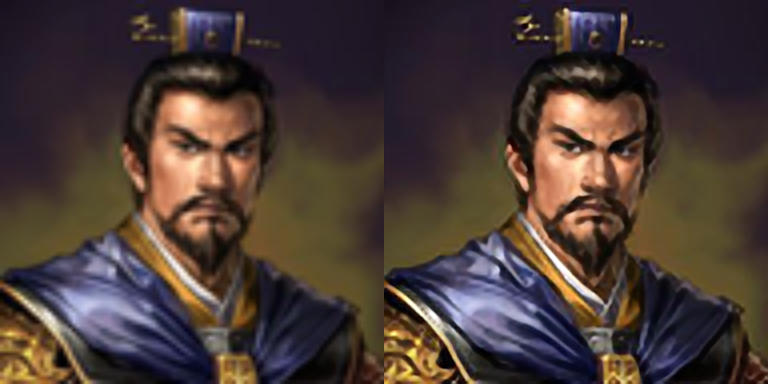

In [37]:
import os
import cv2
import numpy as np
from IPython.display import Image

import mmcv
import torch

from mmedit.apis import init_model, restoration_inference
from mmedit.core import tensor2img

config_file = 'configs/restorers/srcnn/srcnn_x4k915_g1_1000k_div2k.py'
checkpoint_file = 'checkpoints/srcnn_x4k915_1x16_1000k_div2k_20200608-4186f232.pth'
checkpoint_file = 'work_dirs/srcnn_x4k915_g1_1000k_div2k/iter_115000.pth'
# build and initialize model
model = init_model(
        config_file, checkpoint_file, device=torch.device('cuda', 0))

# test a single image
img_path = 'demo/before.png'
output = restoration_inference(model, img_path)
output = tensor2img(output)

# show and write output
os.makedirs('results', exist_ok=True)
combine_result = np.concatenate([input_bilinear, output], axis=1)
mmcv.imwrite(combine_result, 'results/demo_bilinear_srcnn.png')

print('bilinear upsample result and srcnn result')
Image(filename='results/demo_bilinear_srcnn.png') 
